In [1]:
import keras
from keras.models import Sequential
from keras.applications.inception_v3 import InceptionV3
from keras.layers import Dense, InputLayer, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D
from keras.preprocessing import image
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.externals import joblib 
import pickle

Using TensorFlow backend.
C:\Users\HH TRADERS\Anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
train = pd.read_csv('../data/train_OF.csv')
train.sort_values(by=['class', 'image'])
train.tail()

,image,class
42373,winKen_wave_u_cm_np1_ri_bad_1_flow6.jpg,wave
42374,winKen_wave_u_cm_np1_ri_bad_1_flow7.jpg,wave
42375,winKen_wave_u_cm_np1_ri_bad_1_flow7.jpg,wave
42376,winKen_wave_u_cm_np1_ri_bad_1_flow8.jpg,wave
42377,winKen_wave_u_cm_np1_ri_bad_1_flow8.jpg,wave


In [3]:
# creating an empty list
train_image = []

# for loop to read and store frames
for i in tqdm(range(train.shape[0])):
    # loading the image and keeping the target size as (224,224,3)
    img = image.load_img('../data/train_frame_OF/'+train['image'][i], target_size=(224,224,3))
    # converting it to array
    img = image.img_to_array(img)
    # normalizing the pixel value
    img = img/255
    # appending the image to the train_image list
    train_image.append(img)

100%|██████████| 42378/42378 [02:42<00:00, 261.16it/s]


In [4]:
# converting the list to numpy array
X_train = np.array(train_image,np.float16)

# shape of the array
X_train.shape

(42378, 224, 224, 3)

In [5]:
val = pd.read_csv('../data/val_OF.csv')
val.sort_values(by=['class', 'image'])
val.tail()

,image,class
8798,prelinger_LetsBeGo1953_wave_u_cm_np10_ba_med_3...,wave
8799,prelinger_LetsBeGo1953_wave_u_cm_np10_ba_med_3...,wave
8800,prelinger_LetsBeGo1953_wave_u_cm_np10_ba_med_3...,wave
8801,prelinger_LetsBeGo1953_wave_u_cm_np10_ba_med_3...,wave
8802,prelinger_LetsBeGo1953_wave_u_cm_np10_ba_med_3...,wave


In [6]:
# creating an empty list
val_image = []

# for loop to read and store frames
for i in tqdm(range(val.shape[0])):
    # loading the image and keeping the target size as (224,224,3)
    img = image.load_img('../data/val_frame_OF/'+val['image'][i], target_size=(224,224,3))
    # converting it to array
    img = image.img_to_array(img)
    # normalizing the pixel value
    img = img/255
    # appending the image to the train_image list
    val_image.append(img)

100%|██████████| 8803/8803 [01:34<00:00, 93.59it/s] 


In [7]:
# converting the list to numpy array
X_test = np.array(val_image,np.float16)

# shape of the array
X_test.shape

(8803, 224, 224, 3)

In [8]:
# separating the target
y_train = train['class']
y_test = val['class']
print(train.nunique())
print(val.nunique())

image    21189
class       51
dtype: int64
image    8803
class      51
dtype: int64


In [9]:
# creating dummies of target variable for train and validation set
y_train = pd.get_dummies(y_train)
y_test = pd.get_dummies(y_test)
print(y_train.shape)
print(y_test.shape)

(42378, 51)
(8803, 51)


In [10]:
base_model = InceptionV3(include_top=False, weights='imagenet')

In [11]:
print(base_model.output_shape)

(None, None, None, 2048)


In [12]:
base_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, None, None, 3 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, None, None, 3 0           batch_normalization_1[0][0]      
_______________________________________________________________________________________

__________________________________________________________________________________________________
mixed0 (Concatenate)            (None, None, None, 2 0           activation_6[0][0]               
                                                                 activation_8[0][0]               
                                                                 activation_11[0][0]              
                                                                 activation_12[0][0]              
__________________________________________________________________________________________________
conv2d_16 (Conv2D)              (None, None, None, 6 16384       mixed0[0][0]                     
__________________________________________________________________________________________________
batch_normalization_16 (BatchNo (None, None, None, 6 192         conv2d_16[0][0]                  
__________________________________________________________________________________________________
activation

__________________________________________________________________________________________________
batch_normalization_20 (BatchNo (None, None, None, 6 192         conv2d_20[0][0]                  
__________________________________________________________________________________________________
batch_normalization_22 (BatchNo (None, None, None, 6 192         conv2d_22[0][0]                  
__________________________________________________________________________________________________
batch_normalization_25 (BatchNo (None, None, None, 9 288         conv2d_25[0][0]                  
__________________________________________________________________________________________________
batch_normalization_26 (BatchNo (None, None, None, 6 192         conv2d_26[0][0]                  
__________________________________________________________________________________________________
activation_20 (Activation)      (None, None, None, 6 0           batch_normalization_20[0][0]     
__________

batch_normalization_38 (BatchNo (None, None, None, 1 384         conv2d_38[0][0]                  
__________________________________________________________________________________________________
activation_33 (Activation)      (None, None, None, 1 0           batch_normalization_33[0][0]     
__________________________________________________________________________________________________
activation_38 (Activation)      (None, None, None, 1 0           batch_normalization_38[0][0]     
__________________________________________________________________________________________________
average_pooling2d_4 (AveragePoo (None, None, None, 7 0           mixed3[0][0]                     
__________________________________________________________________________________________________
conv2d_31 (Conv2D)              (None, None, None, 1 147456      mixed3[0][0]                     
__________________________________________________________________________________________________
conv2d_34 

__________________________________________________________________________________________________
batch_normalization_41 (BatchNo (None, None, None, 1 576         conv2d_41[0][0]                  
__________________________________________________________________________________________________
batch_normalization_44 (BatchNo (None, None, None, 1 576         conv2d_44[0][0]                  
__________________________________________________________________________________________________
batch_normalization_49 (BatchNo (None, None, None, 1 576         conv2d_49[0][0]                  
__________________________________________________________________________________________________
batch_normalization_50 (BatchNo (None, None, None, 1 576         conv2d_50[0][0]                  
__________________________________________________________________________________________________
activation_41 (Activation)      (None, None, None, 1 0           batch_normalization_41[0][0]     
__________

activation_60 (Activation)      (None, None, None, 1 0           batch_normalization_60[0][0]     
__________________________________________________________________________________________________
mixed6 (Concatenate)            (None, None, None, 7 0           activation_51[0][0]              
                                                                 activation_54[0][0]              
                                                                 activation_59[0][0]              
                                                                 activation_60[0][0]              
__________________________________________________________________________________________________
conv2d_65 (Conv2D)              (None, None, None, 1 147456      mixed6[0][0]                     
__________________________________________________________________________________________________
batch_normalization_65 (BatchNo (None, None, None, 1 576         conv2d_65[0][0]                  
__________

batch_normalization_74 (BatchNo (None, None, None, 1 576         conv2d_74[0][0]                  
__________________________________________________________________________________________________
activation_74 (Activation)      (None, None, None, 1 0           batch_normalization_74[0][0]     
__________________________________________________________________________________________________
conv2d_71 (Conv2D)              (None, None, None, 1 147456      mixed7[0][0]                     
__________________________________________________________________________________________________
conv2d_75 (Conv2D)              (None, None, None, 1 258048      activation_74[0][0]              
__________________________________________________________________________________________________
batch_normalization_71 (BatchNo (None, None, None, 1 576         conv2d_71[0][0]                  
__________________________________________________________________________________________________
batch_norm

activation_84 (Activation)      (None, None, None, 3 0           batch_normalization_84[0][0]     
__________________________________________________________________________________________________
batch_normalization_85 (BatchNo (None, None, None, 1 576         conv2d_85[0][0]                  
__________________________________________________________________________________________________
activation_77 (Activation)      (None, None, None, 3 0           batch_normalization_77[0][0]     
__________________________________________________________________________________________________
mixed9_0 (Concatenate)          (None, None, None, 7 0           activation_79[0][0]              
                                                                 activation_80[0][0]              
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, None, None, 7 0           activation_83[0][0]              
          

                                                                 mixed9_1[0][0]                   
                                                                 concatenate_2[0][0]              
                                                                 activation_94[0][0]              
Total params: 21,802,784
Trainable params: 21,768,352
Non-trainable params: 34,432
__________________________________________________________________________________________________


In [13]:
base_model.get_config()

{'name': 'inception_v3',
 'layers': [{'name': 'input_1',
   'class_name': 'InputLayer',
   'config': {'batch_input_shape': (None, None, None, 3),
    'dtype': 'float32',
    'sparse': False,
    'name': 'input_1'},
   'inbound_nodes': []},
  {'name': 'conv2d_1',
   'class_name': 'Conv2D',
   'config': {'name': 'conv2d_1',
    'trainable': True,
    'dtype': 'float32',
    'filters': 32,
    'kernel_size': (3, 3),
    'strides': (2, 2),
    'padding': 'valid',
    'data_format': 'channels_last',
    'dilation_rate': (1, 1),
    'activation': 'linear',
    'use_bias': False,
    'kernel_initializer': {'class_name': 'VarianceScaling',
     'config': {'scale': 1.0,
      'mode': 'fan_avg',
      'distribution': 'uniform',
      'seed': None}},
    'bias_initializer': {'class_name': 'Zeros', 'config': {}},
    'kernel_regularizer': None,
    'bias_regularizer': None,
    'activity_regularizer': None,
    'kernel_constraint': None,
    'bias_constraint': None},
   'inbound_nodes': [[['input_

In [14]:
t1=datetime.datetime.now()
print(t1)
# extracting features for training frames
X_train = base_model.predict(X_train)
print(X_train.shape)
t2=datetime.datetime.now()
print(t2)

2020-08-19 18:32:10.364313
(42378, 5, 5, 2048)
2020-08-19 20:52:52.343397


In [15]:
t3=datetime.datetime.now()
print(t3)
# extracting features for validation frames
X_test = base_model.predict(X_test)
print(X_test.shape)
t4=datetime.datetime.now()
print(t4)

2020-08-19 20:52:52.408223
(8803, 5, 5, 2048)
2020-08-19 21:17:49.710614


In [16]:
# reshaping the training as well as validation frames in single dimension
X_train = X_train.reshape(42378, 5*5*2048)
X_test = X_test.reshape(8803, 5*5*2048)

In [17]:
# normalizing the pixel values
max = X_train.max()
X_train = X_train/max
X_test = X_test/max

In [31]:
pickle_out = open('../Pickle/InceptionV3_X_train_OF.pickle',"wb")
pickle.dump(X_train, pickle_out, protocol=4)
pickle_out.close()

In [14]:
pickle_in = open('../Pickle/InceptionV3_X_train_OF.pickle',"rb")
X_train = pickle.load(pickle_in)
print(X_train.shape)

(42378, 51200)


In [ ]:
joblib.dump(X_test, '../Pickle/InceptionV3_X_test_OF.pkl')

In [16]:
X_test = joblib.load('../Pickle/InceptionV3_X_test_OF.pkl') 

In [17]:
# shape of images
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(42378, 51200)
(8803, 51200)
(42378, 51)
(8803, 51)


In [18]:
#defining the model architecture
model = Sequential()
model.add(Dense(1024, activation='relu', input_shape=(51200,)))
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(51, activation='softmax'))

In [19]:
model.output_shape

(None, 51)

In [20]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1024)              52429824  
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)              

In [21]:
model.get_config()

{'name': 'sequential_1',
 'layers': [{'class_name': 'Dense',
   'config': {'name': 'dense_1',
    'trainable': True,
    'batch_input_shape': (None, 51200),
    'dtype': 'float32',
    'units': 1024,
    'activation': 'relu',
    'use_bias': True,
    'kernel_initializer': {'class_name': 'VarianceScaling',
     'config': {'scale': 1.0,
      'mode': 'fan_avg',
      'distribution': 'uniform',
      'seed': None}},
    'bias_initializer': {'class_name': 'Zeros', 'config': {}},
    'kernel_regularizer': None,
    'bias_regularizer': None,
    'activity_regularizer': None,
    'kernel_constraint': None,
    'bias_constraint': None}},
  {'class_name': 'Dropout',
   'config': {'name': 'dropout_1',
    'trainable': True,
    'dtype': 'float32',
    'rate': 0.5,
    'noise_shape': None,
    'seed': None}},
  {'class_name': 'Dense',
   'config': {'name': 'dense_2',
    'trainable': True,
    'dtype': 'float32',
    'units': 512,
    'activation': 'relu',
    'use_bias': True,
    'kernel_initi

In [22]:
# defining a function to save the weights of best model
from keras.callbacks import ModelCheckpoint
mcp_save = ModelCheckpoint('../Models/weightInceptionV3_OF.hdf5', save_best_only=True, monitor='val_loss', mode='min')

In [23]:
# compiling the model
model.compile(loss='categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])

In [24]:
# training the model
t5=datetime.datetime.now()
print(t5)
history=model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), callbacks=[mcp_save], batch_size=128)
t6=datetime.datetime.now()
print(t6)

2020-08-19 22:38:55.208384
Train on 42378 samples, validate on 8803 samples
Epoch 1/100


23424/42378 [===============>..............] - ETA: 19:36 - loss: 3.9346 - accuracy: 0.0000e+0 - ETA: 12:49 - loss: 4.0289 - accuracy: 0.0078    - ETA: 10:12 - loss: 4.0581 - accuracy: 0.007 - ETA: 9:02 - loss: 4.0608 - accuracy: 0.011 - ETA: 8:21 - loss: 4.0847 - accuracy: 0.01 - ETA: 7:51 - loss: 4.0857 - accuracy: 0.01 - ETA: 7:29 - loss: 4.0755 - accuracy: 0.01 - ETA: 7:14 - loss: 4.0657 - accuracy: 0.01 - ETA: 7:04 - loss: 4.0684 - accuracy: 0.01 - ETA: 6:53 - loss: 4.0712 - accuracy: 0.01 - ETA: 6:45 - loss: 4.0724 - accuracy: 0.01 - ETA: 6:39 - loss: 4.0670 - accuracy: 0.01 - ETA: 6:31 - loss: 4.0635 - accuracy: 0.01 - ETA: 6:23 - loss: 4.0607 - accuracy: 0.01 - ETA: 6:17 - loss: 4.0596 - accuracy: 0.01 - ETA: 6:12 - loss: 4.0556 - accuracy: 0.02 - ETA: 6:07 - loss: 4.0520 - accuracy: 0.02 - ETA: 6:04 - loss: 4.0485 - accuracy: 0.02 - ETA: 6:01 - loss: 4.0445 - accuracy: 0.02 - ETA: 5:58 - loss: 4.0372 - accuracy: 0.02 - ETA: 5:55 - loss: 4.0303 - accuracy: 0.02 - ETA: 5:52 - lo

42378/42378 [==============================] - ETA: 2:37 - loss: 3.8567 - accuracy: 0.04 - ETA: 2:36 - loss: 3.8564 - accuracy: 0.04 - ETA: 2:35 - loss: 3.8560 - accuracy: 0.04 - ETA: 2:34 - loss: 3.8561 - accuracy: 0.04 - ETA: 2:33 - loss: 3.8560 - accuracy: 0.04 - ETA: 2:32 - loss: 3.8552 - accuracy: 0.04 - ETA: 2:31 - loss: 3.8548 - accuracy: 0.04 - ETA: 2:30 - loss: 3.8544 - accuracy: 0.04 - ETA: 2:29 - loss: 3.8545 - accuracy: 0.04 - ETA: 2:27 - loss: 3.8535 - accuracy: 0.04 - ETA: 2:26 - loss: 3.8526 - accuracy: 0.04 - ETA: 2:25 - loss: 3.8521 - accuracy: 0.04 - ETA: 2:24 - loss: 3.8518 - accuracy: 0.04 - ETA: 2:23 - loss: 3.8512 - accuracy: 0.04 - ETA: 2:22 - loss: 3.8505 - accuracy: 0.04 - ETA: 2:21 - loss: 3.8504 - accuracy: 0.04 - ETA: 2:20 - loss: 3.8502 - accuracy: 0.04 - ETA: 2:19 - loss: 3.8500 - accuracy: 0.04 - ETA: 2:18 - loss: 3.8499 - accuracy: 0.04 - ETA: 2:17 - loss: 3.8492 - accuracy: 0.04 - ETA: 2:16 - loss: 3.8483 - accuracy: 0.04 - ETA: 2:15 - loss: 3.8480 - ac

23808/42378 [===============>..............] - ETA: 5:07 - loss: 3.6882 - accuracy: 0.03 - ETA: 5:03 - loss: 3.6056 - accuracy: 0.08 - ETA: 5:05 - loss: 3.6486 - accuracy: 0.08 - ETA: 5:08 - loss: 3.6545 - accuracy: 0.08 - ETA: 5:09 - loss: 3.6214 - accuracy: 0.10 - ETA: 5:08 - loss: 3.6286 - accuracy: 0.09 - ETA: 5:09 - loss: 3.6440 - accuracy: 0.09 - ETA: 5:08 - loss: 3.6430 - accuracy: 0.08 - ETA: 5:09 - loss: 3.6497 - accuracy: 0.08 - ETA: 5:09 - loss: 3.6548 - accuracy: 0.08 - ETA: 5:08 - loss: 3.6575 - accuracy: 0.08 - ETA: 5:07 - loss: 3.6543 - accuracy: 0.08 - ETA: 5:05 - loss: 3.6542 - accuracy: 0.09 - ETA: 5:05 - loss: 3.6575 - accuracy: 0.08 - ETA: 5:05 - loss: 3.6534 - accuracy: 0.08 - ETA: 5:04 - loss: 3.6526 - accuracy: 0.08 - ETA: 5:03 - loss: 3.6537 - accuracy: 0.08 - ETA: 5:02 - loss: 3.6440 - accuracy: 0.08 - ETA: 5:00 - loss: 3.6531 - accuracy: 0.08 - ETA: 4:59 - loss: 3.6456 - accuracy: 0.09 - ETA: 4:58 - loss: 3.6448 - accuracy: 0.09 - ETA: 4:58 - loss: 3.6442 - ac

42378/42378 [==============================] - ETA: 2:18 - loss: 3.5652 - accuracy: 0.10 - ETA: 2:17 - loss: 3.5644 - accuracy: 0.10 - ETA: 2:16 - loss: 3.5643 - accuracy: 0.10 - ETA: 2:15 - loss: 3.5635 - accuracy: 0.10 - ETA: 2:14 - loss: 3.5632 - accuracy: 0.10 - ETA: 2:13 - loss: 3.5627 - accuracy: 0.10 - ETA: 2:12 - loss: 3.5616 - accuracy: 0.10 - ETA: 2:11 - loss: 3.5608 - accuracy: 0.10 - ETA: 2:10 - loss: 3.5603 - accuracy: 0.10 - ETA: 2:09 - loss: 3.5600 - accuracy: 0.10 - ETA: 2:09 - loss: 3.5603 - accuracy: 0.10 - ETA: 2:08 - loss: 3.5595 - accuracy: 0.10 - ETA: 2:07 - loss: 3.5594 - accuracy: 0.10 - ETA: 2:06 - loss: 3.5592 - accuracy: 0.10 - ETA: 2:05 - loss: 3.5590 - accuracy: 0.10 - ETA: 2:04 - loss: 3.5583 - accuracy: 0.10 - ETA: 2:03 - loss: 3.5586 - accuracy: 0.10 - ETA: 2:02 - loss: 3.5582 - accuracy: 0.10 - ETA: 2:01 - loss: 3.5578 - accuracy: 0.10 - ETA: 2:00 - loss: 3.5578 - accuracy: 0.10 - ETA: 1:59 - loss: 3.5572 - accuracy: 0.10 - ETA: 1:58 - loss: 3.5566 - ac

23808/42378 [===============>..............] - ETA: 5:28 - loss: 3.3114 - accuracy: 0.17 - ETA: 5:24 - loss: 3.4684 - accuracy: 0.14 - ETA: 5:20 - loss: 3.3501 - accuracy: 0.16 - ETA: 5:19 - loss: 3.3378 - accuracy: 0.15 - ETA: 5:16 - loss: 3.3892 - accuracy: 0.14 - ETA: 5:13 - loss: 3.3889 - accuracy: 0.14 - ETA: 5:14 - loss: 3.3871 - accuracy: 0.14 - ETA: 5:16 - loss: 3.3605 - accuracy: 0.15 - ETA: 5:15 - loss: 3.3650 - accuracy: 0.15 - ETA: 5:13 - loss: 3.3693 - accuracy: 0.15 - ETA: 5:11 - loss: 3.3686 - accuracy: 0.15 - ETA: 5:09 - loss: 3.3806 - accuracy: 0.15 - ETA: 5:09 - loss: 3.3723 - accuracy: 0.15 - ETA: 5:07 - loss: 3.3860 - accuracy: 0.14 - ETA: 5:06 - loss: 3.3901 - accuracy: 0.14 - ETA: 5:06 - loss: 3.3936 - accuracy: 0.14 - ETA: 5:05 - loss: 3.3874 - accuracy: 0.14 - ETA: 5:04 - loss: 3.3902 - accuracy: 0.14 - ETA: 5:03 - loss: 3.3921 - accuracy: 0.14 - ETA: 5:01 - loss: 3.3872 - accuracy: 0.14 - ETA: 5:00 - loss: 3.3764 - accuracy: 0.14 - ETA: 4:58 - loss: 3.3805 - ac

42378/42378 [==============================] - ETA: 2:18 - loss: 3.3050 - accuracy: 0.16 - ETA: 2:17 - loss: 3.3052 - accuracy: 0.16 - ETA: 2:16 - loss: 3.3036 - accuracy: 0.16 - ETA: 2:15 - loss: 3.3031 - accuracy: 0.16 - ETA: 2:14 - loss: 3.3018 - accuracy: 0.16 - ETA: 2:13 - loss: 3.3018 - accuracy: 0.16 - ETA: 2:12 - loss: 3.3019 - accuracy: 0.16 - ETA: 2:11 - loss: 3.3008 - accuracy: 0.16 - ETA: 2:10 - loss: 3.3008 - accuracy: 0.16 - ETA: 2:09 - loss: 3.3000 - accuracy: 0.16 - ETA: 2:09 - loss: 3.2990 - accuracy: 0.16 - ETA: 2:08 - loss: 3.2978 - accuracy: 0.16 - ETA: 2:07 - loss: 3.2987 - accuracy: 0.16 - ETA: 2:06 - loss: 3.2992 - accuracy: 0.16 - ETA: 2:05 - loss: 3.2995 - accuracy: 0.16 - ETA: 2:04 - loss: 3.2991 - accuracy: 0.16 - ETA: 2:03 - loss: 3.2993 - accuracy: 0.16 - ETA: 2:02 - loss: 3.2989 - accuracy: 0.16 - ETA: 2:01 - loss: 3.2976 - accuracy: 0.16 - ETA: 2:00 - loss: 3.2970 - accuracy: 0.16 - ETA: 1:59 - loss: 3.2971 - accuracy: 0.16 - ETA: 1:58 - loss: 3.2964 - ac

23808/42378 [===============>..............] - ETA: 5:37 - loss: 3.0940 - accuracy: 0.20 - ETA: 5:16 - loss: 3.1160 - accuracy: 0.18 - ETA: 5:16 - loss: 3.1597 - accuracy: 0.18 - ETA: 5:19 - loss: 3.1645 - accuracy: 0.17 - ETA: 5:18 - loss: 3.1763 - accuracy: 0.18 - ETA: 5:14 - loss: 3.1486 - accuracy: 0.19 - ETA: 5:10 - loss: 3.1287 - accuracy: 0.19 - ETA: 5:07 - loss: 3.1242 - accuracy: 0.20 - ETA: 5:05 - loss: 3.1321 - accuracy: 0.19 - ETA: 5:07 - loss: 3.1316 - accuracy: 0.20 - ETA: 5:07 - loss: 3.1150 - accuracy: 0.20 - ETA: 5:05 - loss: 3.1306 - accuracy: 0.20 - ETA: 5:03 - loss: 3.1349 - accuracy: 0.20 - ETA: 5:02 - loss: 3.1472 - accuracy: 0.19 - ETA: 5:02 - loss: 3.1449 - accuracy: 0.20 - ETA: 5:01 - loss: 3.1466 - accuracy: 0.20 - ETA: 5:01 - loss: 3.1479 - accuracy: 0.19 - ETA: 4:59 - loss: 3.1412 - accuracy: 0.20 - ETA: 4:58 - loss: 3.1457 - accuracy: 0.20 - ETA: 4:57 - loss: 3.1404 - accuracy: 0.20 - ETA: 4:57 - loss: 3.1411 - accuracy: 0.20 - ETA: 4:56 - loss: 3.1460 - ac

42378/42378 [==============================] - ETA: 2:18 - loss: 3.0942 - accuracy: 0.21 - ETA: 2:17 - loss: 3.0932 - accuracy: 0.21 - ETA: 2:16 - loss: 3.0917 - accuracy: 0.21 - ETA: 2:15 - loss: 3.0902 - accuracy: 0.21 - ETA: 2:14 - loss: 3.0895 - accuracy: 0.21 - ETA: 2:13 - loss: 3.0879 - accuracy: 0.21 - ETA: 2:12 - loss: 3.0871 - accuracy: 0.21 - ETA: 2:11 - loss: 3.0871 - accuracy: 0.21 - ETA: 2:10 - loss: 3.0881 - accuracy: 0.21 - ETA: 2:09 - loss: 3.0885 - accuracy: 0.21 - ETA: 2:09 - loss: 3.0878 - accuracy: 0.21 - ETA: 2:08 - loss: 3.0890 - accuracy: 0.21 - ETA: 2:07 - loss: 3.0882 - accuracy: 0.21 - ETA: 2:06 - loss: 3.0882 - accuracy: 0.21 - ETA: 2:05 - loss: 3.0877 - accuracy: 0.21 - ETA: 2:04 - loss: 3.0879 - accuracy: 0.21 - ETA: 2:03 - loss: 3.0887 - accuracy: 0.21 - ETA: 2:02 - loss: 3.0885 - accuracy: 0.21 - ETA: 2:01 - loss: 3.0890 - accuracy: 0.21 - ETA: 2:00 - loss: 3.0894 - accuracy: 0.21 - ETA: 1:59 - loss: 3.0891 - accuracy: 0.21 - ETA: 1:58 - loss: 3.0890 - ac

23808/42378 [===============>..............] - ETA: 5:17 - loss: 3.0004 - accuracy: 0.17 - ETA: 5:22 - loss: 2.9548 - accuracy: 0.21 - ETA: 5:20 - loss: 2.9697 - accuracy: 0.22 - ETA: 5:20 - loss: 2.9529 - accuracy: 0.21 - ETA: 5:16 - loss: 2.9760 - accuracy: 0.21 - ETA: 5:16 - loss: 2.9754 - accuracy: 0.20 - ETA: 5:13 - loss: 2.9760 - accuracy: 0.21 - ETA: 5:11 - loss: 2.9780 - accuracy: 0.21 - ETA: 5:08 - loss: 2.9721 - accuracy: 0.21 - ETA: 5:08 - loss: 2.9733 - accuracy: 0.21 - ETA: 5:09 - loss: 2.9700 - accuracy: 0.21 - ETA: 5:08 - loss: 2.9841 - accuracy: 0.21 - ETA: 5:08 - loss: 2.9887 - accuracy: 0.21 - ETA: 5:08 - loss: 2.9790 - accuracy: 0.21 - ETA: 5:08 - loss: 2.9795 - accuracy: 0.21 - ETA: 5:07 - loss: 2.9696 - accuracy: 0.21 - ETA: 5:05 - loss: 2.9712 - accuracy: 0.21 - ETA: 5:03 - loss: 2.9695 - accuracy: 0.21 - ETA: 5:02 - loss: 2.9660 - accuracy: 0.22 - ETA: 5:01 - loss: 2.9702 - accuracy: 0.22 - ETA: 5:00 - loss: 2.9749 - accuracy: 0.22 - ETA: 4:59 - loss: 2.9736 - ac

42378/42378 [==============================] - ETA: 2:18 - loss: 2.9214 - accuracy: 0.24 - ETA: 2:17 - loss: 2.9214 - accuracy: 0.24 - ETA: 2:16 - loss: 2.9202 - accuracy: 0.24 - ETA: 2:15 - loss: 2.9206 - accuracy: 0.24 - ETA: 2:14 - loss: 2.9196 - accuracy: 0.24 - ETA: 2:13 - loss: 2.9207 - accuracy: 0.24 - ETA: 2:12 - loss: 2.9204 - accuracy: 0.24 - ETA: 2:11 - loss: 2.9202 - accuracy: 0.24 - ETA: 2:10 - loss: 2.9195 - accuracy: 0.24 - ETA: 2:09 - loss: 2.9186 - accuracy: 0.24 - ETA: 2:08 - loss: 2.9200 - accuracy: 0.24 - ETA: 2:07 - loss: 2.9197 - accuracy: 0.24 - ETA: 2:06 - loss: 2.9194 - accuracy: 0.24 - ETA: 2:05 - loss: 2.9194 - accuracy: 0.24 - ETA: 2:04 - loss: 2.9179 - accuracy: 0.24 - ETA: 2:03 - loss: 2.9178 - accuracy: 0.24 - ETA: 2:02 - loss: 2.9185 - accuracy: 0.24 - ETA: 2:01 - loss: 2.9182 - accuracy: 0.24 - ETA: 2:00 - loss: 2.9183 - accuracy: 0.24 - ETA: 1:59 - loss: 2.9180 - accuracy: 0.24 - ETA: 1:58 - loss: 2.9178 - accuracy: 0.24 - ETA: 1:57 - loss: 2.9164 - ac

23808/42378 [===============>..............] - ETA: 5:25 - loss: 2.7726 - accuracy: 0.28 - ETA: 5:20 - loss: 2.7975 - accuracy: 0.27 - ETA: 5:16 - loss: 2.9030 - accuracy: 0.24 - ETA: 5:14 - loss: 2.8544 - accuracy: 0.25 - ETA: 5:11 - loss: 2.8147 - accuracy: 0.27 - ETA: 5:08 - loss: 2.8217 - accuracy: 0.27 - ETA: 5:07 - loss: 2.8023 - accuracy: 0.28 - ETA: 5:06 - loss: 2.7932 - accuracy: 0.28 - ETA: 5:05 - loss: 2.7837 - accuracy: 0.27 - ETA: 5:04 - loss: 2.8140 - accuracy: 0.27 - ETA: 5:02 - loss: 2.8343 - accuracy: 0.27 - ETA: 5:01 - loss: 2.8358 - accuracy: 0.26 - ETA: 5:01 - loss: 2.8371 - accuracy: 0.27 - ETA: 5:00 - loss: 2.8247 - accuracy: 0.27 - ETA: 4:59 - loss: 2.8176 - accuracy: 0.27 - ETA: 4:57 - loss: 2.8248 - accuracy: 0.27 - ETA: 4:56 - loss: 2.8326 - accuracy: 0.27 - ETA: 4:55 - loss: 2.8279 - accuracy: 0.27 - ETA: 4:55 - loss: 2.8192 - accuracy: 0.27 - ETA: 4:54 - loss: 2.8335 - accuracy: 0.27 - ETA: 4:52 - loss: 2.8409 - accuracy: 0.26 - ETA: 4:51 - loss: 2.8362 - ac

42378/42378 [==============================] - ETA: 2:16 - loss: 2.7907 - accuracy: 0.26 - ETA: 2:15 - loss: 2.7911 - accuracy: 0.26 - ETA: 2:14 - loss: 2.7904 - accuracy: 0.26 - ETA: 2:13 - loss: 2.7891 - accuracy: 0.26 - ETA: 2:12 - loss: 2.7882 - accuracy: 0.26 - ETA: 2:12 - loss: 2.7885 - accuracy: 0.26 - ETA: 2:11 - loss: 2.7872 - accuracy: 0.26 - ETA: 2:10 - loss: 2.7850 - accuracy: 0.26 - ETA: 2:09 - loss: 2.7855 - accuracy: 0.26 - ETA: 2:08 - loss: 2.7858 - accuracy: 0.26 - ETA: 2:07 - loss: 2.7859 - accuracy: 0.26 - ETA: 2:06 - loss: 2.7854 - accuracy: 0.26 - ETA: 2:05 - loss: 2.7854 - accuracy: 0.26 - ETA: 2:04 - loss: 2.7849 - accuracy: 0.26 - ETA: 2:03 - loss: 2.7842 - accuracy: 0.26 - ETA: 2:02 - loss: 2.7843 - accuracy: 0.26 - ETA: 2:01 - loss: 2.7849 - accuracy: 0.26 - ETA: 2:00 - loss: 2.7839 - accuracy: 0.26 - ETA: 1:59 - loss: 2.7836 - accuracy: 0.26 - ETA: 1:58 - loss: 2.7834 - accuracy: 0.26 - ETA: 1:57 - loss: 2.7826 - accuracy: 0.26 - ETA: 1:56 - loss: 2.7823 - ac

23808/42378 [===============>..............] - ETA: 5:22 - loss: 2.7716 - accuracy: 0.25 - ETA: 5:13 - loss: 2.8206 - accuracy: 0.22 - ETA: 5:12 - loss: 2.8656 - accuracy: 0.23 - ETA: 5:14 - loss: 2.8207 - accuracy: 0.24 - ETA: 5:09 - loss: 2.7399 - accuracy: 0.25 - ETA: 5:10 - loss: 2.7595 - accuracy: 0.25 - ETA: 5:10 - loss: 2.7624 - accuracy: 0.25 - ETA: 5:07 - loss: 2.7798 - accuracy: 0.24 - ETA: 5:05 - loss: 2.7979 - accuracy: 0.24 - ETA: 5:04 - loss: 2.7894 - accuracy: 0.25 - ETA: 5:04 - loss: 2.7791 - accuracy: 0.25 - ETA: 5:05 - loss: 2.7766 - accuracy: 0.25 - ETA: 5:04 - loss: 2.7607 - accuracy: 0.25 - ETA: 5:03 - loss: 2.7466 - accuracy: 0.26 - ETA: 5:02 - loss: 2.7523 - accuracy: 0.26 - ETA: 5:00 - loss: 2.7476 - accuracy: 0.26 - ETA: 4:59 - loss: 2.7465 - accuracy: 0.26 - ETA: 4:59 - loss: 2.7466 - accuracy: 0.26 - ETA: 4:58 - loss: 2.7354 - accuracy: 0.27 - ETA: 4:57 - loss: 2.7259 - accuracy: 0.27 - ETA: 4:57 - loss: 2.7374 - accuracy: 0.26 - ETA: 4:55 - loss: 2.7355 - ac

42378/42378 [==============================] - ETA: 2:17 - loss: 2.6707 - accuracy: 0.29 - ETA: 2:16 - loss: 2.6700 - accuracy: 0.29 - ETA: 2:16 - loss: 2.6694 - accuracy: 0.29 - ETA: 2:15 - loss: 2.6687 - accuracy: 0.29 - ETA: 2:14 - loss: 2.6693 - accuracy: 0.29 - ETA: 2:13 - loss: 2.6687 - accuracy: 0.29 - ETA: 2:12 - loss: 2.6690 - accuracy: 0.29 - ETA: 2:11 - loss: 2.6689 - accuracy: 0.29 - ETA: 2:10 - loss: 2.6674 - accuracy: 0.29 - ETA: 2:09 - loss: 2.6681 - accuracy: 0.29 - ETA: 2:08 - loss: 2.6679 - accuracy: 0.29 - ETA: 2:07 - loss: 2.6671 - accuracy: 0.29 - ETA: 2:06 - loss: 2.6667 - accuracy: 0.29 - ETA: 2:05 - loss: 2.6664 - accuracy: 0.29 - ETA: 2:04 - loss: 2.6666 - accuracy: 0.29 - ETA: 2:03 - loss: 2.6667 - accuracy: 0.29 - ETA: 2:02 - loss: 2.6665 - accuracy: 0.29 - ETA: 2:01 - loss: 2.6662 - accuracy: 0.29 - ETA: 2:00 - loss: 2.6665 - accuracy: 0.29 - ETA: 1:59 - loss: 2.6676 - accuracy: 0.29 - ETA: 1:58 - loss: 2.6664 - accuracy: 0.29 - ETA: 1:57 - loss: 2.6670 - ac

23808/42378 [===============>..............] - ETA: 5:22 - loss: 2.6217 - accuracy: 0.28 - ETA: 5:18 - loss: 2.6134 - accuracy: 0.30 - ETA: 5:15 - loss: 2.6791 - accuracy: 0.28 - ETA: 5:13 - loss: 2.6598 - accuracy: 0.29 - ETA: 5:12 - loss: 2.6889 - accuracy: 0.29 - ETA: 5:09 - loss: 2.7056 - accuracy: 0.28 - ETA: 5:07 - loss: 2.7563 - accuracy: 0.27 - ETA: 5:06 - loss: 2.7628 - accuracy: 0.26 - ETA: 5:06 - loss: 2.7290 - accuracy: 0.27 - ETA: 5:05 - loss: 2.7055 - accuracy: 0.28 - ETA: 5:04 - loss: 2.6779 - accuracy: 0.28 - ETA: 5:02 - loss: 2.6574 - accuracy: 0.29 - ETA: 5:01 - loss: 2.6518 - accuracy: 0.29 - ETA: 4:59 - loss: 2.6593 - accuracy: 0.29 - ETA: 4:58 - loss: 2.6664 - accuracy: 0.28 - ETA: 4:56 - loss: 2.6644 - accuracy: 0.28 - ETA: 4:56 - loss: 2.6588 - accuracy: 0.28 - ETA: 4:55 - loss: 2.6696 - accuracy: 0.28 - ETA: 4:54 - loss: 2.6645 - accuracy: 0.28 - ETA: 4:52 - loss: 2.6611 - accuracy: 0.28 - ETA: 4:51 - loss: 2.6600 - accuracy: 0.28 - ETA: 4:51 - loss: 2.6532 - ac

42378/42378 [==============================] - ETA: 2:16 - loss: 2.5842 - accuracy: 0.30 - ETA: 2:15 - loss: 2.5842 - accuracy: 0.30 - ETA: 2:14 - loss: 2.5834 - accuracy: 0.30 - ETA: 2:13 - loss: 2.5840 - accuracy: 0.30 - ETA: 2:12 - loss: 2.5826 - accuracy: 0.30 - ETA: 2:11 - loss: 2.5830 - accuracy: 0.30 - ETA: 2:10 - loss: 2.5821 - accuracy: 0.30 - ETA: 2:10 - loss: 2.5827 - accuracy: 0.30 - ETA: 2:09 - loss: 2.5831 - accuracy: 0.30 - ETA: 2:08 - loss: 2.5841 - accuracy: 0.30 - ETA: 2:07 - loss: 2.5853 - accuracy: 0.30 - ETA: 2:06 - loss: 2.5861 - accuracy: 0.30 - ETA: 2:05 - loss: 2.5872 - accuracy: 0.30 - ETA: 2:04 - loss: 2.5874 - accuracy: 0.30 - ETA: 2:03 - loss: 2.5870 - accuracy: 0.30 - ETA: 2:02 - loss: 2.5872 - accuracy: 0.30 - ETA: 2:01 - loss: 2.5858 - accuracy: 0.30 - ETA: 2:00 - loss: 2.5849 - accuracy: 0.30 - ETA: 1:59 - loss: 2.5840 - accuracy: 0.30 - ETA: 1:58 - loss: 2.5840 - accuracy: 0.30 - ETA: 1:57 - loss: 2.5829 - accuracy: 0.30 - ETA: 1:56 - loss: 2.5828 - ac

23808/42378 [===============>..............] - ETA: 5:09 - loss: 2.6415 - accuracy: 0.25 - ETA: 5:16 - loss: 2.4335 - accuracy: 0.32 - ETA: 5:11 - loss: 2.4086 - accuracy: 0.33 - ETA: 5:12 - loss: 2.4422 - accuracy: 0.32 - ETA: 5:13 - loss: 2.4693 - accuracy: 0.32 - ETA: 5:08 - loss: 2.4716 - accuracy: 0.31 - ETA: 5:07 - loss: 2.4761 - accuracy: 0.30 - ETA: 5:08 - loss: 2.4844 - accuracy: 0.30 - ETA: 5:09 - loss: 2.5037 - accuracy: 0.30 - ETA: 5:06 - loss: 2.5108 - accuracy: 0.30 - ETA: 5:05 - loss: 2.4993 - accuracy: 0.31 - ETA: 5:03 - loss: 2.5089 - accuracy: 0.30 - ETA: 5:01 - loss: 2.4995 - accuracy: 0.31 - ETA: 5:00 - loss: 2.5021 - accuracy: 0.31 - ETA: 4:59 - loss: 2.5071 - accuracy: 0.31 - ETA: 4:59 - loss: 2.4992 - accuracy: 0.31 - ETA: 4:57 - loss: 2.4965 - accuracy: 0.31 - ETA: 4:57 - loss: 2.4910 - accuracy: 0.31 - ETA: 4:57 - loss: 2.4933 - accuracy: 0.31 - ETA: 4:55 - loss: 2.4892 - accuracy: 0.31 - ETA: 4:55 - loss: 2.4828 - accuracy: 0.32 - ETA: 4:54 - loss: 2.4711 - ac

42378/42378 [==============================] - ETA: 2:16 - loss: 2.4819 - accuracy: 0.32 - ETA: 2:15 - loss: 2.4819 - accuracy: 0.32 - ETA: 2:14 - loss: 2.4828 - accuracy: 0.32 - ETA: 2:13 - loss: 2.4832 - accuracy: 0.32 - ETA: 2:12 - loss: 2.4839 - accuracy: 0.32 - ETA: 2:11 - loss: 2.4843 - accuracy: 0.32 - ETA: 2:10 - loss: 2.4846 - accuracy: 0.32 - ETA: 2:10 - loss: 2.4862 - accuracy: 0.32 - ETA: 2:09 - loss: 2.4862 - accuracy: 0.32 - ETA: 2:08 - loss: 2.4871 - accuracy: 0.32 - ETA: 2:07 - loss: 2.4880 - accuracy: 0.32 - ETA: 2:06 - loss: 2.4883 - accuracy: 0.32 - ETA: 2:05 - loss: 2.4894 - accuracy: 0.32 - ETA: 2:04 - loss: 2.4909 - accuracy: 0.32 - ETA: 2:03 - loss: 2.4910 - accuracy: 0.32 - ETA: 2:02 - loss: 2.4907 - accuracy: 0.32 - ETA: 2:01 - loss: 2.4915 - accuracy: 0.32 - ETA: 2:00 - loss: 2.4916 - accuracy: 0.32 - ETA: 1:59 - loss: 2.4917 - accuracy: 0.32 - ETA: 1:58 - loss: 2.4912 - accuracy: 0.32 - ETA: 1:57 - loss: 2.4911 - accuracy: 0.32 - ETA: 1:56 - loss: 2.4916 - ac

23808/42378 [===============>..............] - ETA: 5:17 - loss: 2.4705 - accuracy: 0.28 - ETA: 5:07 - loss: 2.5289 - accuracy: 0.28 - ETA: 5:07 - loss: 2.4687 - accuracy: 0.30 - ETA: 5:10 - loss: 2.4657 - accuracy: 0.31 - ETA: 5:11 - loss: 2.4157 - accuracy: 0.32 - ETA: 5:11 - loss: 2.4563 - accuracy: 0.32 - ETA: 5:11 - loss: 2.4541 - accuracy: 0.32 - ETA: 5:10 - loss: 2.4844 - accuracy: 0.32 - ETA: 5:10 - loss: 2.4766 - accuracy: 0.32 - ETA: 5:10 - loss: 2.4870 - accuracy: 0.31 - ETA: 5:08 - loss: 2.4858 - accuracy: 0.31 - ETA: 5:07 - loss: 2.4781 - accuracy: 0.32 - ETA: 5:07 - loss: 2.4833 - accuracy: 0.32 - ETA: 5:05 - loss: 2.4637 - accuracy: 0.32 - ETA: 5:04 - loss: 2.4659 - accuracy: 0.32 - ETA: 5:03 - loss: 2.4727 - accuracy: 0.32 - ETA: 5:02 - loss: 2.4782 - accuracy: 0.32 - ETA: 5:02 - loss: 2.4770 - accuracy: 0.32 - ETA: 5:01 - loss: 2.4807 - accuracy: 0.32 - ETA: 5:00 - loss: 2.4868 - accuracy: 0.32 - ETA: 5:00 - loss: 2.4852 - accuracy: 0.32 - ETA: 4:58 - loss: 2.4857 - ac

42378/42378 [==============================] - ETA: 2:18 - loss: 2.4508 - accuracy: 0.33 - ETA: 2:17 - loss: 2.4509 - accuracy: 0.33 - ETA: 2:16 - loss: 2.4500 - accuracy: 0.33 - ETA: 2:15 - loss: 2.4498 - accuracy: 0.33 - ETA: 2:14 - loss: 2.4508 - accuracy: 0.33 - ETA: 2:14 - loss: 2.4497 - accuracy: 0.33 - ETA: 2:13 - loss: 2.4479 - accuracy: 0.33 - ETA: 2:12 - loss: 2.4479 - accuracy: 0.33 - ETA: 2:11 - loss: 2.4470 - accuracy: 0.33 - ETA: 2:10 - loss: 2.4480 - accuracy: 0.33 - ETA: 2:09 - loss: 2.4484 - accuracy: 0.33 - ETA: 2:08 - loss: 2.4485 - accuracy: 0.33 - ETA: 2:07 - loss: 2.4488 - accuracy: 0.33 - ETA: 2:06 - loss: 2.4478 - accuracy: 0.33 - ETA: 2:05 - loss: 2.4483 - accuracy: 0.33 - ETA: 2:04 - loss: 2.4476 - accuracy: 0.33 - ETA: 2:03 - loss: 2.4477 - accuracy: 0.33 - ETA: 2:02 - loss: 2.4479 - accuracy: 0.33 - ETA: 2:01 - loss: 2.4484 - accuracy: 0.33 - ETA: 2:00 - loss: 2.4483 - accuracy: 0.33 - ETA: 1:59 - loss: 2.4472 - accuracy: 0.33 - ETA: 1:58 - loss: 2.4463 - ac

23808/42378 [===============>..............] - ETA: 5:30 - loss: 2.2957 - accuracy: 0.32 - ETA: 5:28 - loss: 2.2566 - accuracy: 0.35 - ETA: 5:16 - loss: 2.3641 - accuracy: 0.34 - ETA: 5:09 - loss: 2.4790 - accuracy: 0.32 - ETA: 5:07 - loss: 2.4504 - accuracy: 0.33 - ETA: 5:08 - loss: 2.4493 - accuracy: 0.32 - ETA: 5:05 - loss: 2.4165 - accuracy: 0.32 - ETA: 5:05 - loss: 2.4159 - accuracy: 0.33 - ETA: 5:04 - loss: 2.3984 - accuracy: 0.33 - ETA: 5:04 - loss: 2.3867 - accuracy: 0.33 - ETA: 5:03 - loss: 2.3812 - accuracy: 0.34 - ETA: 5:04 - loss: 2.3874 - accuracy: 0.34 - ETA: 5:05 - loss: 2.4103 - accuracy: 0.34 - ETA: 5:03 - loss: 2.4077 - accuracy: 0.33 - ETA: 5:01 - loss: 2.4042 - accuracy: 0.34 - ETA: 5:00 - loss: 2.4032 - accuracy: 0.34 - ETA: 4:59 - loss: 2.4061 - accuracy: 0.34 - ETA: 4:59 - loss: 2.4031 - accuracy: 0.34 - ETA: 4:59 - loss: 2.3961 - accuracy: 0.34 - ETA: 4:58 - loss: 2.4118 - accuracy: 0.34 - ETA: 4:58 - loss: 2.3984 - accuracy: 0.34 - ETA: 4:57 - loss: 2.3905 - ac

42378/42378 [==============================] - ETA: 2:17 - loss: 2.3933 - accuracy: 0.34 - ETA: 2:16 - loss: 2.3930 - accuracy: 0.34 - ETA: 2:15 - loss: 2.3937 - accuracy: 0.34 - ETA: 2:14 - loss: 2.3944 - accuracy: 0.33 - ETA: 2:13 - loss: 2.3949 - accuracy: 0.33 - ETA: 2:12 - loss: 2.3950 - accuracy: 0.33 - ETA: 2:11 - loss: 2.3956 - accuracy: 0.33 - ETA: 2:10 - loss: 2.3953 - accuracy: 0.33 - ETA: 2:09 - loss: 2.3942 - accuracy: 0.33 - ETA: 2:08 - loss: 2.3941 - accuracy: 0.33 - ETA: 2:08 - loss: 2.3923 - accuracy: 0.34 - ETA: 2:07 - loss: 2.3934 - accuracy: 0.34 - ETA: 2:06 - loss: 2.3926 - accuracy: 0.34 - ETA: 2:05 - loss: 2.3934 - accuracy: 0.34 - ETA: 2:04 - loss: 2.3921 - accuracy: 0.34 - ETA: 2:03 - loss: 2.3914 - accuracy: 0.34 - ETA: 2:02 - loss: 2.3913 - accuracy: 0.34 - ETA: 2:01 - loss: 2.3907 - accuracy: 0.34 - ETA: 2:00 - loss: 2.3896 - accuracy: 0.34 - ETA: 1:59 - loss: 2.3910 - accuracy: 0.34 - ETA: 1:58 - loss: 2.3912 - accuracy: 0.34 - ETA: 1:57 - loss: 2.3929 - ac

23808/42378 [===============>..............] - ETA: 5:13 - loss: 2.1403 - accuracy: 0.46 - ETA: 5:24 - loss: 2.3073 - accuracy: 0.39 - ETA: 5:18 - loss: 2.3728 - accuracy: 0.36 - ETA: 5:15 - loss: 2.3751 - accuracy: 0.35 - ETA: 5:13 - loss: 2.3483 - accuracy: 0.36 - ETA: 5:13 - loss: 2.3327 - accuracy: 0.36 - ETA: 5:13 - loss: 2.3702 - accuracy: 0.35 - ETA: 5:12 - loss: 2.3461 - accuracy: 0.35 - ETA: 5:10 - loss: 2.3683 - accuracy: 0.35 - ETA: 5:07 - loss: 2.3831 - accuracy: 0.34 - ETA: 5:05 - loss: 2.3926 - accuracy: 0.34 - ETA: 5:06 - loss: 2.4022 - accuracy: 0.33 - ETA: 5:07 - loss: 2.4019 - accuracy: 0.33 - ETA: 5:07 - loss: 2.3917 - accuracy: 0.33 - ETA: 5:06 - loss: 2.4113 - accuracy: 0.32 - ETA: 5:06 - loss: 2.4226 - accuracy: 0.32 - ETA: 5:07 - loss: 2.4048 - accuracy: 0.33 - ETA: 5:06 - loss: 2.3919 - accuracy: 0.33 - ETA: 5:06 - loss: 2.3763 - accuracy: 0.34 - ETA: 5:05 - loss: 2.3640 - accuracy: 0.34 - ETA: 5:04 - loss: 2.3629 - accuracy: 0.34 - ETA: 5:04 - loss: 2.3688 - ac

42378/42378 [==============================] - ETA: 2:20 - loss: 2.3285 - accuracy: 0.35 - ETA: 2:19 - loss: 2.3288 - accuracy: 0.35 - ETA: 2:18 - loss: 2.3275 - accuracy: 0.35 - ETA: 2:17 - loss: 2.3275 - accuracy: 0.35 - ETA: 2:16 - loss: 2.3283 - accuracy: 0.35 - ETA: 2:15 - loss: 2.3287 - accuracy: 0.35 - ETA: 2:15 - loss: 2.3282 - accuracy: 0.35 - ETA: 2:14 - loss: 2.3275 - accuracy: 0.35 - ETA: 2:13 - loss: 2.3275 - accuracy: 0.35 - ETA: 2:12 - loss: 2.3271 - accuracy: 0.35 - ETA: 2:11 - loss: 2.3283 - accuracy: 0.35 - ETA: 2:10 - loss: 2.3285 - accuracy: 0.35 - ETA: 2:09 - loss: 2.3295 - accuracy: 0.35 - ETA: 2:08 - loss: 2.3289 - accuracy: 0.35 - ETA: 2:07 - loss: 2.3283 - accuracy: 0.35 - ETA: 2:06 - loss: 2.3278 - accuracy: 0.35 - ETA: 2:05 - loss: 2.3275 - accuracy: 0.35 - ETA: 2:04 - loss: 2.3272 - accuracy: 0.35 - ETA: 2:03 - loss: 2.3286 - accuracy: 0.35 - ETA: 2:02 - loss: 2.3294 - accuracy: 0.35 - ETA: 2:01 - loss: 2.3296 - accuracy: 0.35 - ETA: 2:00 - loss: 2.3297 - ac

23808/42378 [===============>..............] - ETA: 5:34 - loss: 2.2524 - accuracy: 0.36 - ETA: 5:31 - loss: 2.1808 - accuracy: 0.38 - ETA: 5:28 - loss: 2.1691 - accuracy: 0.39 - ETA: 5:27 - loss: 2.2367 - accuracy: 0.38 - ETA: 5:22 - loss: 2.2738 - accuracy: 0.37 - ETA: 5:24 - loss: 2.2824 - accuracy: 0.36 - ETA: 5:24 - loss: 2.3090 - accuracy: 0.36 - ETA: 5:24 - loss: 2.3504 - accuracy: 0.35 - ETA: 5:24 - loss: 2.3325 - accuracy: 0.35 - ETA: 5:22 - loss: 2.3065 - accuracy: 0.36 - ETA: 5:19 - loss: 2.3082 - accuracy: 0.36 - ETA: 5:18 - loss: 2.3199 - accuracy: 0.36 - ETA: 5:17 - loss: 2.3141 - accuracy: 0.36 - ETA: 5:14 - loss: 2.3009 - accuracy: 0.36 - ETA: 5:11 - loss: 2.3014 - accuracy: 0.36 - ETA: 5:10 - loss: 2.2944 - accuracy: 0.36 - ETA: 5:09 - loss: 2.2953 - accuracy: 0.36 - ETA: 5:09 - loss: 2.3192 - accuracy: 0.35 - ETA: 5:08 - loss: 2.3287 - accuracy: 0.35 - ETA: 5:07 - loss: 2.3301 - accuracy: 0.35 - ETA: 5:08 - loss: 2.3283 - accuracy: 0.35 - ETA: 5:08 - loss: 2.3219 - ac

42378/42378 [==============================] - ETA: 2:22 - loss: 2.3022 - accuracy: 0.35 - ETA: 2:21 - loss: 2.3027 - accuracy: 0.35 - ETA: 2:20 - loss: 2.3027 - accuracy: 0.35 - ETA: 2:19 - loss: 2.3033 - accuracy: 0.35 - ETA: 2:18 - loss: 2.3045 - accuracy: 0.35 - ETA: 2:17 - loss: 2.3058 - accuracy: 0.35 - ETA: 2:16 - loss: 2.3055 - accuracy: 0.35 - ETA: 2:15 - loss: 2.3037 - accuracy: 0.35 - ETA: 2:14 - loss: 2.3049 - accuracy: 0.35 - ETA: 2:13 - loss: 2.3046 - accuracy: 0.35 - ETA: 2:12 - loss: 2.3052 - accuracy: 0.35 - ETA: 2:11 - loss: 2.3055 - accuracy: 0.35 - ETA: 2:10 - loss: 2.3059 - accuracy: 0.35 - ETA: 2:09 - loss: 2.3058 - accuracy: 0.35 - ETA: 2:08 - loss: 2.3069 - accuracy: 0.35 - ETA: 2:07 - loss: 2.3065 - accuracy: 0.35 - ETA: 2:06 - loss: 2.3078 - accuracy: 0.35 - ETA: 2:05 - loss: 2.3073 - accuracy: 0.35 - ETA: 2:04 - loss: 2.3061 - accuracy: 0.35 - ETA: 2:03 - loss: 2.3064 - accuracy: 0.35 - ETA: 2:02 - loss: 2.3078 - accuracy: 0.35 - ETA: 2:01 - loss: 2.3071 - ac

23808/42378 [===============>..............] - ETA: 5:20 - loss: 2.5940 - accuracy: 0.29 - ETA: 5:23 - loss: 2.4809 - accuracy: 0.29 - ETA: 5:19 - loss: 2.4094 - accuracy: 0.30 - ETA: 5:23 - loss: 2.3809 - accuracy: 0.32 - ETA: 5:22 - loss: 2.3553 - accuracy: 0.34 - ETA: 5:23 - loss: 2.3421 - accuracy: 0.34 - ETA: 5:20 - loss: 2.3052 - accuracy: 0.35 - ETA: 5:19 - loss: 2.3150 - accuracy: 0.35 - ETA: 5:16 - loss: 2.3085 - accuracy: 0.35 - ETA: 5:16 - loss: 2.2962 - accuracy: 0.35 - ETA: 5:16 - loss: 2.3027 - accuracy: 0.35 - ETA: 5:15 - loss: 2.3175 - accuracy: 0.34 - ETA: 5:14 - loss: 2.2979 - accuracy: 0.35 - ETA: 5:12 - loss: 2.2988 - accuracy: 0.35 - ETA: 5:10 - loss: 2.2989 - accuracy: 0.35 - ETA: 5:09 - loss: 2.2938 - accuracy: 0.35 - ETA: 5:08 - loss: 2.2917 - accuracy: 0.35 - ETA: 5:08 - loss: 2.2813 - accuracy: 0.36 - ETA: 5:07 - loss: 2.2875 - accuracy: 0.36 - ETA: 5:07 - loss: 2.2905 - accuracy: 0.36 - ETA: 5:05 - loss: 2.2910 - accuracy: 0.36 - ETA: 5:03 - loss: 2.2908 - ac

42378/42378 [==============================] - ETA: 2:22 - loss: 2.2683 - accuracy: 0.36 - ETA: 2:21 - loss: 2.2686 - accuracy: 0.36 - ETA: 2:20 - loss: 2.2682 - accuracy: 0.36 - ETA: 2:19 - loss: 2.2672 - accuracy: 0.36 - ETA: 2:18 - loss: 2.2658 - accuracy: 0.36 - ETA: 2:17 - loss: 2.2646 - accuracy: 0.36 - ETA: 2:16 - loss: 2.2650 - accuracy: 0.36 - ETA: 2:15 - loss: 2.2648 - accuracy: 0.36 - ETA: 2:14 - loss: 2.2646 - accuracy: 0.36 - ETA: 2:13 - loss: 2.2643 - accuracy: 0.36 - ETA: 2:12 - loss: 2.2652 - accuracy: 0.36 - ETA: 2:11 - loss: 2.2651 - accuracy: 0.36 - ETA: 2:10 - loss: 2.2650 - accuracy: 0.36 - ETA: 2:09 - loss: 2.2641 - accuracy: 0.36 - ETA: 2:08 - loss: 2.2648 - accuracy: 0.36 - ETA: 2:07 - loss: 2.2647 - accuracy: 0.36 - ETA: 2:06 - loss: 2.2650 - accuracy: 0.36 - ETA: 2:05 - loss: 2.2660 - accuracy: 0.36 - ETA: 2:04 - loss: 2.2676 - accuracy: 0.36 - ETA: 2:03 - loss: 2.2667 - accuracy: 0.36 - ETA: 2:02 - loss: 2.2664 - accuracy: 0.36 - ETA: 2:01 - loss: 2.2660 - ac

23808/42378 [===============>..............] - ETA: 5:11 - loss: 2.3691 - accuracy: 0.34 - ETA: 5:16 - loss: 2.3141 - accuracy: 0.38 - ETA: 5:20 - loss: 2.2848 - accuracy: 0.38 - ETA: 5:19 - loss: 2.3033 - accuracy: 0.37 - ETA: 5:18 - loss: 2.3066 - accuracy: 0.36 - ETA: 5:16 - loss: 2.2754 - accuracy: 0.36 - ETA: 5:15 - loss: 2.2384 - accuracy: 0.37 - ETA: 5:12 - loss: 2.2547 - accuracy: 0.37 - ETA: 5:10 - loss: 2.2737 - accuracy: 0.36 - ETA: 5:10 - loss: 2.2868 - accuracy: 0.36 - ETA: 5:09 - loss: 2.3010 - accuracy: 0.35 - ETA: 5:08 - loss: 2.3060 - accuracy: 0.35 - ETA: 5:07 - loss: 2.3199 - accuracy: 0.35 - ETA: 5:07 - loss: 2.3264 - accuracy: 0.35 - ETA: 5:07 - loss: 2.3134 - accuracy: 0.35 - ETA: 5:07 - loss: 2.3100 - accuracy: 0.35 - ETA: 5:06 - loss: 2.3176 - accuracy: 0.35 - ETA: 5:07 - loss: 2.3104 - accuracy: 0.35 - ETA: 5:06 - loss: 2.2981 - accuracy: 0.35 - ETA: 5:07 - loss: 2.2996 - accuracy: 0.35 - ETA: 5:04 - loss: 2.3030 - accuracy: 0.34 - ETA: 5:03 - loss: 2.3021 - ac

42378/42378 [==============================] - ETA: 2:21 - loss: 2.2301 - accuracy: 0.37 - ETA: 2:20 - loss: 2.2299 - accuracy: 0.37 - ETA: 2:19 - loss: 2.2298 - accuracy: 0.37 - ETA: 2:18 - loss: 2.2297 - accuracy: 0.37 - ETA: 2:17 - loss: 2.2294 - accuracy: 0.37 - ETA: 2:16 - loss: 2.2303 - accuracy: 0.37 - ETA: 2:15 - loss: 2.2304 - accuracy: 0.37 - ETA: 2:14 - loss: 2.2305 - accuracy: 0.37 - ETA: 2:13 - loss: 2.2301 - accuracy: 0.37 - ETA: 2:12 - loss: 2.2295 - accuracy: 0.37 - ETA: 2:11 - loss: 2.2294 - accuracy: 0.37 - ETA: 2:10 - loss: 2.2314 - accuracy: 0.37 - ETA: 2:09 - loss: 2.2297 - accuracy: 0.37 - ETA: 2:08 - loss: 2.2299 - accuracy: 0.37 - ETA: 2:07 - loss: 2.2305 - accuracy: 0.37 - ETA: 2:06 - loss: 2.2304 - accuracy: 0.37 - ETA: 2:05 - loss: 2.2288 - accuracy: 0.37 - ETA: 2:04 - loss: 2.2290 - accuracy: 0.37 - ETA: 2:03 - loss: 2.2296 - accuracy: 0.37 - ETA: 2:02 - loss: 2.2296 - accuracy: 0.37 - ETA: 2:01 - loss: 2.2293 - accuracy: 0.37 - ETA: 2:00 - loss: 2.2295 - ac

23808/42378 [===============>..............] - ETA: 5:37 - loss: 2.1535 - accuracy: 0.40 - ETA: 5:30 - loss: 2.2048 - accuracy: 0.35 - ETA: 5:31 - loss: 2.2375 - accuracy: 0.36 - ETA: 5:33 - loss: 2.1689 - accuracy: 0.38 - ETA: 5:27 - loss: 2.1648 - accuracy: 0.38 - ETA: 5:21 - loss: 2.1805 - accuracy: 0.39 - ETA: 5:18 - loss: 2.1833 - accuracy: 0.38 - ETA: 5:16 - loss: 2.2042 - accuracy: 0.38 - ETA: 5:14 - loss: 2.1737 - accuracy: 0.38 - ETA: 5:12 - loss: 2.1889 - accuracy: 0.38 - ETA: 5:10 - loss: 2.2156 - accuracy: 0.37 - ETA: 5:08 - loss: 2.2010 - accuracy: 0.37 - ETA: 5:09 - loss: 2.2046 - accuracy: 0.37 - ETA: 5:09 - loss: 2.2151 - accuracy: 0.36 - ETA: 5:09 - loss: 2.2226 - accuracy: 0.37 - ETA: 5:06 - loss: 2.2077 - accuracy: 0.37 - ETA: 5:06 - loss: 2.2069 - accuracy: 0.37 - ETA: 5:05 - loss: 2.2110 - accuracy: 0.37 - ETA: 5:04 - loss: 2.2131 - accuracy: 0.37 - ETA: 5:03 - loss: 2.2080 - accuracy: 0.38 - ETA: 5:02 - loss: 2.2106 - accuracy: 0.37 - ETA: 5:01 - loss: 2.2142 - ac

42378/42378 [==============================] - ETA: 2:19 - loss: 2.1823 - accuracy: 0.38 - ETA: 2:18 - loss: 2.1825 - accuracy: 0.38 - ETA: 2:17 - loss: 2.1817 - accuracy: 0.38 - ETA: 2:16 - loss: 2.1806 - accuracy: 0.38 - ETA: 2:15 - loss: 2.1809 - accuracy: 0.38 - ETA: 2:14 - loss: 2.1805 - accuracy: 0.38 - ETA: 2:13 - loss: 2.1798 - accuracy: 0.38 - ETA: 2:12 - loss: 2.1802 - accuracy: 0.38 - ETA: 2:11 - loss: 2.1814 - accuracy: 0.38 - ETA: 2:10 - loss: 2.1816 - accuracy: 0.38 - ETA: 2:09 - loss: 2.1816 - accuracy: 0.38 - ETA: 2:08 - loss: 2.1831 - accuracy: 0.38 - ETA: 2:07 - loss: 2.1835 - accuracy: 0.38 - ETA: 2:06 - loss: 2.1819 - accuracy: 0.38 - ETA: 2:05 - loss: 2.1813 - accuracy: 0.38 - ETA: 2:04 - loss: 2.1808 - accuracy: 0.38 - ETA: 2:04 - loss: 2.1800 - accuracy: 0.38 - ETA: 2:03 - loss: 2.1797 - accuracy: 0.38 - ETA: 2:02 - loss: 2.1797 - accuracy: 0.38 - ETA: 2:01 - loss: 2.1808 - accuracy: 0.38 - ETA: 2:00 - loss: 2.1813 - accuracy: 0.38 - ETA: 1:59 - loss: 2.1818 - ac

23808/42378 [===============>..............] - ETA: 5:21 - loss: 2.0580 - accuracy: 0.44 - ETA: 5:14 - loss: 2.1739 - accuracy: 0.41 - ETA: 5:20 - loss: 2.1883 - accuracy: 0.39 - ETA: 5:22 - loss: 2.1722 - accuracy: 0.39 - ETA: 5:36 - loss: 2.1691 - accuracy: 0.39 - ETA: 5:31 - loss: 2.1685 - accuracy: 0.38 - ETA: 5:16 - loss: 2.1864 - accuracy: 0.38 - ETA: 5:18 - loss: 2.1750 - accuracy: 0.39 - ETA: 5:21 - loss: 2.1751 - accuracy: 0.39 - ETA: 5:19 - loss: 2.1703 - accuracy: 0.39 - ETA: 5:18 - loss: 2.1816 - accuracy: 0.38 - ETA: 5:16 - loss: 2.1941 - accuracy: 0.38 - ETA: 5:16 - loss: 2.2011 - accuracy: 0.38 - ETA: 5:15 - loss: 2.2048 - accuracy: 0.38 - ETA: 5:14 - loss: 2.2130 - accuracy: 0.38 - ETA: 5:12 - loss: 2.2101 - accuracy: 0.38 - ETA: 5:12 - loss: 2.2130 - accuracy: 0.38 - ETA: 5:11 - loss: 2.2004 - accuracy: 0.38 - ETA: 5:11 - loss: 2.1917 - accuracy: 0.38 - ETA: 5:11 - loss: 2.1768 - accuracy: 0.39 - ETA: 5:09 - loss: 2.1897 - accuracy: 0.38 - ETA: 5:08 - loss: 2.1883 - ac

42378/42378 [==============================] - ETA: 2:18 - loss: 2.1617 - accuracy: 0.39 - ETA: 2:17 - loss: 2.1617 - accuracy: 0.39 - ETA: 2:16 - loss: 2.1608 - accuracy: 0.39 - ETA: 2:15 - loss: 2.1609 - accuracy: 0.39 - ETA: 2:14 - loss: 2.1603 - accuracy: 0.39 - ETA: 2:13 - loss: 2.1609 - accuracy: 0.39 - ETA: 2:13 - loss: 2.1602 - accuracy: 0.39 - ETA: 2:12 - loss: 2.1609 - accuracy: 0.39 - ETA: 2:11 - loss: 2.1608 - accuracy: 0.39 - ETA: 2:10 - loss: 2.1596 - accuracy: 0.39 - ETA: 2:09 - loss: 2.1598 - accuracy: 0.39 - ETA: 2:08 - loss: 2.1614 - accuracy: 0.38 - ETA: 2:07 - loss: 2.1619 - accuracy: 0.38 - ETA: 2:06 - loss: 2.1615 - accuracy: 0.38 - ETA: 2:05 - loss: 2.1623 - accuracy: 0.38 - ETA: 2:04 - loss: 2.1614 - accuracy: 0.38 - ETA: 2:03 - loss: 2.1629 - accuracy: 0.38 - ETA: 2:02 - loss: 2.1637 - accuracy: 0.38 - ETA: 2:01 - loss: 2.1640 - accuracy: 0.38 - ETA: 2:00 - loss: 2.1639 - accuracy: 0.38 - ETA: 1:59 - loss: 2.1643 - accuracy: 0.38 - ETA: 1:58 - loss: 2.1635 - ac

23808/42378 [===============>..............] - ETA: 5:33 - loss: 2.2581 - accuracy: 0.32 - ETA: 5:29 - loss: 2.2163 - accuracy: 0.37 - ETA: 5:33 - loss: 2.2414 - accuracy: 0.36 - ETA: 5:28 - loss: 2.1884 - accuracy: 0.37 - ETA: 5:25 - loss: 2.1732 - accuracy: 0.38 - ETA: 5:24 - loss: 2.2005 - accuracy: 0.37 - ETA: 5:24 - loss: 2.1895 - accuracy: 0.38 - ETA: 5:22 - loss: 2.2045 - accuracy: 0.37 - ETA: 5:19 - loss: 2.2055 - accuracy: 0.37 - ETA: 5:15 - loss: 2.1830 - accuracy: 0.38 - ETA: 5:15 - loss: 2.1732 - accuracy: 0.38 - ETA: 5:15 - loss: 2.1714 - accuracy: 0.37 - ETA: 5:14 - loss: 2.1691 - accuracy: 0.38 - ETA: 5:14 - loss: 2.1691 - accuracy: 0.38 - ETA: 5:13 - loss: 2.1632 - accuracy: 0.38 - ETA: 5:12 - loss: 2.1496 - accuracy: 0.38 - ETA: 5:11 - loss: 2.1407 - accuracy: 0.38 - ETA: 5:10 - loss: 2.1377 - accuracy: 0.38 - ETA: 5:09 - loss: 2.1400 - accuracy: 0.38 - ETA: 5:06 - loss: 2.1348 - accuracy: 0.38 - ETA: 5:05 - loss: 2.1471 - accuracy: 0.38 - ETA: 5:04 - loss: 2.1457 - ac

42378/42378 [==============================] - ETA: 2:19 - loss: 2.1400 - accuracy: 0.39 - ETA: 2:18 - loss: 2.1403 - accuracy: 0.39 - ETA: 2:17 - loss: 2.1406 - accuracy: 0.39 - ETA: 2:16 - loss: 2.1400 - accuracy: 0.39 - ETA: 2:15 - loss: 2.1407 - accuracy: 0.39 - ETA: 2:14 - loss: 2.1417 - accuracy: 0.39 - ETA: 2:13 - loss: 2.1423 - accuracy: 0.39 - ETA: 2:12 - loss: 2.1427 - accuracy: 0.39 - ETA: 2:11 - loss: 2.1432 - accuracy: 0.39 - ETA: 2:10 - loss: 2.1438 - accuracy: 0.39 - ETA: 2:09 - loss: 2.1445 - accuracy: 0.39 - ETA: 2:08 - loss: 2.1433 - accuracy: 0.39 - ETA: 2:07 - loss: 2.1432 - accuracy: 0.39 - ETA: 2:06 - loss: 2.1428 - accuracy: 0.39 - ETA: 2:05 - loss: 2.1432 - accuracy: 0.39 - ETA: 2:04 - loss: 2.1448 - accuracy: 0.39 - ETA: 2:03 - loss: 2.1470 - accuracy: 0.39 - ETA: 2:02 - loss: 2.1465 - accuracy: 0.39 - ETA: 2:01 - loss: 2.1471 - accuracy: 0.39 - ETA: 2:00 - loss: 2.1467 - accuracy: 0.39 - ETA: 1:59 - loss: 2.1468 - accuracy: 0.39 - ETA: 1:58 - loss: 2.1457 - ac

23808/42378 [===============>..............] - ETA: 5:12 - loss: 2.1568 - accuracy: 0.40 - ETA: 5:18 - loss: 2.0323 - accuracy: 0.42 - ETA: 5:16 - loss: 2.0138 - accuracy: 0.42 - ETA: 5:12 - loss: 2.0713 - accuracy: 0.40 - ETA: 5:12 - loss: 2.0757 - accuracy: 0.41 - ETA: 5:12 - loss: 2.1010 - accuracy: 0.41 - ETA: 5:10 - loss: 2.1234 - accuracy: 0.40 - ETA: 5:09 - loss: 2.1531 - accuracy: 0.40 - ETA: 5:10 - loss: 2.1500 - accuracy: 0.39 - ETA: 5:10 - loss: 2.1335 - accuracy: 0.39 - ETA: 5:08 - loss: 2.1123 - accuracy: 0.40 - ETA: 5:07 - loss: 2.1386 - accuracy: 0.40 - ETA: 5:08 - loss: 2.1659 - accuracy: 0.39 - ETA: 5:07 - loss: 2.1765 - accuracy: 0.39 - ETA: 5:06 - loss: 2.1982 - accuracy: 0.38 - ETA: 5:05 - loss: 2.1733 - accuracy: 0.39 - ETA: 5:04 - loss: 2.1754 - accuracy: 0.39 - ETA: 5:01 - loss: 2.1705 - accuracy: 0.39 - ETA: 5:00 - loss: 2.1647 - accuracy: 0.39 - ETA: 5:00 - loss: 2.1638 - accuracy: 0.39 - ETA: 4:59 - loss: 2.1746 - accuracy: 0.39 - ETA: 4:58 - loss: 2.1737 - ac

42378/42378 [==============================] - ETA: 2:19 - loss: 2.1064 - accuracy: 0.40 - ETA: 2:18 - loss: 2.1066 - accuracy: 0.40 - ETA: 2:18 - loss: 2.1065 - accuracy: 0.40 - ETA: 2:17 - loss: 2.1071 - accuracy: 0.40 - ETA: 2:16 - loss: 2.1076 - accuracy: 0.40 - ETA: 2:15 - loss: 2.1065 - accuracy: 0.40 - ETA: 2:14 - loss: 2.1059 - accuracy: 0.40 - ETA: 2:13 - loss: 2.1064 - accuracy: 0.40 - ETA: 2:12 - loss: 2.1057 - accuracy: 0.40 - ETA: 2:11 - loss: 2.1057 - accuracy: 0.40 - ETA: 2:10 - loss: 2.1056 - accuracy: 0.40 - ETA: 2:09 - loss: 2.1044 - accuracy: 0.40 - ETA: 2:08 - loss: 2.1041 - accuracy: 0.40 - ETA: 2:07 - loss: 2.1047 - accuracy: 0.40 - ETA: 2:06 - loss: 2.1043 - accuracy: 0.40 - ETA: 2:05 - loss: 2.1031 - accuracy: 0.40 - ETA: 2:04 - loss: 2.1023 - accuracy: 0.40 - ETA: 2:03 - loss: 2.1030 - accuracy: 0.40 - ETA: 2:02 - loss: 2.1044 - accuracy: 0.40 - ETA: 2:01 - loss: 2.1051 - accuracy: 0.40 - ETA: 2:00 - loss: 2.1052 - accuracy: 0.40 - ETA: 1:59 - loss: 2.1053 - ac

23808/42378 [===============>..............] - ETA: 5:20 - loss: 2.1789 - accuracy: 0.39 - ETA: 5:28 - loss: 2.2542 - accuracy: 0.37 - ETA: 5:30 - loss: 2.2859 - accuracy: 0.37 - ETA: 5:27 - loss: 2.3245 - accuracy: 0.37 - ETA: 5:25 - loss: 2.2774 - accuracy: 0.37 - ETA: 5:26 - loss: 2.2754 - accuracy: 0.37 - ETA: 5:26 - loss: 2.2710 - accuracy: 0.37 - ETA: 5:23 - loss: 2.2188 - accuracy: 0.38 - ETA: 5:21 - loss: 2.2060 - accuracy: 0.38 - ETA: 5:18 - loss: 2.1695 - accuracy: 0.39 - ETA: 5:15 - loss: 2.1626 - accuracy: 0.40 - ETA: 5:13 - loss: 2.1441 - accuracy: 0.40 - ETA: 5:10 - loss: 2.1460 - accuracy: 0.39 - ETA: 5:07 - loss: 2.1547 - accuracy: 0.39 - ETA: 5:06 - loss: 2.1516 - accuracy: 0.39 - ETA: 5:05 - loss: 2.1543 - accuracy: 0.39 - ETA: 5:04 - loss: 2.1454 - accuracy: 0.39 - ETA: 5:02 - loss: 2.1503 - accuracy: 0.39 - ETA: 5:01 - loss: 2.1480 - accuracy: 0.39 - ETA: 5:00 - loss: 2.1371 - accuracy: 0.39 - ETA: 4:58 - loss: 2.1406 - accuracy: 0.39 - ETA: 4:58 - loss: 2.1505 - ac

42378/42378 [==============================] - ETA: 2:18 - loss: 2.0739 - accuracy: 0.41 - ETA: 2:17 - loss: 2.0734 - accuracy: 0.41 - ETA: 2:16 - loss: 2.0740 - accuracy: 0.41 - ETA: 2:15 - loss: 2.0733 - accuracy: 0.41 - ETA: 2:14 - loss: 2.0727 - accuracy: 0.41 - ETA: 2:13 - loss: 2.0723 - accuracy: 0.41 - ETA: 2:12 - loss: 2.0720 - accuracy: 0.41 - ETA: 2:11 - loss: 2.0709 - accuracy: 0.41 - ETA: 2:10 - loss: 2.0711 - accuracy: 0.41 - ETA: 2:09 - loss: 2.0719 - accuracy: 0.41 - ETA: 2:08 - loss: 2.0712 - accuracy: 0.41 - ETA: 2:08 - loss: 2.0710 - accuracy: 0.41 - ETA: 2:07 - loss: 2.0705 - accuracy: 0.41 - ETA: 2:06 - loss: 2.0710 - accuracy: 0.41 - ETA: 2:05 - loss: 2.0710 - accuracy: 0.41 - ETA: 2:04 - loss: 2.0708 - accuracy: 0.41 - ETA: 2:03 - loss: 2.0708 - accuracy: 0.41 - ETA: 2:02 - loss: 2.0704 - accuracy: 0.41 - ETA: 2:01 - loss: 2.0699 - accuracy: 0.41 - ETA: 2:00 - loss: 2.0695 - accuracy: 0.41 - ETA: 1:59 - loss: 2.0695 - accuracy: 0.41 - ETA: 1:58 - loss: 2.0708 - ac

23808/42378 [===============>..............] - ETA: 5:36 - loss: 2.3531 - accuracy: 0.38 - ETA: 5:14 - loss: 2.2024 - accuracy: 0.40 - ETA: 5:12 - loss: 2.1558 - accuracy: 0.39 - ETA: 5:13 - loss: 2.1356 - accuracy: 0.40 - ETA: 5:12 - loss: 2.1397 - accuracy: 0.39 - ETA: 5:11 - loss: 2.1000 - accuracy: 0.40 - ETA: 5:12 - loss: 2.0909 - accuracy: 0.40 - ETA: 5:17 - loss: 2.1078 - accuracy: 0.40 - ETA: 5:15 - loss: 2.0768 - accuracy: 0.40 - ETA: 5:15 - loss: 2.0808 - accuracy: 0.41 - ETA: 5:13 - loss: 2.0910 - accuracy: 0.40 - ETA: 5:12 - loss: 2.0903 - accuracy: 0.41 - ETA: 5:11 - loss: 2.0679 - accuracy: 0.41 - ETA: 5:10 - loss: 2.0523 - accuracy: 0.41 - ETA: 5:08 - loss: 2.0529 - accuracy: 0.41 - ETA: 5:05 - loss: 2.0451 - accuracy: 0.41 - ETA: 5:03 - loss: 2.0556 - accuracy: 0.41 - ETA: 5:03 - loss: 2.0553 - accuracy: 0.41 - ETA: 5:02 - loss: 2.0354 - accuracy: 0.41 - ETA: 5:01 - loss: 2.0309 - accuracy: 0.41 - ETA: 4:59 - loss: 2.0437 - accuracy: 0.41 - ETA: 4:59 - loss: 2.0392 - ac

42378/42378 [==============================] - ETA: 2:19 - loss: 2.0415 - accuracy: 0.41 - ETA: 2:18 - loss: 2.0425 - accuracy: 0.41 - ETA: 2:17 - loss: 2.0429 - accuracy: 0.41 - ETA: 2:16 - loss: 2.0421 - accuracy: 0.41 - ETA: 2:16 - loss: 2.0415 - accuracy: 0.41 - ETA: 2:15 - loss: 2.0419 - accuracy: 0.41 - ETA: 2:14 - loss: 2.0420 - accuracy: 0.41 - ETA: 2:13 - loss: 2.0408 - accuracy: 0.41 - ETA: 2:12 - loss: 2.0409 - accuracy: 0.41 - ETA: 2:11 - loss: 2.0423 - accuracy: 0.41 - ETA: 2:10 - loss: 2.0417 - accuracy: 0.41 - ETA: 2:09 - loss: 2.0404 - accuracy: 0.41 - ETA: 2:08 - loss: 2.0395 - accuracy: 0.41 - ETA: 2:07 - loss: 2.0395 - accuracy: 0.41 - ETA: 2:06 - loss: 2.0401 - accuracy: 0.41 - ETA: 2:05 - loss: 2.0406 - accuracy: 0.41 - ETA: 2:04 - loss: 2.0391 - accuracy: 0.41 - ETA: 2:03 - loss: 2.0394 - accuracy: 0.41 - ETA: 2:02 - loss: 2.0410 - accuracy: 0.41 - ETA: 2:01 - loss: 2.0429 - accuracy: 0.41 - ETA: 2:00 - loss: 2.0434 - accuracy: 0.41 - ETA: 1:59 - loss: 2.0430 - ac

23808/42378 [===============>..............] - ETA: 5:01 - loss: 1.8703 - accuracy: 0.47 - ETA: 5:04 - loss: 1.9826 - accuracy: 0.45 - ETA: 5:05 - loss: 1.9994 - accuracy: 0.42 - ETA: 5:07 - loss: 2.0438 - accuracy: 0.41 - ETA: 5:01 - loss: 2.0203 - accuracy: 0.42 - ETA: 5:02 - loss: 2.0272 - accuracy: 0.43 - ETA: 5:04 - loss: 2.0469 - accuracy: 0.42 - ETA: 5:04 - loss: 2.0414 - accuracy: 0.42 - ETA: 5:04 - loss: 2.0078 - accuracy: 0.43 - ETA: 5:03 - loss: 2.0075 - accuracy: 0.43 - ETA: 5:02 - loss: 2.0049 - accuracy: 0.43 - ETA: 5:03 - loss: 2.0147 - accuracy: 0.43 - ETA: 5:02 - loss: 2.0074 - accuracy: 0.43 - ETA: 5:01 - loss: 2.0268 - accuracy: 0.42 - ETA: 5:00 - loss: 2.0122 - accuracy: 0.42 - ETA: 4:59 - loss: 2.0196 - accuracy: 0.42 - ETA: 4:58 - loss: 2.0192 - accuracy: 0.42 - ETA: 4:57 - loss: 2.0229 - accuracy: 0.42 - ETA: 4:57 - loss: 2.0295 - accuracy: 0.42 - ETA: 4:55 - loss: 2.0305 - accuracy: 0.41 - ETA: 4:54 - loss: 2.0386 - accuracy: 0.41 - ETA: 4:54 - loss: 2.0434 - ac

42378/42378 [==============================] - ETA: 2:17 - loss: 2.0096 - accuracy: 0.42 - ETA: 2:16 - loss: 2.0100 - accuracy: 0.42 - ETA: 2:15 - loss: 2.0086 - accuracy: 0.42 - ETA: 2:14 - loss: 2.0082 - accuracy: 0.42 - ETA: 2:13 - loss: 2.0095 - accuracy: 0.42 - ETA: 2:12 - loss: 2.0098 - accuracy: 0.42 - ETA: 2:11 - loss: 2.0101 - accuracy: 0.42 - ETA: 2:10 - loss: 2.0106 - accuracy: 0.42 - ETA: 2:09 - loss: 2.0107 - accuracy: 0.42 - ETA: 2:08 - loss: 2.0108 - accuracy: 0.42 - ETA: 2:07 - loss: 2.0113 - accuracy: 0.42 - ETA: 2:06 - loss: 2.0108 - accuracy: 0.42 - ETA: 2:05 - loss: 2.0113 - accuracy: 0.42 - ETA: 2:05 - loss: 2.0109 - accuracy: 0.42 - ETA: 2:04 - loss: 2.0099 - accuracy: 0.42 - ETA: 2:03 - loss: 2.0109 - accuracy: 0.42 - ETA: 2:02 - loss: 2.0096 - accuracy: 0.42 - ETA: 2:01 - loss: 2.0095 - accuracy: 0.42 - ETA: 2:00 - loss: 2.0095 - accuracy: 0.42 - ETA: 1:59 - loss: 2.0096 - accuracy: 0.42 - ETA: 1:58 - loss: 2.0100 - accuracy: 0.42 - ETA: 1:57 - loss: 2.0102 - ac

23808/42378 [===============>..............] - ETA: 5:19 - loss: 2.3544 - accuracy: 0.31 - ETA: 5:27 - loss: 2.2470 - accuracy: 0.41 - ETA: 5:31 - loss: 2.1058 - accuracy: 0.43 - ETA: 5:31 - loss: 2.0955 - accuracy: 0.42 - ETA: 5:29 - loss: 2.0745 - accuracy: 0.43 - ETA: 5:24 - loss: 2.0403 - accuracy: 0.43 - ETA: 5:19 - loss: 2.0123 - accuracy: 0.43 - ETA: 5:13 - loss: 2.0147 - accuracy: 0.44 - ETA: 5:08 - loss: 2.0247 - accuracy: 0.43 - ETA: 5:05 - loss: 2.0286 - accuracy: 0.43 - ETA: 5:02 - loss: 2.0308 - accuracy: 0.42 - ETA: 4:59 - loss: 2.0167 - accuracy: 0.42 - ETA: 4:56 - loss: 2.0099 - accuracy: 0.42 - ETA: 4:54 - loss: 1.9988 - accuracy: 0.43 - ETA: 4:52 - loss: 1.9968 - accuracy: 0.43 - ETA: 4:50 - loss: 2.0003 - accuracy: 0.43 - ETA: 4:49 - loss: 2.0173 - accuracy: 0.42 - ETA: 4:48 - loss: 2.0100 - accuracy: 0.42 - ETA: 4:47 - loss: 2.0107 - accuracy: 0.42 - ETA: 4:45 - loss: 2.0110 - accuracy: 0.42 - ETA: 4:43 - loss: 2.0164 - accuracy: 0.42 - ETA: 4:41 - loss: 2.0214 - ac

42378/42378 [==============================] - ETA: 2:19 - loss: 2.0223 - accuracy: 0.42 - ETA: 2:18 - loss: 2.0238 - accuracy: 0.42 - ETA: 2:17 - loss: 2.0239 - accuracy: 0.42 - ETA: 2:16 - loss: 2.0242 - accuracy: 0.42 - ETA: 2:16 - loss: 2.0229 - accuracy: 0.42 - ETA: 2:15 - loss: 2.0228 - accuracy: 0.42 - ETA: 2:14 - loss: 2.0224 - accuracy: 0.42 - ETA: 2:13 - loss: 2.0214 - accuracy: 0.42 - ETA: 2:12 - loss: 2.0219 - accuracy: 0.42 - ETA: 2:11 - loss: 2.0224 - accuracy: 0.42 - ETA: 2:10 - loss: 2.0232 - accuracy: 0.42 - ETA: 2:09 - loss: 2.0225 - accuracy: 0.42 - ETA: 2:08 - loss: 2.0226 - accuracy: 0.42 - ETA: 2:07 - loss: 2.0213 - accuracy: 0.42 - ETA: 2:06 - loss: 2.0204 - accuracy: 0.42 - ETA: 2:05 - loss: 2.0203 - accuracy: 0.42 - ETA: 2:04 - loss: 2.0195 - accuracy: 0.42 - ETA: 2:03 - loss: 2.0199 - accuracy: 0.42 - ETA: 2:02 - loss: 2.0195 - accuracy: 0.42 - ETA: 2:01 - loss: 2.0194 - accuracy: 0.42 - ETA: 2:00 - loss: 2.0206 - accuracy: 0.42 - ETA: 1:59 - loss: 2.0201 - ac

23808/42378 [===============>..............] - ETA: 5:41 - loss: 1.7967 - accuracy: 0.46 - ETA: 5:27 - loss: 1.8757 - accuracy: 0.46 - ETA: 5:17 - loss: 1.9167 - accuracy: 0.44 - ETA: 5:16 - loss: 1.9031 - accuracy: 0.45 - ETA: 5:16 - loss: 1.9090 - accuracy: 0.45 - ETA: 5:16 - loss: 1.9525 - accuracy: 0.43 - ETA: 5:14 - loss: 1.9714 - accuracy: 0.43 - ETA: 5:13 - loss: 2.0064 - accuracy: 0.42 - ETA: 5:10 - loss: 1.9902 - accuracy: 0.42 - ETA: 5:12 - loss: 1.9916 - accuracy: 0.42 - ETA: 5:12 - loss: 1.9930 - accuracy: 0.42 - ETA: 5:12 - loss: 1.9972 - accuracy: 0.42 - ETA: 5:11 - loss: 2.0042 - accuracy: 0.42 - ETA: 5:09 - loss: 1.9969 - accuracy: 0.43 - ETA: 5:09 - loss: 1.9954 - accuracy: 0.42 - ETA: 5:08 - loss: 2.0000 - accuracy: 0.42 - ETA: 5:07 - loss: 1.9906 - accuracy: 0.43 - ETA: 5:05 - loss: 1.9979 - accuracy: 0.42 - ETA: 5:04 - loss: 2.0011 - accuracy: 0.42 - ETA: 5:04 - loss: 2.0069 - accuracy: 0.42 - ETA: 5:04 - loss: 2.0095 - accuracy: 0.42 - ETA: 5:03 - loss: 1.9943 - ac

42378/42378 [==============================] - ETA: 2:19 - loss: 1.9988 - accuracy: 0.42 - ETA: 2:18 - loss: 1.9990 - accuracy: 0.42 - ETA: 2:17 - loss: 1.9986 - accuracy: 0.42 - ETA: 2:16 - loss: 1.9984 - accuracy: 0.42 - ETA: 2:15 - loss: 1.9976 - accuracy: 0.42 - ETA: 2:14 - loss: 1.9970 - accuracy: 0.42 - ETA: 2:13 - loss: 1.9973 - accuracy: 0.42 - ETA: 2:12 - loss: 1.9975 - accuracy: 0.42 - ETA: 2:11 - loss: 1.9968 - accuracy: 0.42 - ETA: 2:10 - loss: 1.9960 - accuracy: 0.42 - ETA: 2:09 - loss: 1.9954 - accuracy: 0.42 - ETA: 2:08 - loss: 1.9957 - accuracy: 0.42 - ETA: 2:07 - loss: 1.9951 - accuracy: 0.42 - ETA: 2:06 - loss: 1.9947 - accuracy: 0.42 - ETA: 2:05 - loss: 1.9950 - accuracy: 0.42 - ETA: 2:04 - loss: 1.9944 - accuracy: 0.42 - ETA: 2:03 - loss: 1.9944 - accuracy: 0.42 - ETA: 2:02 - loss: 1.9958 - accuracy: 0.42 - ETA: 2:01 - loss: 1.9956 - accuracy: 0.42 - ETA: 2:00 - loss: 1.9954 - accuracy: 0.42 - ETA: 1:59 - loss: 1.9950 - accuracy: 0.42 - ETA: 1:58 - loss: 1.9959 - ac

23808/42378 [===============>..............] - ETA: 5:22 - loss: 1.9324 - accuracy: 0.46 - ETA: 5:18 - loss: 1.9214 - accuracy: 0.46 - ETA: 5:13 - loss: 1.9704 - accuracy: 0.44 - ETA: 5:09 - loss: 1.9656 - accuracy: 0.44 - ETA: 5:09 - loss: 2.0494 - accuracy: 0.42 - ETA: 5:09 - loss: 2.0382 - accuracy: 0.43 - ETA: 5:07 - loss: 2.0366 - accuracy: 0.42 - ETA: 5:07 - loss: 2.0043 - accuracy: 0.43 - ETA: 5:06 - loss: 2.0054 - accuracy: 0.42 - ETA: 5:08 - loss: 1.9992 - accuracy: 0.43 - ETA: 5:09 - loss: 2.0087 - accuracy: 0.42 - ETA: 5:07 - loss: 2.0119 - accuracy: 0.43 - ETA: 5:07 - loss: 1.9947 - accuracy: 0.43 - ETA: 5:05 - loss: 1.9955 - accuracy: 0.43 - ETA: 5:03 - loss: 1.9885 - accuracy: 0.43 - ETA: 5:02 - loss: 1.9972 - accuracy: 0.43 - ETA: 5:00 - loss: 1.9947 - accuracy: 0.43 - ETA: 5:00 - loss: 1.9946 - accuracy: 0.43 - ETA: 4:58 - loss: 2.0001 - accuracy: 0.43 - ETA: 4:58 - loss: 1.9891 - accuracy: 0.43 - ETA: 4:57 - loss: 1.9862 - accuracy: 0.43 - ETA: 4:57 - loss: 1.9873 - ac

42378/42378 [==============================] - ETA: 2:18 - loss: 1.9693 - accuracy: 0.43 - ETA: 2:17 - loss: 1.9697 - accuracy: 0.43 - ETA: 2:16 - loss: 1.9699 - accuracy: 0.43 - ETA: 2:15 - loss: 1.9707 - accuracy: 0.43 - ETA: 2:14 - loss: 1.9708 - accuracy: 0.43 - ETA: 2:13 - loss: 1.9711 - accuracy: 0.43 - ETA: 2:12 - loss: 1.9704 - accuracy: 0.43 - ETA: 2:11 - loss: 1.9697 - accuracy: 0.43 - ETA: 2:10 - loss: 1.9698 - accuracy: 0.43 - ETA: 2:09 - loss: 1.9699 - accuracy: 0.43 - ETA: 2:08 - loss: 1.9717 - accuracy: 0.43 - ETA: 2:07 - loss: 1.9709 - accuracy: 0.43 - ETA: 2:06 - loss: 1.9719 - accuracy: 0.43 - ETA: 2:05 - loss: 1.9717 - accuracy: 0.43 - ETA: 2:04 - loss: 1.9700 - accuracy: 0.43 - ETA: 2:03 - loss: 1.9704 - accuracy: 0.43 - ETA: 2:02 - loss: 1.9715 - accuracy: 0.43 - ETA: 2:02 - loss: 1.9709 - accuracy: 0.43 - ETA: 2:01 - loss: 1.9717 - accuracy: 0.43 - ETA: 2:00 - loss: 1.9726 - accuracy: 0.43 - ETA: 1:59 - loss: 1.9737 - accuracy: 0.43 - ETA: 1:58 - loss: 1.9735 - ac

23808/42378 [===============>..............] - ETA: 5:42 - loss: 2.0774 - accuracy: 0.39 - ETA: 5:25 - loss: 2.0438 - accuracy: 0.42 - ETA: 5:22 - loss: 2.0289 - accuracy: 0.42 - ETA: 5:19 - loss: 2.0393 - accuracy: 0.41 - ETA: 5:19 - loss: 1.9883 - accuracy: 0.43 - ETA: 5:18 - loss: 1.9940 - accuracy: 0.43 - ETA: 5:15 - loss: 1.9691 - accuracy: 0.43 - ETA: 5:13 - loss: 1.9686 - accuracy: 0.44 - ETA: 5:11 - loss: 1.9791 - accuracy: 0.43 - ETA: 5:10 - loss: 1.9716 - accuracy: 0.43 - ETA: 5:10 - loss: 1.9592 - accuracy: 0.44 - ETA: 5:05 - loss: 1.9665 - accuracy: 0.43 - ETA: 5:03 - loss: 1.9515 - accuracy: 0.44 - ETA: 5:02 - loss: 1.9638 - accuracy: 0.43 - ETA: 5:01 - loss: 1.9697 - accuracy: 0.43 - ETA: 5:02 - loss: 1.9670 - accuracy: 0.43 - ETA: 5:01 - loss: 1.9599 - accuracy: 0.44 - ETA: 5:01 - loss: 1.9620 - accuracy: 0.44 - ETA: 5:00 - loss: 1.9639 - accuracy: 0.44 - ETA: 4:59 - loss: 1.9707 - accuracy: 0.43 - ETA: 4:58 - loss: 1.9724 - accuracy: 0.43 - ETA: 4:58 - loss: 1.9772 - ac

42378/42378 [==============================] - ETA: 2:18 - loss: 1.9690 - accuracy: 0.43 - ETA: 2:17 - loss: 1.9697 - accuracy: 0.43 - ETA: 2:16 - loss: 1.9686 - accuracy: 0.43 - ETA: 2:15 - loss: 1.9694 - accuracy: 0.43 - ETA: 2:14 - loss: 1.9695 - accuracy: 0.43 - ETA: 2:13 - loss: 1.9697 - accuracy: 0.43 - ETA: 2:12 - loss: 1.9688 - accuracy: 0.43 - ETA: 2:11 - loss: 1.9666 - accuracy: 0.43 - ETA: 2:10 - loss: 1.9664 - accuracy: 0.43 - ETA: 2:10 - loss: 1.9653 - accuracy: 0.43 - ETA: 2:09 - loss: 1.9655 - accuracy: 0.43 - ETA: 2:08 - loss: 1.9650 - accuracy: 0.43 - ETA: 2:07 - loss: 1.9647 - accuracy: 0.43 - ETA: 2:06 - loss: 1.9640 - accuracy: 0.43 - ETA: 2:05 - loss: 1.9640 - accuracy: 0.43 - ETA: 2:04 - loss: 1.9640 - accuracy: 0.43 - ETA: 2:03 - loss: 1.9639 - accuracy: 0.43 - ETA: 2:02 - loss: 1.9646 - accuracy: 0.43 - ETA: 2:01 - loss: 1.9641 - accuracy: 0.43 - ETA: 2:00 - loss: 1.9632 - accuracy: 0.43 - ETA: 1:59 - loss: 1.9621 - accuracy: 0.43 - ETA: 1:58 - loss: 1.9623 - ac

23808/42378 [===============>..............] - ETA: 4:56 - loss: 2.0873 - accuracy: 0.41 - ETA: 5:00 - loss: 2.0490 - accuracy: 0.43 - ETA: 5:02 - loss: 2.0210 - accuracy: 0.45 - ETA: 5:04 - loss: 1.9324 - accuracy: 0.46 - ETA: 5:06 - loss: 1.9676 - accuracy: 0.45 - ETA: 5:08 - loss: 1.9918 - accuracy: 0.44 - ETA: 5:07 - loss: 1.9545 - accuracy: 0.45 - ETA: 5:06 - loss: 1.9686 - accuracy: 0.44 - ETA: 5:06 - loss: 1.9850 - accuracy: 0.43 - ETA: 5:07 - loss: 1.9937 - accuracy: 0.43 - ETA: 5:06 - loss: 1.9985 - accuracy: 0.43 - ETA: 5:05 - loss: 2.0076 - accuracy: 0.43 - ETA: 5:05 - loss: 2.0169 - accuracy: 0.43 - ETA: 5:03 - loss: 2.0250 - accuracy: 0.43 - ETA: 5:03 - loss: 2.0186 - accuracy: 0.43 - ETA: 5:03 - loss: 2.0124 - accuracy: 0.43 - ETA: 5:01 - loss: 2.0000 - accuracy: 0.44 - ETA: 4:59 - loss: 1.9987 - accuracy: 0.44 - ETA: 4:57 - loss: 2.0046 - accuracy: 0.44 - ETA: 4:57 - loss: 2.0022 - accuracy: 0.44 - ETA: 4:56 - loss: 2.0002 - accuracy: 0.44 - ETA: 4:55 - loss: 1.9913 - ac

42378/42378 [==============================] - ETA: 2:18 - loss: 1.9673 - accuracy: 0.43 - ETA: 2:17 - loss: 1.9669 - accuracy: 0.43 - ETA: 2:16 - loss: 1.9671 - accuracy: 0.43 - ETA: 2:15 - loss: 1.9664 - accuracy: 0.43 - ETA: 2:15 - loss: 1.9662 - accuracy: 0.43 - ETA: 2:14 - loss: 1.9654 - accuracy: 0.43 - ETA: 2:13 - loss: 1.9654 - accuracy: 0.43 - ETA: 2:12 - loss: 1.9654 - accuracy: 0.43 - ETA: 2:11 - loss: 1.9647 - accuracy: 0.43 - ETA: 2:10 - loss: 1.9646 - accuracy: 0.43 - ETA: 2:09 - loss: 1.9654 - accuracy: 0.43 - ETA: 2:08 - loss: 1.9642 - accuracy: 0.43 - ETA: 2:07 - loss: 1.9632 - accuracy: 0.44 - ETA: 2:06 - loss: 1.9628 - accuracy: 0.44 - ETA: 2:05 - loss: 1.9622 - accuracy: 0.44 - ETA: 2:04 - loss: 1.9620 - accuracy: 0.44 - ETA: 2:03 - loss: 1.9619 - accuracy: 0.44 - ETA: 2:02 - loss: 1.9611 - accuracy: 0.44 - ETA: 2:01 - loss: 1.9608 - accuracy: 0.44 - ETA: 2:00 - loss: 1.9610 - accuracy: 0.44 - ETA: 1:59 - loss: 1.9614 - accuracy: 0.44 - ETA: 1:58 - loss: 1.9608 - ac

23808/42378 [===============>..............] - ETA: 5:09 - loss: 1.6888 - accuracy: 0.49 - ETA: 4:59 - loss: 1.7117 - accuracy: 0.48 - ETA: 5:01 - loss: 1.7924 - accuracy: 0.46 - ETA: 5:00 - loss: 1.8499 - accuracy: 0.45 - ETA: 5:06 - loss: 1.8868 - accuracy: 0.45 - ETA: 5:05 - loss: 1.9050 - accuracy: 0.44 - ETA: 5:06 - loss: 1.8808 - accuracy: 0.45 - ETA: 5:06 - loss: 1.8714 - accuracy: 0.45 - ETA: 5:03 - loss: 1.8701 - accuracy: 0.45 - ETA: 5:02 - loss: 1.8679 - accuracy: 0.46 - ETA: 5:01 - loss: 1.8824 - accuracy: 0.46 - ETA: 4:59 - loss: 1.9040 - accuracy: 0.45 - ETA: 4:59 - loss: 1.9030 - accuracy: 0.45 - ETA: 4:58 - loss: 1.8969 - accuracy: 0.45 - ETA: 4:56 - loss: 1.9180 - accuracy: 0.45 - ETA: 4:55 - loss: 1.9354 - accuracy: 0.44 - ETA: 4:54 - loss: 1.9411 - accuracy: 0.44 - ETA: 4:52 - loss: 1.9425 - accuracy: 0.44 - ETA: 4:52 - loss: 1.9465 - accuracy: 0.44 - ETA: 4:50 - loss: 1.9463 - accuracy: 0.44 - ETA: 4:49 - loss: 1.9532 - accuracy: 0.44 - ETA: 4:49 - loss: 1.9590 - ac

42378/42378 [==============================] - ETA: 2:16 - loss: 1.9338 - accuracy: 0.45 - ETA: 2:15 - loss: 1.9339 - accuracy: 0.45 - ETA: 2:14 - loss: 1.9332 - accuracy: 0.45 - ETA: 2:13 - loss: 1.9338 - accuracy: 0.45 - ETA: 2:12 - loss: 1.9345 - accuracy: 0.45 - ETA: 2:11 - loss: 1.9343 - accuracy: 0.45 - ETA: 2:10 - loss: 1.9337 - accuracy: 0.45 - ETA: 2:09 - loss: 1.9349 - accuracy: 0.45 - ETA: 2:08 - loss: 1.9339 - accuracy: 0.45 - ETA: 2:07 - loss: 1.9330 - accuracy: 0.45 - ETA: 2:07 - loss: 1.9326 - accuracy: 0.45 - ETA: 2:06 - loss: 1.9321 - accuracy: 0.45 - ETA: 2:05 - loss: 1.9323 - accuracy: 0.45 - ETA: 2:04 - loss: 1.9327 - accuracy: 0.45 - ETA: 2:03 - loss: 1.9321 - accuracy: 0.45 - ETA: 2:02 - loss: 1.9320 - accuracy: 0.45 - ETA: 2:01 - loss: 1.9328 - accuracy: 0.45 - ETA: 2:00 - loss: 1.9329 - accuracy: 0.45 - ETA: 1:59 - loss: 1.9328 - accuracy: 0.45 - ETA: 1:58 - loss: 1.9325 - accuracy: 0.45 - ETA: 1:57 - loss: 1.9318 - accuracy: 0.45 - ETA: 1:56 - loss: 1.9315 - ac

23808/42378 [===============>..............] - ETA: 5:12 - loss: 1.7219 - accuracy: 0.51 - ETA: 5:22 - loss: 1.8443 - accuracy: 0.47 - ETA: 5:13 - loss: 1.8169 - accuracy: 0.47 - ETA: 5:17 - loss: 1.8529 - accuracy: 0.47 - ETA: 5:17 - loss: 1.8881 - accuracy: 0.46 - ETA: 5:15 - loss: 1.9014 - accuracy: 0.46 - ETA: 5:13 - loss: 1.9121 - accuracy: 0.45 - ETA: 5:12 - loss: 1.9008 - accuracy: 0.46 - ETA: 5:11 - loss: 1.8985 - accuracy: 0.46 - ETA: 5:13 - loss: 1.8835 - accuracy: 0.46 - ETA: 5:13 - loss: 1.9075 - accuracy: 0.46 - ETA: 5:12 - loss: 1.9127 - accuracy: 0.46 - ETA: 5:11 - loss: 1.9156 - accuracy: 0.45 - ETA: 5:10 - loss: 1.9307 - accuracy: 0.45 - ETA: 5:09 - loss: 1.9250 - accuracy: 0.45 - ETA: 5:09 - loss: 1.9256 - accuracy: 0.45 - ETA: 5:06 - loss: 1.9395 - accuracy: 0.45 - ETA: 5:05 - loss: 1.9451 - accuracy: 0.45 - ETA: 5:04 - loss: 1.9477 - accuracy: 0.45 - ETA: 5:02 - loss: 1.9391 - accuracy: 0.45 - ETA: 5:00 - loss: 1.9347 - accuracy: 0.45 - ETA: 5:00 - loss: 1.9260 - ac

42378/42378 [==============================] - ETA: 2:18 - loss: 1.9012 - accuracy: 0.45 - ETA: 2:17 - loss: 1.9024 - accuracy: 0.45 - ETA: 2:16 - loss: 1.9019 - accuracy: 0.45 - ETA: 2:15 - loss: 1.9013 - accuracy: 0.45 - ETA: 2:15 - loss: 1.9004 - accuracy: 0.45 - ETA: 2:14 - loss: 1.9003 - accuracy: 0.45 - ETA: 2:13 - loss: 1.9014 - accuracy: 0.45 - ETA: 2:12 - loss: 1.9016 - accuracy: 0.45 - ETA: 2:11 - loss: 1.9013 - accuracy: 0.45 - ETA: 2:10 - loss: 1.9016 - accuracy: 0.45 - ETA: 2:09 - loss: 1.9017 - accuracy: 0.45 - ETA: 2:08 - loss: 1.9016 - accuracy: 0.45 - ETA: 2:07 - loss: 1.9017 - accuracy: 0.45 - ETA: 2:06 - loss: 1.9026 - accuracy: 0.45 - ETA: 2:05 - loss: 1.9025 - accuracy: 0.45 - ETA: 2:04 - loss: 1.9032 - accuracy: 0.45 - ETA: 2:03 - loss: 1.9030 - accuracy: 0.45 - ETA: 2:02 - loss: 1.9027 - accuracy: 0.45 - ETA: 2:01 - loss: 1.9029 - accuracy: 0.45 - ETA: 2:00 - loss: 1.9027 - accuracy: 0.45 - ETA: 1:59 - loss: 1.9032 - accuracy: 0.45 - ETA: 1:58 - loss: 1.9037 - ac

23808/42378 [===============>..............] - ETA: 5:20 - loss: 2.0911 - accuracy: 0.42 - ETA: 5:25 - loss: 2.0440 - accuracy: 0.43 - ETA: 5:23 - loss: 2.0272 - accuracy: 0.44 - ETA: 5:24 - loss: 2.0090 - accuracy: 0.44 - ETA: 5:20 - loss: 1.9920 - accuracy: 0.45 - ETA: 5:12 - loss: 1.9944 - accuracy: 0.44 - ETA: 5:10 - loss: 1.9743 - accuracy: 0.45 - ETA: 5:08 - loss: 1.9503 - accuracy: 0.46 - ETA: 5:07 - loss: 1.9284 - accuracy: 0.46 - ETA: 5:08 - loss: 1.9296 - accuracy: 0.46 - ETA: 5:08 - loss: 1.9525 - accuracy: 0.46 - ETA: 5:07 - loss: 1.9620 - accuracy: 0.45 - ETA: 5:07 - loss: 1.9598 - accuracy: 0.45 - ETA: 5:08 - loss: 1.9491 - accuracy: 0.45 - ETA: 5:06 - loss: 1.9484 - accuracy: 0.45 - ETA: 5:06 - loss: 1.9389 - accuracy: 0.45 - ETA: 5:05 - loss: 1.9465 - accuracy: 0.45 - ETA: 5:04 - loss: 1.9562 - accuracy: 0.44 - ETA: 5:02 - loss: 1.9541 - accuracy: 0.44 - ETA: 5:01 - loss: 1.9468 - accuracy: 0.44 - ETA: 5:00 - loss: 1.9409 - accuracy: 0.44 - ETA: 4:59 - loss: 1.9402 - ac

42378/42378 [==============================] - ETA: 2:20 - loss: 1.9285 - accuracy: 0.45 - ETA: 2:18 - loss: 1.9286 - accuracy: 0.45 - ETA: 2:18 - loss: 1.9294 - accuracy: 0.45 - ETA: 2:17 - loss: 1.9287 - accuracy: 0.45 - ETA: 2:16 - loss: 1.9304 - accuracy: 0.45 - ETA: 2:15 - loss: 1.9315 - accuracy: 0.45 - ETA: 2:14 - loss: 1.9312 - accuracy: 0.45 - ETA: 2:13 - loss: 1.9316 - accuracy: 0.45 - ETA: 2:12 - loss: 1.9313 - accuracy: 0.45 - ETA: 2:11 - loss: 1.9298 - accuracy: 0.45 - ETA: 2:10 - loss: 1.9296 - accuracy: 0.45 - ETA: 2:09 - loss: 1.9296 - accuracy: 0.45 - ETA: 2:08 - loss: 1.9295 - accuracy: 0.45 - ETA: 2:07 - loss: 1.9290 - accuracy: 0.45 - ETA: 2:06 - loss: 1.9296 - accuracy: 0.45 - ETA: 2:05 - loss: 1.9289 - accuracy: 0.45 - ETA: 2:04 - loss: 1.9289 - accuracy: 0.45 - ETA: 2:03 - loss: 1.9287 - accuracy: 0.45 - ETA: 2:02 - loss: 1.9277 - accuracy: 0.45 - ETA: 2:01 - loss: 1.9283 - accuracy: 0.45 - ETA: 2:00 - loss: 1.9293 - accuracy: 0.45 - ETA: 1:59 - loss: 1.9274 - ac

23808/42378 [===============>..............] - ETA: 5:09 - loss: 1.9418 - accuracy: 0.45 - ETA: 5:17 - loss: 1.8451 - accuracy: 0.46 - ETA: 5:20 - loss: 1.8713 - accuracy: 0.45 - ETA: 5:16 - loss: 1.8765 - accuracy: 0.44 - ETA: 5:17 - loss: 1.8860 - accuracy: 0.45 - ETA: 5:17 - loss: 1.9168 - accuracy: 0.44 - ETA: 5:14 - loss: 1.9698 - accuracy: 0.44 - ETA: 5:13 - loss: 1.9528 - accuracy: 0.44 - ETA: 5:13 - loss: 1.9589 - accuracy: 0.44 - ETA: 5:11 - loss: 1.9430 - accuracy: 0.44 - ETA: 5:08 - loss: 1.9418 - accuracy: 0.45 - ETA: 5:05 - loss: 1.9369 - accuracy: 0.45 - ETA: 5:06 - loss: 1.9310 - accuracy: 0.45 - ETA: 5:07 - loss: 1.9324 - accuracy: 0.44 - ETA: 5:07 - loss: 1.9385 - accuracy: 0.44 - ETA: 5:06 - loss: 1.9486 - accuracy: 0.44 - ETA: 5:04 - loss: 1.9521 - accuracy: 0.44 - ETA: 5:04 - loss: 1.9408 - accuracy: 0.44 - ETA: 5:02 - loss: 1.9427 - accuracy: 0.44 - ETA: 5:02 - loss: 1.9264 - accuracy: 0.45 - ETA: 5:01 - loss: 1.9269 - accuracy: 0.44 - ETA: 4:59 - loss: 1.9265 - ac

42378/42378 [==============================] - ETA: 2:20 - loss: 1.9046 - accuracy: 0.45 - ETA: 2:19 - loss: 1.9038 - accuracy: 0.45 - ETA: 2:18 - loss: 1.9036 - accuracy: 0.45 - ETA: 2:17 - loss: 1.9029 - accuracy: 0.45 - ETA: 2:16 - loss: 1.9030 - accuracy: 0.45 - ETA: 2:15 - loss: 1.9028 - accuracy: 0.45 - ETA: 2:14 - loss: 1.9033 - accuracy: 0.45 - ETA: 2:13 - loss: 1.9039 - accuracy: 0.45 - ETA: 2:12 - loss: 1.9030 - accuracy: 0.45 - ETA: 2:11 - loss: 1.9021 - accuracy: 0.45 - ETA: 2:10 - loss: 1.9017 - accuracy: 0.45 - ETA: 2:09 - loss: 1.9014 - accuracy: 0.45 - ETA: 2:08 - loss: 1.9014 - accuracy: 0.45 - ETA: 2:07 - loss: 1.9018 - accuracy: 0.45 - ETA: 2:06 - loss: 1.9017 - accuracy: 0.45 - ETA: 2:06 - loss: 1.9021 - accuracy: 0.45 - ETA: 2:05 - loss: 1.9006 - accuracy: 0.45 - ETA: 2:04 - loss: 1.9004 - accuracy: 0.45 - ETA: 2:03 - loss: 1.9004 - accuracy: 0.45 - ETA: 2:02 - loss: 1.9001 - accuracy: 0.45 - ETA: 2:01 - loss: 1.9007 - accuracy: 0.45 - ETA: 2:00 - loss: 1.9008 - ac

23808/42378 [===============>..............] - ETA: 5:12 - loss: 1.7111 - accuracy: 0.53 - ETA: 5:12 - loss: 1.8481 - accuracy: 0.48 - ETA: 5:18 - loss: 1.9269 - accuracy: 0.48 - ETA: 5:20 - loss: 1.9209 - accuracy: 0.48 - ETA: 5:16 - loss: 1.8749 - accuracy: 0.48 - ETA: 5:15 - loss: 1.8512 - accuracy: 0.48 - ETA: 5:13 - loss: 1.8540 - accuracy: 0.48 - ETA: 5:11 - loss: 1.8984 - accuracy: 0.47 - ETA: 5:08 - loss: 1.9212 - accuracy: 0.46 - ETA: 5:09 - loss: 1.9209 - accuracy: 0.46 - ETA: 5:11 - loss: 1.9196 - accuracy: 0.46 - ETA: 5:12 - loss: 1.9347 - accuracy: 0.45 - ETA: 5:13 - loss: 1.9159 - accuracy: 0.45 - ETA: 5:12 - loss: 1.9061 - accuracy: 0.45 - ETA: 5:10 - loss: 1.9056 - accuracy: 0.45 - ETA: 5:08 - loss: 1.8959 - accuracy: 0.46 - ETA: 5:06 - loss: 1.9010 - accuracy: 0.46 - ETA: 5:04 - loss: 1.9040 - accuracy: 0.45 - ETA: 5:04 - loss: 1.9064 - accuracy: 0.45 - ETA: 5:03 - loss: 1.9022 - accuracy: 0.45 - ETA: 5:02 - loss: 1.8982 - accuracy: 0.45 - ETA: 5:01 - loss: 1.9078 - ac

42378/42378 [==============================] - ETA: 2:19 - loss: 1.8616 - accuracy: 0.46 - ETA: 2:18 - loss: 1.8617 - accuracy: 0.46 - ETA: 2:17 - loss: 1.8613 - accuracy: 0.46 - ETA: 2:16 - loss: 1.8634 - accuracy: 0.46 - ETA: 2:15 - loss: 1.8627 - accuracy: 0.46 - ETA: 2:14 - loss: 1.8631 - accuracy: 0.46 - ETA: 2:13 - loss: 1.8634 - accuracy: 0.46 - ETA: 2:12 - loss: 1.8633 - accuracy: 0.46 - ETA: 2:11 - loss: 1.8634 - accuracy: 0.46 - ETA: 2:10 - loss: 1.8641 - accuracy: 0.46 - ETA: 2:09 - loss: 1.8640 - accuracy: 0.46 - ETA: 2:08 - loss: 1.8644 - accuracy: 0.46 - ETA: 2:07 - loss: 1.8641 - accuracy: 0.46 - ETA: 2:06 - loss: 1.8645 - accuracy: 0.46 - ETA: 2:05 - loss: 1.8638 - accuracy: 0.46 - ETA: 2:04 - loss: 1.8639 - accuracy: 0.46 - ETA: 2:03 - loss: 1.8653 - accuracy: 0.46 - ETA: 2:02 - loss: 1.8670 - accuracy: 0.46 - ETA: 2:01 - loss: 1.8659 - accuracy: 0.46 - ETA: 2:00 - loss: 1.8662 - accuracy: 0.46 - ETA: 2:00 - loss: 1.8664 - accuracy: 0.46 - ETA: 1:59 - loss: 1.8662 - ac

23808/42378 [===============>..............] - ETA: 5:25 - loss: 1.7978 - accuracy: 0.50 - ETA: 5:24 - loss: 1.8195 - accuracy: 0.50 - ETA: 5:24 - loss: 1.8696 - accuracy: 0.48 - ETA: 5:24 - loss: 1.8058 - accuracy: 0.50 - ETA: 5:18 - loss: 1.8236 - accuracy: 0.49 - ETA: 5:19 - loss: 1.8148 - accuracy: 0.49 - ETA: 5:16 - loss: 1.8567 - accuracy: 0.47 - ETA: 5:15 - loss: 1.8735 - accuracy: 0.47 - ETA: 5:13 - loss: 1.8778 - accuracy: 0.46 - ETA: 5:12 - loss: 1.8804 - accuracy: 0.46 - ETA: 5:13 - loss: 1.8922 - accuracy: 0.46 - ETA: 5:12 - loss: 1.8703 - accuracy: 0.46 - ETA: 5:11 - loss: 1.8836 - accuracy: 0.46 - ETA: 5:09 - loss: 1.8925 - accuracy: 0.45 - ETA: 5:07 - loss: 1.8968 - accuracy: 0.45 - ETA: 5:07 - loss: 1.9028 - accuracy: 0.45 - ETA: 5:06 - loss: 1.9044 - accuracy: 0.45 - ETA: 5:06 - loss: 1.9049 - accuracy: 0.45 - ETA: 5:05 - loss: 1.9142 - accuracy: 0.45 - ETA: 5:03 - loss: 1.9109 - accuracy: 0.45 - ETA: 5:03 - loss: 1.9080 - accuracy: 0.44 - ETA: 5:02 - loss: 1.9019 - ac

42378/42378 [==============================] - ETA: 2:20 - loss: 1.8688 - accuracy: 0.46 - ETA: 2:19 - loss: 1.8687 - accuracy: 0.46 - ETA: 2:18 - loss: 1.8680 - accuracy: 0.46 - ETA: 2:17 - loss: 1.8677 - accuracy: 0.46 - ETA: 2:16 - loss: 1.8683 - accuracy: 0.46 - ETA: 2:15 - loss: 1.8674 - accuracy: 0.46 - ETA: 2:14 - loss: 1.8673 - accuracy: 0.46 - ETA: 2:13 - loss: 1.8679 - accuracy: 0.46 - ETA: 2:12 - loss: 1.8677 - accuracy: 0.46 - ETA: 2:11 - loss: 1.8681 - accuracy: 0.46 - ETA: 2:10 - loss: 1.8677 - accuracy: 0.46 - ETA: 2:09 - loss: 1.8673 - accuracy: 0.46 - ETA: 2:08 - loss: 1.8675 - accuracy: 0.46 - ETA: 2:07 - loss: 1.8687 - accuracy: 0.46 - ETA: 2:07 - loss: 1.8688 - accuracy: 0.46 - ETA: 2:06 - loss: 1.8699 - accuracy: 0.46 - ETA: 2:05 - loss: 1.8706 - accuracy: 0.46 - ETA: 2:04 - loss: 1.8696 - accuracy: 0.46 - ETA: 2:03 - loss: 1.8705 - accuracy: 0.46 - ETA: 2:02 - loss: 1.8720 - accuracy: 0.46 - ETA: 2:01 - loss: 1.8715 - accuracy: 0.46 - ETA: 2:00 - loss: 1.8715 - ac

23808/42378 [===============>..............] - ETA: 5:37 - loss: 1.9000 - accuracy: 0.46 - ETA: 5:29 - loss: 1.9470 - accuracy: 0.44 - ETA: 5:25 - loss: 2.0269 - accuracy: 0.43 - ETA: 5:19 - loss: 1.9437 - accuracy: 0.45 - ETA: 5:21 - loss: 1.9318 - accuracy: 0.45 - ETA: 5:22 - loss: 1.9040 - accuracy: 0.45 - ETA: 5:19 - loss: 1.9159 - accuracy: 0.45 - ETA: 5:16 - loss: 1.8895 - accuracy: 0.45 - ETA: 5:15 - loss: 1.9019 - accuracy: 0.44 - ETA: 5:15 - loss: 1.8847 - accuracy: 0.45 - ETA: 5:13 - loss: 1.8985 - accuracy: 0.45 - ETA: 5:10 - loss: 1.8975 - accuracy: 0.45 - ETA: 5:07 - loss: 1.8900 - accuracy: 0.46 - ETA: 5:06 - loss: 1.8910 - accuracy: 0.46 - ETA: 5:06 - loss: 1.8863 - accuracy: 0.46 - ETA: 5:05 - loss: 1.8934 - accuracy: 0.46 - ETA: 5:05 - loss: 1.8899 - accuracy: 0.46 - ETA: 5:03 - loss: 1.8828 - accuracy: 0.46 - ETA: 5:02 - loss: 1.8782 - accuracy: 0.46 - ETA: 5:01 - loss: 1.8755 - accuracy: 0.46 - ETA: 5:01 - loss: 1.8593 - accuracy: 0.46 - ETA: 5:00 - loss: 1.8631 - ac

42378/42378 [==============================] - ETA: 2:20 - loss: 1.8644 - accuracy: 0.46 - ETA: 2:19 - loss: 1.8646 - accuracy: 0.46 - ETA: 2:18 - loss: 1.8645 - accuracy: 0.46 - ETA: 2:17 - loss: 1.8650 - accuracy: 0.46 - ETA: 2:16 - loss: 1.8652 - accuracy: 0.46 - ETA: 2:15 - loss: 1.8648 - accuracy: 0.46 - ETA: 2:14 - loss: 1.8649 - accuracy: 0.46 - ETA: 2:13 - loss: 1.8652 - accuracy: 0.46 - ETA: 2:12 - loss: 1.8639 - accuracy: 0.46 - ETA: 2:11 - loss: 1.8639 - accuracy: 0.46 - ETA: 2:10 - loss: 1.8641 - accuracy: 0.46 - ETA: 2:09 - loss: 1.8639 - accuracy: 0.46 - ETA: 2:08 - loss: 1.8651 - accuracy: 0.46 - ETA: 2:07 - loss: 1.8653 - accuracy: 0.46 - ETA: 2:07 - loss: 1.8659 - accuracy: 0.46 - ETA: 2:06 - loss: 1.8671 - accuracy: 0.46 - ETA: 2:05 - loss: 1.8677 - accuracy: 0.46 - ETA: 2:04 - loss: 1.8678 - accuracy: 0.46 - ETA: 2:03 - loss: 1.8673 - accuracy: 0.46 - ETA: 2:02 - loss: 1.8667 - accuracy: 0.46 - ETA: 2:01 - loss: 1.8674 - accuracy: 0.46 - ETA: 2:00 - loss: 1.8682 - ac

23808/42378 [===============>..............] - ETA: 5:03 - loss: 1.6604 - accuracy: 0.50 - ETA: 5:00 - loss: 1.8041 - accuracy: 0.49 - ETA: 5:06 - loss: 2.0235 - accuracy: 0.46 - ETA: 5:06 - loss: 2.0149 - accuracy: 0.45 - ETA: 5:07 - loss: 1.9263 - accuracy: 0.48 - ETA: 5:09 - loss: 1.9159 - accuracy: 0.47 - ETA: 5:07 - loss: 1.8713 - accuracy: 0.48 - ETA: 5:09 - loss: 1.8833 - accuracy: 0.48 - ETA: 5:09 - loss: 1.8512 - accuracy: 0.48 - ETA: 5:08 - loss: 1.8548 - accuracy: 0.48 - ETA: 5:09 - loss: 1.8469 - accuracy: 0.48 - ETA: 5:07 - loss: 1.8464 - accuracy: 0.48 - ETA: 5:07 - loss: 1.8466 - accuracy: 0.48 - ETA: 5:07 - loss: 1.8756 - accuracy: 0.47 - ETA: 5:06 - loss: 1.8816 - accuracy: 0.47 - ETA: 5:05 - loss: 1.8839 - accuracy: 0.47 - ETA: 5:03 - loss: 1.8833 - accuracy: 0.47 - ETA: 5:01 - loss: 1.8810 - accuracy: 0.47 - ETA: 4:59 - loss: 1.8878 - accuracy: 0.47 - ETA: 4:58 - loss: 1.8925 - accuracy: 0.47 - ETA: 4:57 - loss: 1.8921 - accuracy: 0.47 - ETA: 4:56 - loss: 1.8862 - ac

42378/42378 [==============================] - ETA: 2:20 - loss: 1.8544 - accuracy: 0.46 - ETA: 2:19 - loss: 1.8544 - accuracy: 0.46 - ETA: 2:18 - loss: 1.8546 - accuracy: 0.46 - ETA: 2:17 - loss: 1.8538 - accuracy: 0.46 - ETA: 2:16 - loss: 1.8537 - accuracy: 0.46 - ETA: 2:15 - loss: 1.8541 - accuracy: 0.46 - ETA: 2:14 - loss: 1.8543 - accuracy: 0.46 - ETA: 2:13 - loss: 1.8541 - accuracy: 0.46 - ETA: 2:12 - loss: 1.8536 - accuracy: 0.46 - ETA: 2:11 - loss: 1.8540 - accuracy: 0.46 - ETA: 2:10 - loss: 1.8545 - accuracy: 0.46 - ETA: 2:09 - loss: 1.8552 - accuracy: 0.46 - ETA: 2:08 - loss: 1.8546 - accuracy: 0.46 - ETA: 2:07 - loss: 1.8552 - accuracy: 0.46 - ETA: 2:06 - loss: 1.8568 - accuracy: 0.46 - ETA: 2:05 - loss: 1.8560 - accuracy: 0.46 - ETA: 2:04 - loss: 1.8551 - accuracy: 0.46 - ETA: 2:03 - loss: 1.8550 - accuracy: 0.46 - ETA: 2:02 - loss: 1.8560 - accuracy: 0.46 - ETA: 2:02 - loss: 1.8558 - accuracy: 0.46 - ETA: 2:01 - loss: 1.8555 - accuracy: 0.46 - ETA: 2:00 - loss: 1.8556 - ac

23808/42378 [===============>..............] - ETA: 5:36 - loss: 1.7054 - accuracy: 0.50 - ETA: 5:36 - loss: 1.7505 - accuracy: 0.50 - ETA: 5:35 - loss: 1.7687 - accuracy: 0.47 - ETA: 5:27 - loss: 1.7771 - accuracy: 0.48 - ETA: 5:24 - loss: 1.7571 - accuracy: 0.47 - ETA: 5:20 - loss: 1.7531 - accuracy: 0.48 - ETA: 5:17 - loss: 1.7931 - accuracy: 0.47 - ETA: 5:18 - loss: 1.8251 - accuracy: 0.46 - ETA: 5:16 - loss: 1.8839 - accuracy: 0.45 - ETA: 5:17 - loss: 1.8580 - accuracy: 0.46 - ETA: 5:16 - loss: 1.8550 - accuracy: 0.46 - ETA: 5:14 - loss: 1.8717 - accuracy: 0.46 - ETA: 5:13 - loss: 1.8666 - accuracy: 0.46 - ETA: 5:11 - loss: 1.8668 - accuracy: 0.46 - ETA: 5:10 - loss: 1.8579 - accuracy: 0.46 - ETA: 5:09 - loss: 1.8670 - accuracy: 0.46 - ETA: 5:09 - loss: 1.8614 - accuracy: 0.46 - ETA: 5:09 - loss: 1.8430 - accuracy: 0.47 - ETA: 5:08 - loss: 1.8553 - accuracy: 0.47 - ETA: 5:08 - loss: 1.8552 - accuracy: 0.47 - ETA: 5:07 - loss: 1.8693 - accuracy: 0.47 - ETA: 5:07 - loss: 1.8750 - ac

42378/42378 [==============================] - ETA: 2:20 - loss: 1.8467 - accuracy: 0.47 - ETA: 2:19 - loss: 1.8467 - accuracy: 0.47 - ETA: 2:18 - loss: 1.8468 - accuracy: 0.47 - ETA: 2:17 - loss: 1.8473 - accuracy: 0.47 - ETA: 2:16 - loss: 1.8470 - accuracy: 0.47 - ETA: 2:15 - loss: 1.8469 - accuracy: 0.47 - ETA: 2:14 - loss: 1.8483 - accuracy: 0.47 - ETA: 2:13 - loss: 1.8503 - accuracy: 0.47 - ETA: 2:12 - loss: 1.8501 - accuracy: 0.47 - ETA: 2:11 - loss: 1.8506 - accuracy: 0.47 - ETA: 2:10 - loss: 1.8508 - accuracy: 0.47 - ETA: 2:09 - loss: 1.8508 - accuracy: 0.47 - ETA: 2:08 - loss: 1.8501 - accuracy: 0.47 - ETA: 2:07 - loss: 1.8507 - accuracy: 0.47 - ETA: 2:06 - loss: 1.8514 - accuracy: 0.47 - ETA: 2:05 - loss: 1.8511 - accuracy: 0.47 - ETA: 2:04 - loss: 1.8510 - accuracy: 0.47 - ETA: 2:03 - loss: 1.8517 - accuracy: 0.47 - ETA: 2:02 - loss: 1.8530 - accuracy: 0.47 - ETA: 2:01 - loss: 1.8519 - accuracy: 0.47 - ETA: 2:00 - loss: 1.8516 - accuracy: 0.47 - ETA: 2:00 - loss: 1.8520 - ac

23808/42378 [===============>..............] - ETA: 5:34 - loss: 1.8460 - accuracy: 0.47 - ETA: 5:36 - loss: 1.8737 - accuracy: 0.45 - ETA: 5:36 - loss: 1.8842 - accuracy: 0.45 - ETA: 5:33 - loss: 1.8679 - accuracy: 0.45 - ETA: 5:29 - loss: 1.8965 - accuracy: 0.45 - ETA: 5:25 - loss: 1.8586 - accuracy: 0.45 - ETA: 5:24 - loss: 1.8498 - accuracy: 0.45 - ETA: 5:21 - loss: 1.8359 - accuracy: 0.46 - ETA: 5:21 - loss: 1.8610 - accuracy: 0.45 - ETA: 5:19 - loss: 1.8702 - accuracy: 0.45 - ETA: 5:15 - loss: 1.8788 - accuracy: 0.44 - ETA: 5:13 - loss: 1.8939 - accuracy: 0.44 - ETA: 5:13 - loss: 1.8863 - accuracy: 0.45 - ETA: 5:13 - loss: 1.8657 - accuracy: 0.45 - ETA: 5:12 - loss: 1.8718 - accuracy: 0.46 - ETA: 5:11 - loss: 1.8600 - accuracy: 0.46 - ETA: 5:10 - loss: 1.8681 - accuracy: 0.46 - ETA: 5:09 - loss: 1.8806 - accuracy: 0.46 - ETA: 5:08 - loss: 1.8858 - accuracy: 0.46 - ETA: 5:07 - loss: 1.8809 - accuracy: 0.46 - ETA: 5:06 - loss: 1.8842 - accuracy: 0.46 - ETA: 5:04 - loss: 1.8745 - ac

42378/42378 [==============================] - ETA: 2:21 - loss: 1.7874 - accuracy: 0.48 - ETA: 2:20 - loss: 1.7879 - accuracy: 0.48 - ETA: 2:19 - loss: 1.7877 - accuracy: 0.48 - ETA: 2:18 - loss: 1.7881 - accuracy: 0.48 - ETA: 2:17 - loss: 1.7886 - accuracy: 0.48 - ETA: 2:16 - loss: 1.7887 - accuracy: 0.48 - ETA: 2:15 - loss: 1.7887 - accuracy: 0.48 - ETA: 2:14 - loss: 1.7889 - accuracy: 0.48 - ETA: 2:13 - loss: 1.7885 - accuracy: 0.48 - ETA: 2:12 - loss: 1.7881 - accuracy: 0.48 - ETA: 2:11 - loss: 1.7875 - accuracy: 0.48 - ETA: 2:10 - loss: 1.7860 - accuracy: 0.48 - ETA: 2:09 - loss: 1.7858 - accuracy: 0.48 - ETA: 2:08 - loss: 1.7867 - accuracy: 0.48 - ETA: 2:07 - loss: 1.7873 - accuracy: 0.48 - ETA: 2:06 - loss: 1.7868 - accuracy: 0.48 - ETA: 2:05 - loss: 1.7863 - accuracy: 0.48 - ETA: 2:04 - loss: 1.7866 - accuracy: 0.48 - ETA: 2:03 - loss: 1.7871 - accuracy: 0.48 - ETA: 2:02 - loss: 1.7863 - accuracy: 0.48 - ETA: 2:01 - loss: 1.7857 - accuracy: 0.48 - ETA: 2:00 - loss: 1.7853 - ac

23808/42378 [===============>..............] - ETA: 5:15 - loss: 1.9011 - accuracy: 0.43 - ETA: 5:23 - loss: 1.8216 - accuracy: 0.47 - ETA: 5:17 - loss: 1.9136 - accuracy: 0.45 - ETA: 5:12 - loss: 1.9022 - accuracy: 0.45 - ETA: 5:12 - loss: 1.8930 - accuracy: 0.45 - ETA: 5:13 - loss: 1.9049 - accuracy: 0.44 - ETA: 5:15 - loss: 1.8826 - accuracy: 0.44 - ETA: 5:13 - loss: 1.8789 - accuracy: 0.45 - ETA: 5:01 - loss: 1.8779 - accuracy: 0.46 - ETA: 4:51 - loss: 1.8629 - accuracy: 0.46 - ETA: 4:43 - loss: 1.8753 - accuracy: 0.46 - ETA: 4:36 - loss: 1.8835 - accuracy: 0.45 - ETA: 4:31 - loss: 1.8797 - accuracy: 0.45 - ETA: 4:25 - loss: 1.8680 - accuracy: 0.45 - ETA: 4:21 - loss: 1.8531 - accuracy: 0.46 - ETA: 4:17 - loss: 1.8373 - accuracy: 0.46 - ETA: 4:15 - loss: 1.8247 - accuracy: 0.47 - ETA: 4:16 - loss: 1.8185 - accuracy: 0.47 - ETA: 4:17 - loss: 1.8180 - accuracy: 0.47 - ETA: 4:18 - loss: 1.8146 - accuracy: 0.47 - ETA: 4:19 - loss: 1.8143 - accuracy: 0.47 - ETA: 4:20 - loss: 1.8252 - ac

42378/42378 [==============================] - ETA: 2:18 - loss: 1.8261 - accuracy: 0.47 - ETA: 2:17 - loss: 1.8251 - accuracy: 0.47 - ETA: 2:16 - loss: 1.8258 - accuracy: 0.47 - ETA: 2:15 - loss: 1.8265 - accuracy: 0.47 - ETA: 2:14 - loss: 1.8244 - accuracy: 0.47 - ETA: 2:13 - loss: 1.8236 - accuracy: 0.47 - ETA: 2:12 - loss: 1.8236 - accuracy: 0.47 - ETA: 2:12 - loss: 1.8237 - accuracy: 0.47 - ETA: 2:11 - loss: 1.8234 - accuracy: 0.47 - ETA: 2:10 - loss: 1.8236 - accuracy: 0.47 - ETA: 2:09 - loss: 1.8228 - accuracy: 0.47 - ETA: 2:08 - loss: 1.8235 - accuracy: 0.47 - ETA: 2:07 - loss: 1.8240 - accuracy: 0.47 - ETA: 2:06 - loss: 1.8236 - accuracy: 0.47 - ETA: 2:05 - loss: 1.8248 - accuracy: 0.47 - ETA: 2:04 - loss: 1.8234 - accuracy: 0.47 - ETA: 2:03 - loss: 1.8229 - accuracy: 0.47 - ETA: 2:02 - loss: 1.8224 - accuracy: 0.47 - ETA: 2:01 - loss: 1.8232 - accuracy: 0.47 - ETA: 2:00 - loss: 1.8238 - accuracy: 0.47 - ETA: 1:59 - loss: 1.8236 - accuracy: 0.47 - ETA: 1:58 - loss: 1.8226 - ac

23808/42378 [===============>..............] - ETA: 5:14 - loss: 1.6236 - accuracy: 0.52 - ETA: 5:15 - loss: 1.6235 - accuracy: 0.52 - ETA: 5:19 - loss: 1.7742 - accuracy: 0.50 - ETA: 5:20 - loss: 1.7025 - accuracy: 0.52 - ETA: 5:15 - loss: 1.7094 - accuracy: 0.52 - ETA: 5:14 - loss: 1.7380 - accuracy: 0.51 - ETA: 5:10 - loss: 1.7240 - accuracy: 0.51 - ETA: 5:08 - loss: 1.7394 - accuracy: 0.50 - ETA: 5:04 - loss: 1.7456 - accuracy: 0.49 - ETA: 5:03 - loss: 1.7668 - accuracy: 0.49 - ETA: 5:03 - loss: 1.7692 - accuracy: 0.49 - ETA: 5:03 - loss: 1.7707 - accuracy: 0.49 - ETA: 5:03 - loss: 1.7464 - accuracy: 0.49 - ETA: 5:03 - loss: 1.7562 - accuracy: 0.49 - ETA: 5:01 - loss: 1.7718 - accuracy: 0.48 - ETA: 5:01 - loss: 1.7605 - accuracy: 0.49 - ETA: 5:01 - loss: 1.7596 - accuracy: 0.49 - ETA: 4:59 - loss: 1.7602 - accuracy: 0.49 - ETA: 5:00 - loss: 1.7657 - accuracy: 0.49 - ETA: 4:58 - loss: 1.7614 - accuracy: 0.49 - ETA: 4:57 - loss: 1.7612 - accuracy: 0.49 - ETA: 4:56 - loss: 1.7699 - ac

42378/42378 [==============================] - ETA: 2:18 - loss: 1.7780 - accuracy: 0.48 - ETA: 2:17 - loss: 1.7793 - accuracy: 0.48 - ETA: 2:16 - loss: 1.7803 - accuracy: 0.48 - ETA: 2:15 - loss: 1.7811 - accuracy: 0.48 - ETA: 2:14 - loss: 1.7813 - accuracy: 0.48 - ETA: 2:13 - loss: 1.7825 - accuracy: 0.48 - ETA: 2:12 - loss: 1.7809 - accuracy: 0.48 - ETA: 2:11 - loss: 1.7823 - accuracy: 0.48 - ETA: 2:11 - loss: 1.7824 - accuracy: 0.48 - ETA: 2:10 - loss: 1.7832 - accuracy: 0.48 - ETA: 2:09 - loss: 1.7833 - accuracy: 0.48 - ETA: 2:08 - loss: 1.7830 - accuracy: 0.48 - ETA: 2:07 - loss: 1.7840 - accuracy: 0.48 - ETA: 2:06 - loss: 1.7839 - accuracy: 0.48 - ETA: 2:05 - loss: 1.7837 - accuracy: 0.48 - ETA: 2:04 - loss: 1.7848 - accuracy: 0.48 - ETA: 2:03 - loss: 1.7841 - accuracy: 0.48 - ETA: 2:02 - loss: 1.7840 - accuracy: 0.48 - ETA: 2:01 - loss: 1.7835 - accuracy: 0.48 - ETA: 2:00 - loss: 1.7839 - accuracy: 0.48 - ETA: 1:59 - loss: 1.7819 - accuracy: 0.48 - ETA: 1:58 - loss: 1.7816 - ac

23808/42378 [===============>..............] - ETA: 4:56 - loss: 1.9499 - accuracy: 0.45 - ETA: 4:59 - loss: 1.8581 - accuracy: 0.49 - ETA: 5:07 - loss: 1.8105 - accuracy: 0.50 - ETA: 5:09 - loss: 1.8084 - accuracy: 0.50 - ETA: 5:10 - loss: 1.7924 - accuracy: 0.51 - ETA: 5:12 - loss: 1.8045 - accuracy: 0.50 - ETA: 5:11 - loss: 1.7891 - accuracy: 0.50 - ETA: 5:10 - loss: 1.7890 - accuracy: 0.50 - ETA: 5:10 - loss: 1.7839 - accuracy: 0.50 - ETA: 5:10 - loss: 1.7899 - accuracy: 0.49 - ETA: 5:08 - loss: 1.8023 - accuracy: 0.49 - ETA: 5:07 - loss: 1.8049 - accuracy: 0.48 - ETA: 5:05 - loss: 1.8123 - accuracy: 0.48 - ETA: 5:05 - loss: 1.8149 - accuracy: 0.48 - ETA: 5:04 - loss: 1.8138 - accuracy: 0.48 - ETA: 5:02 - loss: 1.8201 - accuracy: 0.48 - ETA: 5:01 - loss: 1.8128 - accuracy: 0.48 - ETA: 4:58 - loss: 1.8080 - accuracy: 0.48 - ETA: 4:58 - loss: 1.8025 - accuracy: 0.48 - ETA: 4:58 - loss: 1.8129 - accuracy: 0.48 - ETA: 4:58 - loss: 1.8013 - accuracy: 0.48 - ETA: 4:58 - loss: 1.8089 - ac

42378/42378 [==============================] - ETA: 2:19 - loss: 1.8345 - accuracy: 0.47 - ETA: 2:18 - loss: 1.8326 - accuracy: 0.47 - ETA: 2:17 - loss: 1.8327 - accuracy: 0.47 - ETA: 2:16 - loss: 1.8323 - accuracy: 0.47 - ETA: 2:15 - loss: 1.8317 - accuracy: 0.47 - ETA: 2:14 - loss: 1.8311 - accuracy: 0.47 - ETA: 2:13 - loss: 1.8293 - accuracy: 0.47 - ETA: 2:12 - loss: 1.8306 - accuracy: 0.47 - ETA: 2:11 - loss: 1.8312 - accuracy: 0.47 - ETA: 2:10 - loss: 1.8305 - accuracy: 0.47 - ETA: 2:09 - loss: 1.8296 - accuracy: 0.47 - ETA: 2:08 - loss: 1.8287 - accuracy: 0.47 - ETA: 2:07 - loss: 1.8291 - accuracy: 0.47 - ETA: 2:06 - loss: 1.8290 - accuracy: 0.47 - ETA: 2:05 - loss: 1.8293 - accuracy: 0.47 - ETA: 2:04 - loss: 1.8287 - accuracy: 0.47 - ETA: 2:03 - loss: 1.8288 - accuracy: 0.47 - ETA: 2:02 - loss: 1.8277 - accuracy: 0.47 - ETA: 2:01 - loss: 1.8278 - accuracy: 0.47 - ETA: 2:00 - loss: 1.8285 - accuracy: 0.47 - ETA: 1:59 - loss: 1.8277 - accuracy: 0.47 - ETA: 1:58 - loss: 1.8281 - ac

23808/42378 [===============>..............] - ETA: 5:46 - loss: 1.7545 - accuracy: 0.50 - ETA: 5:34 - loss: 1.7475 - accuracy: 0.49 - ETA: 5:29 - loss: 1.8076 - accuracy: 0.47 - ETA: 5:30 - loss: 1.8458 - accuracy: 0.46 - ETA: 5:27 - loss: 1.8120 - accuracy: 0.46 - ETA: 5:27 - loss: 1.7747 - accuracy: 0.48 - ETA: 5:23 - loss: 1.7787 - accuracy: 0.48 - ETA: 5:17 - loss: 1.7898 - accuracy: 0.48 - ETA: 5:15 - loss: 1.7918 - accuracy: 0.47 - ETA: 5:14 - loss: 1.7840 - accuracy: 0.48 - ETA: 5:12 - loss: 1.7818 - accuracy: 0.48 - ETA: 5:11 - loss: 1.7913 - accuracy: 0.48 - ETA: 5:09 - loss: 1.7755 - accuracy: 0.49 - ETA: 5:08 - loss: 1.7614 - accuracy: 0.49 - ETA: 5:07 - loss: 1.7752 - accuracy: 0.49 - ETA: 5:07 - loss: 1.7761 - accuracy: 0.49 - ETA: 5:06 - loss: 1.7916 - accuracy: 0.48 - ETA: 5:04 - loss: 1.8108 - accuracy: 0.48 - ETA: 5:04 - loss: 1.8068 - accuracy: 0.48 - ETA: 5:03 - loss: 1.7975 - accuracy: 0.48 - ETA: 5:02 - loss: 1.7996 - accuracy: 0.48 - ETA: 5:01 - loss: 1.7914 - ac

42378/42378 [==============================] - ETA: 2:18 - loss: 1.7890 - accuracy: 0.48 - ETA: 2:17 - loss: 1.7874 - accuracy: 0.48 - ETA: 2:16 - loss: 1.7877 - accuracy: 0.48 - ETA: 2:15 - loss: 1.7878 - accuracy: 0.48 - ETA: 2:14 - loss: 1.7860 - accuracy: 0.49 - ETA: 2:13 - loss: 1.7848 - accuracy: 0.49 - ETA: 2:12 - loss: 1.7839 - accuracy: 0.49 - ETA: 2:11 - loss: 1.7853 - accuracy: 0.49 - ETA: 2:10 - loss: 1.7836 - accuracy: 0.49 - ETA: 2:10 - loss: 1.7831 - accuracy: 0.49 - ETA: 2:09 - loss: 1.7832 - accuracy: 0.49 - ETA: 2:08 - loss: 1.7828 - accuracy: 0.49 - ETA: 2:07 - loss: 1.7849 - accuracy: 0.49 - ETA: 2:06 - loss: 1.7852 - accuracy: 0.49 - ETA: 2:05 - loss: 1.7865 - accuracy: 0.49 - ETA: 2:04 - loss: 1.7858 - accuracy: 0.49 - ETA: 2:03 - loss: 1.7851 - accuracy: 0.49 - ETA: 2:02 - loss: 1.7844 - accuracy: 0.49 - ETA: 2:01 - loss: 1.7833 - accuracy: 0.49 - ETA: 2:00 - loss: 1.7826 - accuracy: 0.49 - ETA: 1:59 - loss: 1.7831 - accuracy: 0.49 - ETA: 1:58 - loss: 1.7832 - ac

23808/42378 [===============>..............] - ETA: 5:07 - loss: 1.7334 - accuracy: 0.49 - ETA: 5:06 - loss: 1.7288 - accuracy: 0.49 - ETA: 5:11 - loss: 1.7820 - accuracy: 0.49 - ETA: 5:15 - loss: 1.7859 - accuracy: 0.48 - ETA: 5:10 - loss: 1.8462 - accuracy: 0.46 - ETA: 5:12 - loss: 1.8036 - accuracy: 0.47 - ETA: 5:13 - loss: 1.8062 - accuracy: 0.47 - ETA: 5:12 - loss: 1.8499 - accuracy: 0.46 - ETA: 5:10 - loss: 1.8533 - accuracy: 0.46 - ETA: 5:08 - loss: 1.8544 - accuracy: 0.46 - ETA: 5:06 - loss: 1.8668 - accuracy: 0.46 - ETA: 5:06 - loss: 1.8746 - accuracy: 0.46 - ETA: 5:06 - loss: 1.8598 - accuracy: 0.46 - ETA: 5:05 - loss: 1.8565 - accuracy: 0.47 - ETA: 5:04 - loss: 1.8538 - accuracy: 0.47 - ETA: 5:04 - loss: 1.8578 - accuracy: 0.46 - ETA: 5:03 - loss: 1.8807 - accuracy: 0.47 - ETA: 5:01 - loss: 1.8832 - accuracy: 0.46 - ETA: 4:59 - loss: 1.8733 - accuracy: 0.47 - ETA: 4:58 - loss: 1.8815 - accuracy: 0.46 - ETA: 4:56 - loss: 1.8772 - accuracy: 0.46 - ETA: 4:55 - loss: 1.8717 - ac

42378/42378 [==============================] - ETA: 2:18 - loss: 1.8004 - accuracy: 0.48 - ETA: 2:17 - loss: 1.8003 - accuracy: 0.48 - ETA: 2:16 - loss: 1.7995 - accuracy: 0.48 - ETA: 2:15 - loss: 1.7981 - accuracy: 0.48 - ETA: 2:14 - loss: 1.7985 - accuracy: 0.48 - ETA: 2:13 - loss: 1.7988 - accuracy: 0.48 - ETA: 2:12 - loss: 1.7982 - accuracy: 0.48 - ETA: 2:11 - loss: 1.7961 - accuracy: 0.48 - ETA: 2:10 - loss: 1.7965 - accuracy: 0.48 - ETA: 2:09 - loss: 1.7959 - accuracy: 0.48 - ETA: 2:08 - loss: 1.7960 - accuracy: 0.48 - ETA: 2:08 - loss: 1.7957 - accuracy: 0.48 - ETA: 2:07 - loss: 1.7963 - accuracy: 0.48 - ETA: 2:06 - loss: 1.7951 - accuracy: 0.48 - ETA: 2:05 - loss: 1.7947 - accuracy: 0.48 - ETA: 2:04 - loss: 1.7944 - accuracy: 0.48 - ETA: 2:03 - loss: 1.7945 - accuracy: 0.48 - ETA: 2:02 - loss: 1.7944 - accuracy: 0.48 - ETA: 2:01 - loss: 1.7959 - accuracy: 0.48 - ETA: 2:00 - loss: 1.7962 - accuracy: 0.48 - ETA: 1:59 - loss: 1.7970 - accuracy: 0.48 - ETA: 1:58 - loss: 1.7966 - ac

23808/42378 [===============>..............] - ETA: 5:37 - loss: 1.8606 - accuracy: 0.44 - ETA: 5:38 - loss: 1.8717 - accuracy: 0.44 - ETA: 5:29 - loss: 1.9614 - accuracy: 0.44 - ETA: 5:27 - loss: 1.9258 - accuracy: 0.46 - ETA: 5:28 - loss: 1.8897 - accuracy: 0.47 - ETA: 5:25 - loss: 1.9137 - accuracy: 0.47 - ETA: 5:24 - loss: 1.9096 - accuracy: 0.46 - ETA: 5:21 - loss: 1.8661 - accuracy: 0.47 - ETA: 5:22 - loss: 1.8620 - accuracy: 0.47 - ETA: 5:21 - loss: 1.8442 - accuracy: 0.47 - ETA: 5:23 - loss: 1.8711 - accuracy: 0.47 - ETA: 5:21 - loss: 1.8705 - accuracy: 0.46 - ETA: 5:19 - loss: 1.8900 - accuracy: 0.46 - ETA: 5:18 - loss: 1.8798 - accuracy: 0.46 - ETA: 5:18 - loss: 1.8899 - accuracy: 0.46 - ETA: 5:17 - loss: 1.8870 - accuracy: 0.46 - ETA: 5:16 - loss: 1.8814 - accuracy: 0.46 - ETA: 5:14 - loss: 1.8790 - accuracy: 0.46 - ETA: 5:13 - loss: 1.8687 - accuracy: 0.46 - ETA: 5:13 - loss: 1.8564 - accuracy: 0.46 - ETA: 5:12 - loss: 1.8511 - accuracy: 0.47 - ETA: 5:11 - loss: 1.8556 - ac

42378/42378 [==============================] - ETA: 2:22 - loss: 1.7993 - accuracy: 0.48 - ETA: 2:21 - loss: 1.7988 - accuracy: 0.48 - ETA: 2:20 - loss: 1.7985 - accuracy: 0.48 - ETA: 2:19 - loss: 1.7980 - accuracy: 0.48 - ETA: 2:18 - loss: 1.7984 - accuracy: 0.48 - ETA: 2:17 - loss: 1.7985 - accuracy: 0.48 - ETA: 2:16 - loss: 1.7977 - accuracy: 0.48 - ETA: 2:15 - loss: 1.7976 - accuracy: 0.48 - ETA: 2:14 - loss: 1.7973 - accuracy: 0.48 - ETA: 2:13 - loss: 1.7979 - accuracy: 0.48 - ETA: 2:12 - loss: 1.7976 - accuracy: 0.48 - ETA: 2:11 - loss: 1.7985 - accuracy: 0.48 - ETA: 2:10 - loss: 1.7987 - accuracy: 0.48 - ETA: 2:09 - loss: 1.7974 - accuracy: 0.48 - ETA: 2:08 - loss: 1.7979 - accuracy: 0.48 - ETA: 2:07 - loss: 1.7981 - accuracy: 0.48 - ETA: 2:07 - loss: 1.7978 - accuracy: 0.48 - ETA: 2:05 - loss: 1.7996 - accuracy: 0.48 - ETA: 2:04 - loss: 1.8003 - accuracy: 0.48 - ETA: 2:03 - loss: 1.7991 - accuracy: 0.48 - ETA: 2:02 - loss: 1.8004 - accuracy: 0.48 - ETA: 2:01 - loss: 1.8008 - ac

23808/42378 [===============>..............] - ETA: 5:14 - loss: 1.8604 - accuracy: 0.50 - ETA: 5:13 - loss: 1.7924 - accuracy: 0.50 - ETA: 5:19 - loss: 1.7664 - accuracy: 0.50 - ETA: 5:17 - loss: 1.7189 - accuracy: 0.50 - ETA: 5:19 - loss: 1.7318 - accuracy: 0.50 - ETA: 5:21 - loss: 1.7513 - accuracy: 0.50 - ETA: 5:20 - loss: 1.7474 - accuracy: 0.50 - ETA: 5:20 - loss: 1.7464 - accuracy: 0.50 - ETA: 5:21 - loss: 1.7971 - accuracy: 0.49 - ETA: 5:21 - loss: 1.8112 - accuracy: 0.48 - ETA: 5:18 - loss: 1.8158 - accuracy: 0.48 - ETA: 5:16 - loss: 1.7920 - accuracy: 0.49 - ETA: 5:14 - loss: 1.7846 - accuracy: 0.49 - ETA: 5:12 - loss: 1.7710 - accuracy: 0.49 - ETA: 5:12 - loss: 1.7649 - accuracy: 0.49 - ETA: 5:11 - loss: 1.7646 - accuracy: 0.49 - ETA: 5:09 - loss: 1.7802 - accuracy: 0.48 - ETA: 5:08 - loss: 1.7847 - accuracy: 0.48 - ETA: 5:07 - loss: 1.7740 - accuracy: 0.49 - ETA: 5:07 - loss: 1.7821 - accuracy: 0.48 - ETA: 5:07 - loss: 1.7859 - accuracy: 0.49 - ETA: 5:06 - loss: 1.8000 - ac

42378/42378 [==============================] - ETA: 2:21 - loss: 1.7747 - accuracy: 0.49 - ETA: 2:20 - loss: 1.7742 - accuracy: 0.49 - ETA: 2:19 - loss: 1.7749 - accuracy: 0.49 - ETA: 2:18 - loss: 1.7755 - accuracy: 0.49 - ETA: 2:17 - loss: 1.7740 - accuracy: 0.49 - ETA: 2:16 - loss: 1.7740 - accuracy: 0.49 - ETA: 2:15 - loss: 1.7735 - accuracy: 0.49 - ETA: 2:14 - loss: 1.7734 - accuracy: 0.49 - ETA: 2:13 - loss: 1.7721 - accuracy: 0.49 - ETA: 2:12 - loss: 1.7713 - accuracy: 0.49 - ETA: 2:11 - loss: 1.7713 - accuracy: 0.49 - ETA: 2:10 - loss: 1.7705 - accuracy: 0.49 - ETA: 2:09 - loss: 1.7696 - accuracy: 0.49 - ETA: 2:08 - loss: 1.7713 - accuracy: 0.49 - ETA: 2:07 - loss: 1.7714 - accuracy: 0.49 - ETA: 2:06 - loss: 1.7705 - accuracy: 0.49 - ETA: 2:05 - loss: 1.7702 - accuracy: 0.49 - ETA: 2:04 - loss: 1.7696 - accuracy: 0.49 - ETA: 2:03 - loss: 1.7696 - accuracy: 0.49 - ETA: 2:02 - loss: 1.7689 - accuracy: 0.49 - ETA: 2:01 - loss: 1.7693 - accuracy: 0.49 - ETA: 2:00 - loss: 1.7703 - ac

23808/42378 [===============>..............] - ETA: 4:50 - loss: 1.7102 - accuracy: 0.46 - ETA: 4:55 - loss: 1.7895 - accuracy: 0.46 - ETA: 4:34 - loss: 1.7391 - accuracy: 0.48 - ETA: 4:20 - loss: 1.7614 - accuracy: 0.47 - ETA: 4:13 - loss: 1.8159 - accuracy: 0.46 - ETA: 4:07 - loss: 1.8197 - accuracy: 0.45 - ETA: 4:01 - loss: 1.8124 - accuracy: 0.46 - ETA: 3:57 - loss: 1.8091 - accuracy: 0.46 - ETA: 3:53 - loss: 1.8124 - accuracy: 0.46 - ETA: 3:51 - loss: 1.8157 - accuracy: 0.46 - ETA: 3:48 - loss: 1.8185 - accuracy: 0.46 - ETA: 3:46 - loss: 1.8122 - accuracy: 0.46 - ETA: 3:44 - loss: 1.7866 - accuracy: 0.47 - ETA: 3:43 - loss: 1.7863 - accuracy: 0.47 - ETA: 3:41 - loss: 1.7849 - accuracy: 0.47 - ETA: 3:39 - loss: 1.7840 - accuracy: 0.47 - ETA: 3:38 - loss: 1.7854 - accuracy: 0.47 - ETA: 3:37 - loss: 1.7886 - accuracy: 0.47 - ETA: 3:37 - loss: 1.7922 - accuracy: 0.48 - ETA: 3:37 - loss: 1.7835 - accuracy: 0.48 - ETA: 3:36 - loss: 1.7690 - accuracy: 0.48 - ETA: 3:35 - loss: 1.7675 - ac

42378/42378 [==============================] - ETA: 1:28 - loss: 1.7673 - accuracy: 0.48 - ETA: 1:27 - loss: 1.7665 - accuracy: 0.48 - ETA: 1:27 - loss: 1.7668 - accuracy: 0.48 - ETA: 1:26 - loss: 1.7672 - accuracy: 0.48 - ETA: 1:25 - loss: 1.7676 - accuracy: 0.48 - ETA: 1:25 - loss: 1.7665 - accuracy: 0.48 - ETA: 1:24 - loss: 1.7669 - accuracy: 0.48 - ETA: 1:23 - loss: 1.7678 - accuracy: 0.48 - ETA: 1:23 - loss: 1.7665 - accuracy: 0.48 - ETA: 1:22 - loss: 1.7659 - accuracy: 0.48 - ETA: 1:21 - loss: 1.7648 - accuracy: 0.48 - ETA: 1:21 - loss: 1.7644 - accuracy: 0.48 - ETA: 1:20 - loss: 1.7630 - accuracy: 0.48 - ETA: 1:20 - loss: 1.7626 - accuracy: 0.48 - ETA: 1:19 - loss: 1.7622 - accuracy: 0.48 - ETA: 1:18 - loss: 1.7618 - accuracy: 0.49 - ETA: 1:18 - loss: 1.7609 - accuracy: 0.49 - ETA: 1:17 - loss: 1.7600 - accuracy: 0.49 - ETA: 1:17 - loss: 1.7607 - accuracy: 0.49 - ETA: 1:16 - loss: 1.7610 - accuracy: 0.49 - ETA: 1:15 - loss: 1.7600 - accuracy: 0.49 - ETA: 1:15 - loss: 1.7592 - ac

23808/42378 [===============>..............] - ETA: 3:32 - loss: 1.5321 - accuracy: 0.57 - ETA: 3:29 - loss: 1.6324 - accuracy: 0.56 - ETA: 3:26 - loss: 1.7100 - accuracy: 0.52 - ETA: 3:22 - loss: 1.6796 - accuracy: 0.53 - ETA: 3:22 - loss: 1.7435 - accuracy: 0.52 - ETA: 3:22 - loss: 1.7714 - accuracy: 0.51 - ETA: 3:21 - loss: 1.7787 - accuracy: 0.50 - ETA: 3:22 - loss: 1.7657 - accuracy: 0.50 - ETA: 3:22 - loss: 1.7558 - accuracy: 0.50 - ETA: 3:21 - loss: 1.7571 - accuracy: 0.50 - ETA: 3:20 - loss: 1.7580 - accuracy: 0.50 - ETA: 3:18 - loss: 1.7514 - accuracy: 0.51 - ETA: 3:17 - loss: 1.7621 - accuracy: 0.50 - ETA: 3:16 - loss: 1.7546 - accuracy: 0.50 - ETA: 3:15 - loss: 1.7610 - accuracy: 0.50 - ETA: 3:14 - loss: 1.7409 - accuracy: 0.50 - ETA: 3:14 - loss: 1.7455 - accuracy: 0.50 - ETA: 3:13 - loss: 1.7536 - accuracy: 0.50 - ETA: 3:12 - loss: 1.7512 - accuracy: 0.50 - ETA: 3:12 - loss: 1.7549 - accuracy: 0.50 - ETA: 3:11 - loss: 1.7524 - accuracy: 0.50 - ETA: 3:10 - loss: 1.7487 - ac

42378/42378 [==============================] - ETA: 1:32 - loss: 1.7648 - accuracy: 0.49 - ETA: 1:31 - loss: 1.7638 - accuracy: 0.49 - ETA: 1:31 - loss: 1.7625 - accuracy: 0.49 - ETA: 1:30 - loss: 1.7620 - accuracy: 0.49 - ETA: 1:30 - loss: 1.7624 - accuracy: 0.49 - ETA: 1:29 - loss: 1.7609 - accuracy: 0.49 - ETA: 1:28 - loss: 1.7619 - accuracy: 0.49 - ETA: 1:28 - loss: 1.7621 - accuracy: 0.49 - ETA: 1:27 - loss: 1.7642 - accuracy: 0.49 - ETA: 1:26 - loss: 1.7640 - accuracy: 0.49 - ETA: 1:26 - loss: 1.7628 - accuracy: 0.49 - ETA: 1:25 - loss: 1.7625 - accuracy: 0.49 - ETA: 1:24 - loss: 1.7630 - accuracy: 0.49 - ETA: 1:24 - loss: 1.7624 - accuracy: 0.49 - ETA: 1:23 - loss: 1.7625 - accuracy: 0.49 - ETA: 1:22 - loss: 1.7629 - accuracy: 0.49 - ETA: 1:22 - loss: 1.7635 - accuracy: 0.49 - ETA: 1:21 - loss: 1.7640 - accuracy: 0.49 - ETA: 1:21 - loss: 1.7629 - accuracy: 0.49 - ETA: 1:20 - loss: 1.7627 - accuracy: 0.49 - ETA: 1:19 - loss: 1.7636 - accuracy: 0.49 - ETA: 1:19 - loss: 1.7621 - ac

23808/42378 [===============>..............] - ETA: 3:25 - loss: 1.5893 - accuracy: 0.50 - ETA: 3:16 - loss: 1.6037 - accuracy: 0.52 - ETA: 3:16 - loss: 1.7271 - accuracy: 0.50 - ETA: 3:18 - loss: 1.8000 - accuracy: 0.50 - ETA: 3:18 - loss: 1.8198 - accuracy: 0.49 - ETA: 3:19 - loss: 1.8099 - accuracy: 0.49 - ETA: 3:19 - loss: 1.8148 - accuracy: 0.49 - ETA: 3:18 - loss: 1.8004 - accuracy: 0.49 - ETA: 3:19 - loss: 1.8082 - accuracy: 0.48 - ETA: 3:20 - loss: 1.8211 - accuracy: 0.48 - ETA: 3:22 - loss: 1.8046 - accuracy: 0.48 - ETA: 3:20 - loss: 1.7818 - accuracy: 0.49 - ETA: 3:18 - loss: 1.7796 - accuracy: 0.49 - ETA: 3:16 - loss: 1.7890 - accuracy: 0.49 - ETA: 3:14 - loss: 1.7823 - accuracy: 0.48 - ETA: 3:13 - loss: 1.7856 - accuracy: 0.48 - ETA: 3:12 - loss: 1.7855 - accuracy: 0.48 - ETA: 3:10 - loss: 1.7875 - accuracy: 0.48 - ETA: 3:09 - loss: 1.7852 - accuracy: 0.48 - ETA: 3:08 - loss: 1.7838 - accuracy: 0.48 - ETA: 3:07 - loss: 1.7846 - accuracy: 0.49 - ETA: 3:06 - loss: 1.7905 - ac

42378/42378 [==============================] - ETA: 1:24 - loss: 1.7569 - accuracy: 0.49 - ETA: 1:24 - loss: 1.7557 - accuracy: 0.49 - ETA: 1:23 - loss: 1.7558 - accuracy: 0.49 - ETA: 1:23 - loss: 1.7561 - accuracy: 0.49 - ETA: 1:22 - loss: 1.7551 - accuracy: 0.49 - ETA: 1:21 - loss: 1.7542 - accuracy: 0.49 - ETA: 1:21 - loss: 1.7522 - accuracy: 0.49 - ETA: 1:20 - loss: 1.7514 - accuracy: 0.49 - ETA: 1:20 - loss: 1.7510 - accuracy: 0.49 - ETA: 1:19 - loss: 1.7506 - accuracy: 0.49 - ETA: 1:18 - loss: 1.7502 - accuracy: 0.49 - ETA: 1:18 - loss: 1.7501 - accuracy: 0.49 - ETA: 1:17 - loss: 1.7485 - accuracy: 0.49 - ETA: 1:17 - loss: 1.7483 - accuracy: 0.49 - ETA: 1:16 - loss: 1.7466 - accuracy: 0.49 - ETA: 1:16 - loss: 1.7475 - accuracy: 0.49 - ETA: 1:15 - loss: 1.7468 - accuracy: 0.49 - ETA: 1:14 - loss: 1.7469 - accuracy: 0.49 - ETA: 1:14 - loss: 1.7455 - accuracy: 0.49 - ETA: 1:13 - loss: 1.7454 - accuracy: 0.49 - ETA: 1:13 - loss: 1.7454 - accuracy: 0.49 - ETA: 1:12 - loss: 1.7459 - ac

23808/42378 [===============>..............] - ETA: 3:27 - loss: 1.9269 - accuracy: 0.47 - ETA: 3:23 - loss: 1.8410 - accuracy: 0.48 - ETA: 3:20 - loss: 1.9194 - accuracy: 0.46 - ETA: 3:18 - loss: 1.8739 - accuracy: 0.46 - ETA: 3:17 - loss: 1.9406 - accuracy: 0.45 - ETA: 3:17 - loss: 1.8972 - accuracy: 0.45 - ETA: 3:18 - loss: 1.9107 - accuracy: 0.45 - ETA: 3:19 - loss: 1.8324 - accuracy: 0.47 - ETA: 3:20 - loss: 1.8271 - accuracy: 0.47 - ETA: 3:19 - loss: 1.8271 - accuracy: 0.47 - ETA: 3:18 - loss: 1.7913 - accuracy: 0.48 - ETA: 3:18 - loss: 1.7918 - accuracy: 0.48 - ETA: 3:17 - loss: 1.7835 - accuracy: 0.48 - ETA: 3:16 - loss: 1.7755 - accuracy: 0.48 - ETA: 3:15 - loss: 1.7601 - accuracy: 0.49 - ETA: 3:15 - loss: 1.7601 - accuracy: 0.49 - ETA: 3:14 - loss: 1.7602 - accuracy: 0.49 - ETA: 3:13 - loss: 1.7456 - accuracy: 0.49 - ETA: 3:12 - loss: 1.7469 - accuracy: 0.49 - ETA: 3:11 - loss: 1.7381 - accuracy: 0.49 - ETA: 3:10 - loss: 1.7284 - accuracy: 0.50 - ETA: 3:09 - loss: 1.7387 - ac

42378/42378 [==============================] - ETA: 1:25 - loss: 1.7773 - accuracy: 0.48 - ETA: 1:25 - loss: 1.7770 - accuracy: 0.48 - ETA: 1:24 - loss: 1.7767 - accuracy: 0.48 - ETA: 1:24 - loss: 1.7766 - accuracy: 0.48 - ETA: 1:23 - loss: 1.7762 - accuracy: 0.48 - ETA: 1:22 - loss: 1.7761 - accuracy: 0.48 - ETA: 1:22 - loss: 1.7748 - accuracy: 0.48 - ETA: 1:21 - loss: 1.7736 - accuracy: 0.48 - ETA: 1:21 - loss: 1.7732 - accuracy: 0.48 - ETA: 1:20 - loss: 1.7745 - accuracy: 0.48 - ETA: 1:20 - loss: 1.7744 - accuracy: 0.48 - ETA: 1:19 - loss: 1.7735 - accuracy: 0.48 - ETA: 1:18 - loss: 1.7745 - accuracy: 0.48 - ETA: 1:18 - loss: 1.7763 - accuracy: 0.48 - ETA: 1:17 - loss: 1.7762 - accuracy: 0.48 - ETA: 1:17 - loss: 1.7757 - accuracy: 0.48 - ETA: 1:16 - loss: 1.7753 - accuracy: 0.48 - ETA: 1:15 - loss: 1.7754 - accuracy: 0.48 - ETA: 1:15 - loss: 1.7763 - accuracy: 0.48 - ETA: 1:14 - loss: 1.7763 - accuracy: 0.48 - ETA: 1:14 - loss: 1.7766 - accuracy: 0.48 - ETA: 1:13 - loss: 1.7775 - ac

23808/42378 [===============>..............] - ETA: 3:29 - loss: 1.7278 - accuracy: 0.53 - ETA: 3:22 - loss: 1.5910 - accuracy: 0.55 - ETA: 3:21 - loss: 1.6594 - accuracy: 0.51 - ETA: 3:22 - loss: 1.7321 - accuracy: 0.49 - ETA: 3:22 - loss: 1.7716 - accuracy: 0.48 - ETA: 3:23 - loss: 1.7438 - accuracy: 0.49 - ETA: 3:21 - loss: 1.7083 - accuracy: 0.50 - ETA: 3:19 - loss: 1.6943 - accuracy: 0.51 - ETA: 3:18 - loss: 1.7052 - accuracy: 0.51 - ETA: 3:16 - loss: 1.7001 - accuracy: 0.51 - ETA: 3:16 - loss: 1.7299 - accuracy: 0.50 - ETA: 3:14 - loss: 1.7236 - accuracy: 0.50 - ETA: 3:13 - loss: 1.7103 - accuracy: 0.51 - ETA: 3:12 - loss: 1.7196 - accuracy: 0.50 - ETA: 3:11 - loss: 1.7361 - accuracy: 0.50 - ETA: 3:10 - loss: 1.7551 - accuracy: 0.50 - ETA: 3:09 - loss: 1.7409 - accuracy: 0.50 - ETA: 3:09 - loss: 1.7490 - accuracy: 0.50 - ETA: 3:07 - loss: 1.7517 - accuracy: 0.50 - ETA: 3:07 - loss: 1.7597 - accuracy: 0.49 - ETA: 3:06 - loss: 1.7673 - accuracy: 0.49 - ETA: 3:05 - loss: 1.7751 - ac

42378/42378 [==============================] - ETA: 1:25 - loss: 1.7885 - accuracy: 0.48 - ETA: 1:25 - loss: 1.7873 - accuracy: 0.48 - ETA: 1:24 - loss: 1.7882 - accuracy: 0.48 - ETA: 1:23 - loss: 1.7877 - accuracy: 0.48 - ETA: 1:23 - loss: 1.7881 - accuracy: 0.48 - ETA: 1:22 - loss: 1.7883 - accuracy: 0.48 - ETA: 1:22 - loss: 1.7873 - accuracy: 0.48 - ETA: 1:21 - loss: 1.7874 - accuracy: 0.48 - ETA: 1:21 - loss: 1.7872 - accuracy: 0.48 - ETA: 1:20 - loss: 1.7860 - accuracy: 0.48 - ETA: 1:19 - loss: 1.7852 - accuracy: 0.48 - ETA: 1:19 - loss: 1.7857 - accuracy: 0.48 - ETA: 1:18 - loss: 1.7851 - accuracy: 0.48 - ETA: 1:18 - loss: 1.7856 - accuracy: 0.48 - ETA: 1:17 - loss: 1.7847 - accuracy: 0.48 - ETA: 1:16 - loss: 1.7851 - accuracy: 0.48 - ETA: 1:16 - loss: 1.7850 - accuracy: 0.48 - ETA: 1:15 - loss: 1.7862 - accuracy: 0.48 - ETA: 1:15 - loss: 1.7870 - accuracy: 0.48 - ETA: 1:14 - loss: 1.7871 - accuracy: 0.48 - ETA: 1:13 - loss: 1.7870 - accuracy: 0.48 - ETA: 1:13 - loss: 1.7870 - ac

23808/42378 [===============>..............] - ETA: 3:32 - loss: 1.8631 - accuracy: 0.48 - ETA: 3:20 - loss: 1.9223 - accuracy: 0.47 - ETA: 3:16 - loss: 1.8495 - accuracy: 0.50 - ETA: 3:16 - loss: 1.8387 - accuracy: 0.48 - ETA: 3:15 - loss: 1.7938 - accuracy: 0.49 - ETA: 3:14 - loss: 1.8119 - accuracy: 0.49 - ETA: 3:14 - loss: 1.8092 - accuracy: 0.49 - ETA: 3:13 - loss: 1.7831 - accuracy: 0.50 - ETA: 3:12 - loss: 1.8205 - accuracy: 0.49 - ETA: 3:11 - loss: 1.7994 - accuracy: 0.49 - ETA: 3:10 - loss: 1.8208 - accuracy: 0.48 - ETA: 3:09 - loss: 1.8187 - accuracy: 0.48 - ETA: 3:08 - loss: 1.8099 - accuracy: 0.49 - ETA: 3:07 - loss: 1.8154 - accuracy: 0.49 - ETA: 3:06 - loss: 1.8238 - accuracy: 0.48 - ETA: 3:06 - loss: 1.8117 - accuracy: 0.48 - ETA: 3:05 - loss: 1.8036 - accuracy: 0.49 - ETA: 3:04 - loss: 1.8008 - accuracy: 0.49 - ETA: 3:03 - loss: 1.7934 - accuracy: 0.49 - ETA: 3:03 - loss: 1.7850 - accuracy: 0.49 - ETA: 3:02 - loss: 1.7781 - accuracy: 0.50 - ETA: 3:01 - loss: 1.7775 - ac

42378/42378 [==============================] - ETA: 1:25 - loss: 1.7490 - accuracy: 0.49 - ETA: 1:25 - loss: 1.7487 - accuracy: 0.49 - ETA: 1:24 - loss: 1.7492 - accuracy: 0.49 - ETA: 1:24 - loss: 1.7486 - accuracy: 0.49 - ETA: 1:23 - loss: 1.7486 - accuracy: 0.49 - ETA: 1:23 - loss: 1.7480 - accuracy: 0.49 - ETA: 1:22 - loss: 1.7481 - accuracy: 0.49 - ETA: 1:21 - loss: 1.7472 - accuracy: 0.49 - ETA: 1:21 - loss: 1.7478 - accuracy: 0.49 - ETA: 1:20 - loss: 1.7474 - accuracy: 0.49 - ETA: 1:20 - loss: 1.7476 - accuracy: 0.49 - ETA: 1:19 - loss: 1.7468 - accuracy: 0.49 - ETA: 1:18 - loss: 1.7465 - accuracy: 0.49 - ETA: 1:18 - loss: 1.7469 - accuracy: 0.49 - ETA: 1:17 - loss: 1.7460 - accuracy: 0.49 - ETA: 1:17 - loss: 1.7462 - accuracy: 0.49 - ETA: 1:16 - loss: 1.7470 - accuracy: 0.49 - ETA: 1:15 - loss: 1.7465 - accuracy: 0.49 - ETA: 1:15 - loss: 1.7468 - accuracy: 0.49 - ETA: 1:14 - loss: 1.7475 - accuracy: 0.49 - ETA: 1:14 - loss: 1.7469 - accuracy: 0.49 - ETA: 1:13 - loss: 1.7467 - ac

23808/42378 [===============>..............] - ETA: 3:36 - loss: 1.8159 - accuracy: 0.46 - ETA: 3:21 - loss: 1.7242 - accuracy: 0.48 - ETA: 3:16 - loss: 1.6998 - accuracy: 0.49 - ETA: 3:14 - loss: 1.7185 - accuracy: 0.50 - ETA: 3:13 - loss: 1.7338 - accuracy: 0.51 - ETA: 3:12 - loss: 1.8001 - accuracy: 0.50 - ETA: 3:10 - loss: 1.7946 - accuracy: 0.49 - ETA: 3:09 - loss: 1.7781 - accuracy: 0.49 - ETA: 3:09 - loss: 1.7601 - accuracy: 0.50 - ETA: 3:08 - loss: 1.7773 - accuracy: 0.49 - ETA: 3:07 - loss: 1.7675 - accuracy: 0.49 - ETA: 3:06 - loss: 1.7719 - accuracy: 0.49 - ETA: 3:06 - loss: 1.7924 - accuracy: 0.48 - ETA: 3:05 - loss: 1.7993 - accuracy: 0.48 - ETA: 3:05 - loss: 1.7967 - accuracy: 0.49 - ETA: 3:04 - loss: 1.7803 - accuracy: 0.49 - ETA: 3:03 - loss: 1.7679 - accuracy: 0.49 - ETA: 3:02 - loss: 1.7690 - accuracy: 0.49 - ETA: 3:02 - loss: 1.7788 - accuracy: 0.49 - ETA: 3:03 - loss: 1.7709 - accuracy: 0.49 - ETA: 3:03 - loss: 1.7609 - accuracy: 0.49 - ETA: 3:02 - loss: 1.7554 - ac

42378/42378 [==============================] - ETA: 1:25 - loss: 1.7176 - accuracy: 0.50 - ETA: 1:25 - loss: 1.7181 - accuracy: 0.50 - ETA: 1:24 - loss: 1.7178 - accuracy: 0.50 - ETA: 1:24 - loss: 1.7178 - accuracy: 0.50 - ETA: 1:23 - loss: 1.7176 - accuracy: 0.50 - ETA: 1:22 - loss: 1.7178 - accuracy: 0.50 - ETA: 1:22 - loss: 1.7180 - accuracy: 0.50 - ETA: 1:21 - loss: 1.7182 - accuracy: 0.50 - ETA: 1:21 - loss: 1.7186 - accuracy: 0.50 - ETA: 1:20 - loss: 1.7186 - accuracy: 0.50 - ETA: 1:19 - loss: 1.7180 - accuracy: 0.50 - ETA: 1:19 - loss: 1.7176 - accuracy: 0.50 - ETA: 1:18 - loss: 1.7178 - accuracy: 0.50 - ETA: 1:18 - loss: 1.7182 - accuracy: 0.50 - ETA: 1:17 - loss: 1.7183 - accuracy: 0.50 - ETA: 1:16 - loss: 1.7182 - accuracy: 0.50 - ETA: 1:16 - loss: 1.7189 - accuracy: 0.50 - ETA: 1:15 - loss: 1.7187 - accuracy: 0.50 - ETA: 1:15 - loss: 1.7177 - accuracy: 0.50 - ETA: 1:14 - loss: 1.7170 - accuracy: 0.50 - ETA: 1:13 - loss: 1.7169 - accuracy: 0.50 - ETA: 1:13 - loss: 1.7178 - ac

23808/42378 [===============>..............] - ETA: 3:44 - loss: 2.1091 - accuracy: 0.39 - ETA: 3:28 - loss: 1.9197 - accuracy: 0.47 - ETA: 3:21 - loss: 1.8469 - accuracy: 0.50 - ETA: 3:18 - loss: 1.8277 - accuracy: 0.49 - ETA: 3:20 - loss: 1.8047 - accuracy: 0.49 - ETA: 3:18 - loss: 1.7974 - accuracy: 0.49 - ETA: 3:18 - loss: 1.7812 - accuracy: 0.50 - ETA: 3:17 - loss: 1.7666 - accuracy: 0.50 - ETA: 3:15 - loss: 1.7532 - accuracy: 0.50 - ETA: 3:15 - loss: 1.7330 - accuracy: 0.50 - ETA: 3:14 - loss: 1.7272 - accuracy: 0.51 - ETA: 3:13 - loss: 1.7104 - accuracy: 0.51 - ETA: 3:13 - loss: 1.7191 - accuracy: 0.51 - ETA: 3:12 - loss: 1.7320 - accuracy: 0.51 - ETA: 3:11 - loss: 1.7279 - accuracy: 0.51 - ETA: 3:11 - loss: 1.7209 - accuracy: 0.51 - ETA: 3:11 - loss: 1.7342 - accuracy: 0.51 - ETA: 3:11 - loss: 1.7358 - accuracy: 0.51 - ETA: 3:10 - loss: 1.7268 - accuracy: 0.51 - ETA: 3:09 - loss: 1.7235 - accuracy: 0.51 - ETA: 3:08 - loss: 1.7433 - accuracy: 0.50 - ETA: 3:07 - loss: 1.7444 - ac

42378/42378 [==============================] - ETA: 1:48 - loss: 1.7385 - accuracy: 0.50 - ETA: 1:48 - loss: 1.7382 - accuracy: 0.50 - ETA: 1:47 - loss: 1.7382 - accuracy: 0.50 - ETA: 1:46 - loss: 1.7372 - accuracy: 0.50 - ETA: 1:46 - loss: 1.7373 - accuracy: 0.50 - ETA: 1:45 - loss: 1.7370 - accuracy: 0.50 - ETA: 1:45 - loss: 1.7364 - accuracy: 0.50 - ETA: 1:44 - loss: 1.7357 - accuracy: 0.50 - ETA: 1:43 - loss: 1.7357 - accuracy: 0.50 - ETA: 1:43 - loss: 1.7346 - accuracy: 0.50 - ETA: 1:42 - loss: 1.7341 - accuracy: 0.50 - ETA: 1:42 - loss: 1.7334 - accuracy: 0.50 - ETA: 1:41 - loss: 1.7345 - accuracy: 0.50 - ETA: 1:40 - loss: 1.7334 - accuracy: 0.50 - ETA: 1:40 - loss: 1.7330 - accuracy: 0.50 - ETA: 1:39 - loss: 1.7325 - accuracy: 0.50 - ETA: 1:38 - loss: 1.7320 - accuracy: 0.50 - ETA: 1:38 - loss: 1.7325 - accuracy: 0.50 - ETA: 1:37 - loss: 1.7319 - accuracy: 0.50 - ETA: 1:36 - loss: 1.7312 - accuracy: 0.50 - ETA: 1:36 - loss: 1.7311 - accuracy: 0.50 - ETA: 1:35 - loss: 1.7324 - ac

23808/42378 [===============>..............] - ETA: 5:38 - loss: 1.9989 - accuracy: 0.46 - ETA: 5:23 - loss: 1.8999 - accuracy: 0.46 - ETA: 5:19 - loss: 1.7916 - accuracy: 0.49 - ETA: 5:12 - loss: 1.7610 - accuracy: 0.50 - ETA: 5:11 - loss: 1.7560 - accuracy: 0.49 - ETA: 5:12 - loss: 1.6953 - accuracy: 0.50 - ETA: 5:15 - loss: 1.7027 - accuracy: 0.51 - ETA: 5:11 - loss: 1.6977 - accuracy: 0.51 - ETA: 5:09 - loss: 1.7168 - accuracy: 0.50 - ETA: 5:08 - loss: 1.7021 - accuracy: 0.50 - ETA: 5:06 - loss: 1.7218 - accuracy: 0.49 - ETA: 5:07 - loss: 1.7541 - accuracy: 0.49 - ETA: 5:06 - loss: 1.7581 - accuracy: 0.48 - ETA: 5:05 - loss: 1.7538 - accuracy: 0.48 - ETA: 5:06 - loss: 1.7436 - accuracy: 0.49 - ETA: 5:05 - loss: 1.7461 - accuracy: 0.49 - ETA: 5:05 - loss: 1.7539 - accuracy: 0.49 - ETA: 5:05 - loss: 1.7399 - accuracy: 0.49 - ETA: 5:03 - loss: 1.7361 - accuracy: 0.49 - ETA: 5:03 - loss: 1.7429 - accuracy: 0.49 - ETA: 5:03 - loss: 1.7378 - accuracy: 0.49 - ETA: 5:02 - loss: 1.7349 - ac

42378/42378 [==============================] - ETA: 2:21 - loss: 1.7323 - accuracy: 0.50 - ETA: 2:20 - loss: 1.7318 - accuracy: 0.50 - ETA: 2:19 - loss: 1.7334 - accuracy: 0.50 - ETA: 2:18 - loss: 1.7335 - accuracy: 0.50 - ETA: 2:17 - loss: 1.7350 - accuracy: 0.50 - ETA: 2:16 - loss: 1.7349 - accuracy: 0.50 - ETA: 2:15 - loss: 1.7341 - accuracy: 0.50 - ETA: 2:14 - loss: 1.7343 - accuracy: 0.50 - ETA: 2:13 - loss: 1.7332 - accuracy: 0.50 - ETA: 2:12 - loss: 1.7322 - accuracy: 0.50 - ETA: 2:11 - loss: 1.7331 - accuracy: 0.50 - ETA: 2:11 - loss: 1.7331 - accuracy: 0.50 - ETA: 2:10 - loss: 1.7338 - accuracy: 0.50 - ETA: 2:09 - loss: 1.7337 - accuracy: 0.50 - ETA: 2:08 - loss: 1.7351 - accuracy: 0.50 - ETA: 2:07 - loss: 1.7352 - accuracy: 0.50 - ETA: 2:06 - loss: 1.7343 - accuracy: 0.50 - ETA: 2:05 - loss: 1.7336 - accuracy: 0.50 - ETA: 2:04 - loss: 1.7335 - accuracy: 0.50 - ETA: 2:03 - loss: 1.7333 - accuracy: 0.50 - ETA: 2:02 - loss: 1.7334 - accuracy: 0.50 - ETA: 2:01 - loss: 1.7329 - ac

23808/42378 [===============>..............] - ETA: 5:01 - loss: 1.8012 - accuracy: 0.51 - ETA: 5:05 - loss: 1.7136 - accuracy: 0.51 - ETA: 5:07 - loss: 1.6939 - accuracy: 0.52 - ETA: 5:07 - loss: 1.6353 - accuracy: 0.53 - ETA: 5:06 - loss: 1.7044 - accuracy: 0.51 - ETA: 5:08 - loss: 1.7122 - accuracy: 0.51 - ETA: 5:10 - loss: 1.7213 - accuracy: 0.51 - ETA: 5:14 - loss: 1.7038 - accuracy: 0.51 - ETA: 5:14 - loss: 1.7075 - accuracy: 0.51 - ETA: 5:14 - loss: 1.7323 - accuracy: 0.51 - ETA: 5:14 - loss: 1.7364 - accuracy: 0.51 - ETA: 5:13 - loss: 1.7126 - accuracy: 0.51 - ETA: 5:12 - loss: 1.7417 - accuracy: 0.51 - ETA: 5:11 - loss: 1.7275 - accuracy: 0.51 - ETA: 5:09 - loss: 1.7295 - accuracy: 0.51 - ETA: 5:07 - loss: 1.7352 - accuracy: 0.51 - ETA: 5:06 - loss: 1.7261 - accuracy: 0.51 - ETA: 5:04 - loss: 1.7223 - accuracy: 0.51 - ETA: 5:03 - loss: 1.7305 - accuracy: 0.51 - ETA: 5:03 - loss: 1.7333 - accuracy: 0.51 - ETA: 5:01 - loss: 1.7447 - accuracy: 0.51 - ETA: 5:01 - loss: 1.7470 - ac

42378/42378 [==============================] - ETA: 2:19 - loss: 1.7179 - accuracy: 0.51 - ETA: 2:18 - loss: 1.7174 - accuracy: 0.51 - ETA: 2:17 - loss: 1.7196 - accuracy: 0.51 - ETA: 2:16 - loss: 1.7194 - accuracy: 0.51 - ETA: 2:15 - loss: 1.7188 - accuracy: 0.51 - ETA: 2:14 - loss: 1.7187 - accuracy: 0.51 - ETA: 2:13 - loss: 1.7187 - accuracy: 0.51 - ETA: 2:12 - loss: 1.7192 - accuracy: 0.51 - ETA: 2:11 - loss: 1.7183 - accuracy: 0.51 - ETA: 2:10 - loss: 1.7189 - accuracy: 0.51 - ETA: 2:09 - loss: 1.7182 - accuracy: 0.51 - ETA: 2:08 - loss: 1.7188 - accuracy: 0.51 - ETA: 2:07 - loss: 1.7180 - accuracy: 0.51 - ETA: 2:06 - loss: 1.7181 - accuracy: 0.51 - ETA: 2:05 - loss: 1.7184 - accuracy: 0.51 - ETA: 2:04 - loss: 1.7184 - accuracy: 0.51 - ETA: 2:03 - loss: 1.7175 - accuracy: 0.50 - ETA: 2:03 - loss: 1.7184 - accuracy: 0.50 - ETA: 2:02 - loss: 1.7199 - accuracy: 0.50 - ETA: 2:01 - loss: 1.7197 - accuracy: 0.50 - ETA: 2:00 - loss: 1.7202 - accuracy: 0.50 - ETA: 1:59 - loss: 1.7203 - ac

23808/42378 [===============>..............] - ETA: 5:03 - loss: 1.7775 - accuracy: 0.49 - ETA: 5:06 - loss: 1.6638 - accuracy: 0.50 - ETA: 5:15 - loss: 1.7314 - accuracy: 0.50 - ETA: 5:08 - loss: 1.7865 - accuracy: 0.48 - ETA: 5:07 - loss: 1.8305 - accuracy: 0.47 - ETA: 5:03 - loss: 1.8147 - accuracy: 0.47 - ETA: 5:04 - loss: 1.7736 - accuracy: 0.48 - ETA: 5:04 - loss: 1.7565 - accuracy: 0.49 - ETA: 5:04 - loss: 1.7805 - accuracy: 0.49 - ETA: 5:05 - loss: 1.7684 - accuracy: 0.49 - ETA: 5:06 - loss: 1.7486 - accuracy: 0.50 - ETA: 5:06 - loss: 1.7735 - accuracy: 0.49 - ETA: 5:06 - loss: 1.7708 - accuracy: 0.49 - ETA: 5:06 - loss: 1.7781 - accuracy: 0.49 - ETA: 5:06 - loss: 1.7809 - accuracy: 0.49 - ETA: 5:05 - loss: 1.7744 - accuracy: 0.49 - ETA: 5:04 - loss: 1.7756 - accuracy: 0.49 - ETA: 5:03 - loss: 1.7736 - accuracy: 0.49 - ETA: 5:02 - loss: 1.7577 - accuracy: 0.50 - ETA: 5:01 - loss: 1.7534 - accuracy: 0.50 - ETA: 5:00 - loss: 1.7424 - accuracy: 0.50 - ETA: 4:57 - loss: 1.7429 - ac

42378/42378 [==============================] - ETA: 1:39 - loss: 1.6931 - accuracy: 0.51 - ETA: 1:38 - loss: 1.6924 - accuracy: 0.51 - ETA: 1:37 - loss: 1.6913 - accuracy: 0.51 - ETA: 1:36 - loss: 1.6915 - accuracy: 0.51 - ETA: 1:36 - loss: 1.6923 - accuracy: 0.51 - ETA: 1:35 - loss: 1.6919 - accuracy: 0.51 - ETA: 1:34 - loss: 1.6922 - accuracy: 0.51 - ETA: 1:33 - loss: 1.6921 - accuracy: 0.51 - ETA: 1:33 - loss: 1.6936 - accuracy: 0.51 - ETA: 1:32 - loss: 1.6933 - accuracy: 0.51 - ETA: 1:31 - loss: 1.6946 - accuracy: 0.51 - ETA: 1:31 - loss: 1.6941 - accuracy: 0.51 - ETA: 1:30 - loss: 1.6942 - accuracy: 0.51 - ETA: 1:29 - loss: 1.6937 - accuracy: 0.51 - ETA: 1:28 - loss: 1.6939 - accuracy: 0.51 - ETA: 1:28 - loss: 1.6943 - accuracy: 0.51 - ETA: 1:27 - loss: 1.6939 - accuracy: 0.51 - ETA: 1:26 - loss: 1.6942 - accuracy: 0.51 - ETA: 1:25 - loss: 1.6941 - accuracy: 0.51 - ETA: 1:25 - loss: 1.6947 - accuracy: 0.51 - ETA: 1:24 - loss: 1.6948 - accuracy: 0.51 - ETA: 1:23 - loss: 1.6964 - ac

23808/42378 [===============>..............] - ETA: 3:35 - loss: 2.1656 - accuracy: 0.36 - ETA: 3:35 - loss: 1.9910 - accuracy: 0.42 - ETA: 3:29 - loss: 1.9385 - accuracy: 0.43 - ETA: 3:24 - loss: 1.8672 - accuracy: 0.45 - ETA: 3:22 - loss: 1.8668 - accuracy: 0.46 - ETA: 3:19 - loss: 1.8864 - accuracy: 0.46 - ETA: 3:18 - loss: 1.9017 - accuracy: 0.46 - ETA: 3:16 - loss: 1.8592 - accuracy: 0.47 - ETA: 3:16 - loss: 1.8374 - accuracy: 0.48 - ETA: 3:14 - loss: 1.8485 - accuracy: 0.47 - ETA: 3:13 - loss: 1.8602 - accuracy: 0.47 - ETA: 3:12 - loss: 1.8546 - accuracy: 0.47 - ETA: 3:11 - loss: 1.8673 - accuracy: 0.47 - ETA: 3:11 - loss: 1.8806 - accuracy: 0.47 - ETA: 3:10 - loss: 1.8780 - accuracy: 0.47 - ETA: 3:09 - loss: 1.8791 - accuracy: 0.47 - ETA: 3:08 - loss: 1.8759 - accuracy: 0.47 - ETA: 3:07 - loss: 1.8691 - accuracy: 0.47 - ETA: 3:07 - loss: 1.8704 - accuracy: 0.47 - ETA: 3:06 - loss: 1.8510 - accuracy: 0.47 - ETA: 3:05 - loss: 1.8520 - accuracy: 0.47 - ETA: 3:04 - loss: 1.8603 - ac

42378/42378 [==============================] - ETA: 1:26 - loss: 1.7998 - accuracy: 0.48 - ETA: 1:25 - loss: 1.8003 - accuracy: 0.48 - ETA: 1:25 - loss: 1.7993 - accuracy: 0.48 - ETA: 1:24 - loss: 1.8003 - accuracy: 0.48 - ETA: 1:24 - loss: 1.7996 - accuracy: 0.48 - ETA: 1:23 - loss: 1.7989 - accuracy: 0.48 - ETA: 1:22 - loss: 1.7984 - accuracy: 0.48 - ETA: 1:22 - loss: 1.7970 - accuracy: 0.48 - ETA: 1:21 - loss: 1.7959 - accuracy: 0.48 - ETA: 1:21 - loss: 1.7960 - accuracy: 0.48 - ETA: 1:20 - loss: 1.7944 - accuracy: 0.48 - ETA: 1:19 - loss: 1.7938 - accuracy: 0.48 - ETA: 1:19 - loss: 1.7950 - accuracy: 0.48 - ETA: 1:18 - loss: 1.7946 - accuracy: 0.48 - ETA: 1:17 - loss: 1.7956 - accuracy: 0.48 - ETA: 1:17 - loss: 1.7952 - accuracy: 0.48 - ETA: 1:16 - loss: 1.7953 - accuracy: 0.48 - ETA: 1:16 - loss: 1.7946 - accuracy: 0.48 - ETA: 1:15 - loss: 1.7938 - accuracy: 0.48 - ETA: 1:15 - loss: 1.7957 - accuracy: 0.48 - ETA: 1:14 - loss: 1.7951 - accuracy: 0.48 - ETA: 1:13 - loss: 1.7958 - ac

23808/42378 [===============>..............] - ETA: 3:32 - loss: 1.7928 - accuracy: 0.46 - ETA: 3:20 - loss: 1.7025 - accuracy: 0.50 - ETA: 3:16 - loss: 1.7211 - accuracy: 0.50 - ETA: 3:15 - loss: 1.6339 - accuracy: 0.51 - ETA: 3:13 - loss: 1.6575 - accuracy: 0.52 - ETA: 3:12 - loss: 1.6908 - accuracy: 0.51 - ETA: 3:11 - loss: 1.6626 - accuracy: 0.52 - ETA: 3:09 - loss: 1.7160 - accuracy: 0.50 - ETA: 3:09 - loss: 1.7247 - accuracy: 0.50 - ETA: 3:08 - loss: 1.7179 - accuracy: 0.50 - ETA: 3:08 - loss: 1.7414 - accuracy: 0.49 - ETA: 3:07 - loss: 1.7395 - accuracy: 0.50 - ETA: 3:06 - loss: 1.7438 - accuracy: 0.49 - ETA: 3:05 - loss: 1.7434 - accuracy: 0.49 - ETA: 3:05 - loss: 1.7376 - accuracy: 0.49 - ETA: 3:05 - loss: 1.7348 - accuracy: 0.49 - ETA: 3:04 - loss: 1.7277 - accuracy: 0.50 - ETA: 3:04 - loss: 1.7350 - accuracy: 0.50 - ETA: 3:03 - loss: 1.7321 - accuracy: 0.50 - ETA: 3:02 - loss: 1.7389 - accuracy: 0.50 - ETA: 3:03 - loss: 1.7377 - accuracy: 0.50 - ETA: 3:03 - loss: 1.7515 - ac

42378/42378 [==============================] - ETA: 1:25 - loss: 1.7743 - accuracy: 0.48 - ETA: 1:25 - loss: 1.7740 - accuracy: 0.48 - ETA: 1:24 - loss: 1.7749 - accuracy: 0.48 - ETA: 1:24 - loss: 1.7757 - accuracy: 0.48 - ETA: 1:23 - loss: 1.7753 - accuracy: 0.48 - ETA: 1:22 - loss: 1.7756 - accuracy: 0.48 - ETA: 1:22 - loss: 1.7764 - accuracy: 0.48 - ETA: 1:21 - loss: 1.7766 - accuracy: 0.48 - ETA: 1:21 - loss: 1.7759 - accuracy: 0.48 - ETA: 1:20 - loss: 1.7759 - accuracy: 0.48 - ETA: 1:19 - loss: 1.7752 - accuracy: 0.48 - ETA: 1:19 - loss: 1.7760 - accuracy: 0.48 - ETA: 1:18 - loss: 1.7760 - accuracy: 0.48 - ETA: 1:18 - loss: 1.7760 - accuracy: 0.48 - ETA: 1:17 - loss: 1.7763 - accuracy: 0.48 - ETA: 1:16 - loss: 1.7766 - accuracy: 0.48 - ETA: 1:16 - loss: 1.7774 - accuracy: 0.48 - ETA: 1:15 - loss: 1.7750 - accuracy: 0.48 - ETA: 1:15 - loss: 1.7744 - accuracy: 0.48 - ETA: 1:14 - loss: 1.7744 - accuracy: 0.48 - ETA: 1:13 - loss: 1.7752 - accuracy: 0.48 - ETA: 1:13 - loss: 1.7751 - ac

23808/42378 [===============>..............] - ETA: 3:36 - loss: 1.8019 - accuracy: 0.46 - ETA: 3:21 - loss: 1.7668 - accuracy: 0.48 - ETA: 3:18 - loss: 1.7731 - accuracy: 0.47 - ETA: 3:15 - loss: 1.7942 - accuracy: 0.46 - ETA: 3:15 - loss: 1.8099 - accuracy: 0.46 - ETA: 3:13 - loss: 1.7965 - accuracy: 0.47 - ETA: 3:13 - loss: 1.7740 - accuracy: 0.48 - ETA: 3:12 - loss: 1.7715 - accuracy: 0.48 - ETA: 3:12 - loss: 1.7346 - accuracy: 0.49 - ETA: 3:10 - loss: 1.7301 - accuracy: 0.49 - ETA: 3:09 - loss: 1.7423 - accuracy: 0.49 - ETA: 3:09 - loss: 1.7310 - accuracy: 0.49 - ETA: 3:08 - loss: 1.7184 - accuracy: 0.49 - ETA: 3:07 - loss: 1.6961 - accuracy: 0.50 - ETA: 3:06 - loss: 1.7060 - accuracy: 0.50 - ETA: 3:06 - loss: 1.7170 - accuracy: 0.50 - ETA: 3:05 - loss: 1.7202 - accuracy: 0.49 - ETA: 3:05 - loss: 1.7323 - accuracy: 0.49 - ETA: 3:04 - loss: 1.7330 - accuracy: 0.50 - ETA: 3:04 - loss: 1.7565 - accuracy: 0.49 - ETA: 3:04 - loss: 1.7626 - accuracy: 0.49 - ETA: 3:04 - loss: 1.7598 - ac

42378/42378 [==============================] - ETA: 1:25 - loss: 1.7495 - accuracy: 0.50 - ETA: 1:25 - loss: 1.7497 - accuracy: 0.49 - ETA: 1:24 - loss: 1.7495 - accuracy: 0.49 - ETA: 1:24 - loss: 1.7491 - accuracy: 0.49 - ETA: 1:23 - loss: 1.7484 - accuracy: 0.49 - ETA: 1:22 - loss: 1.7474 - accuracy: 0.50 - ETA: 1:22 - loss: 1.7469 - accuracy: 0.50 - ETA: 1:21 - loss: 1.7465 - accuracy: 0.50 - ETA: 1:21 - loss: 1.7455 - accuracy: 0.50 - ETA: 1:20 - loss: 1.7457 - accuracy: 0.50 - ETA: 1:19 - loss: 1.7463 - accuracy: 0.50 - ETA: 1:19 - loss: 1.7465 - accuracy: 0.50 - ETA: 1:18 - loss: 1.7456 - accuracy: 0.50 - ETA: 1:18 - loss: 1.7464 - accuracy: 0.50 - ETA: 1:17 - loss: 1.7459 - accuracy: 0.50 - ETA: 1:16 - loss: 1.7457 - accuracy: 0.50 - ETA: 1:16 - loss: 1.7448 - accuracy: 0.50 - ETA: 1:15 - loss: 1.7456 - accuracy: 0.50 - ETA: 1:15 - loss: 1.7450 - accuracy: 0.50 - ETA: 1:14 - loss: 1.7460 - accuracy: 0.50 - ETA: 1:13 - loss: 1.7457 - accuracy: 0.50 - ETA: 1:13 - loss: 1.7459 - ac

23808/42378 [===============>..............] - ETA: 3:31 - loss: 1.7915 - accuracy: 0.48 - ETA: 3:16 - loss: 1.7696 - accuracy: 0.49 - ETA: 3:15 - loss: 1.8112 - accuracy: 0.48 - ETA: 3:12 - loss: 1.7422 - accuracy: 0.50 - ETA: 3:11 - loss: 1.7473 - accuracy: 0.49 - ETA: 3:10 - loss: 1.7503 - accuracy: 0.49 - ETA: 3:09 - loss: 1.7340 - accuracy: 0.49 - ETA: 3:09 - loss: 1.7029 - accuracy: 0.50 - ETA: 3:08 - loss: 1.7014 - accuracy: 0.50 - ETA: 3:07 - loss: 1.6968 - accuracy: 0.50 - ETA: 3:07 - loss: 1.7413 - accuracy: 0.49 - ETA: 3:07 - loss: 1.7449 - accuracy: 0.49 - ETA: 3:06 - loss: 1.7500 - accuracy: 0.49 - ETA: 3:05 - loss: 1.7442 - accuracy: 0.49 - ETA: 3:05 - loss: 1.7462 - accuracy: 0.49 - ETA: 3:05 - loss: 1.7542 - accuracy: 0.49 - ETA: 3:06 - loss: 1.7416 - accuracy: 0.49 - ETA: 3:06 - loss: 1.7545 - accuracy: 0.49 - ETA: 3:05 - loss: 1.7666 - accuracy: 0.49 - ETA: 3:05 - loss: 1.7720 - accuracy: 0.49 - ETA: 3:04 - loss: 1.7770 - accuracy: 0.48 - ETA: 3:03 - loss: 1.7634 - ac

42378/42378 [==============================] - ETA: 1:25 - loss: 1.7198 - accuracy: 0.50 - ETA: 1:25 - loss: 1.7189 - accuracy: 0.50 - ETA: 1:24 - loss: 1.7192 - accuracy: 0.50 - ETA: 1:23 - loss: 1.7195 - accuracy: 0.50 - ETA: 1:23 - loss: 1.7192 - accuracy: 0.50 - ETA: 1:22 - loss: 1.7174 - accuracy: 0.50 - ETA: 1:22 - loss: 1.7167 - accuracy: 0.50 - ETA: 1:21 - loss: 1.7179 - accuracy: 0.50 - ETA: 1:20 - loss: 1.7176 - accuracy: 0.50 - ETA: 1:20 - loss: 1.7178 - accuracy: 0.50 - ETA: 1:19 - loss: 1.7178 - accuracy: 0.50 - ETA: 1:19 - loss: 1.7180 - accuracy: 0.50 - ETA: 1:18 - loss: 1.7177 - accuracy: 0.50 - ETA: 1:17 - loss: 1.7178 - accuracy: 0.50 - ETA: 1:17 - loss: 1.7184 - accuracy: 0.50 - ETA: 1:16 - loss: 1.7180 - accuracy: 0.50 - ETA: 1:16 - loss: 1.7186 - accuracy: 0.50 - ETA: 1:15 - loss: 1.7177 - accuracy: 0.50 - ETA: 1:15 - loss: 1.7164 - accuracy: 0.50 - ETA: 1:14 - loss: 1.7169 - accuracy: 0.50 - ETA: 1:13 - loss: 1.7179 - accuracy: 0.50 - ETA: 1:13 - loss: 1.7192 - ac

23808/42378 [===============>..............] - ETA: 3:30 - loss: 1.6427 - accuracy: 0.49 - ETA: 3:21 - loss: 1.6729 - accuracy: 0.50 - ETA: 3:16 - loss: 1.6798 - accuracy: 0.50 - ETA: 3:15 - loss: 1.7190 - accuracy: 0.50 - ETA: 3:13 - loss: 1.6942 - accuracy: 0.51 - ETA: 3:11 - loss: 1.7252 - accuracy: 0.49 - ETA: 3:10 - loss: 1.7281 - accuracy: 0.48 - ETA: 3:10 - loss: 1.7304 - accuracy: 0.49 - ETA: 3:10 - loss: 1.7464 - accuracy: 0.48 - ETA: 3:09 - loss: 1.7341 - accuracy: 0.48 - ETA: 3:08 - loss: 1.7308 - accuracy: 0.49 - ETA: 3:08 - loss: 1.7371 - accuracy: 0.48 - ETA: 3:09 - loss: 1.7304 - accuracy: 0.49 - ETA: 3:09 - loss: 1.7275 - accuracy: 0.49 - ETA: 3:09 - loss: 1.7138 - accuracy: 0.49 - ETA: 3:09 - loss: 1.7133 - accuracy: 0.49 - ETA: 3:08 - loss: 1.7266 - accuracy: 0.49 - ETA: 3:07 - loss: 1.7312 - accuracy: 0.49 - ETA: 3:07 - loss: 1.7251 - accuracy: 0.49 - ETA: 3:06 - loss: 1.7213 - accuracy: 0.49 - ETA: 3:05 - loss: 1.7251 - accuracy: 0.49 - ETA: 3:04 - loss: 1.7228 - ac

42378/42378 [==============================] - ETA: 1:28 - loss: 1.7239 - accuracy: 0.50 - ETA: 1:28 - loss: 1.7221 - accuracy: 0.50 - ETA: 1:27 - loss: 1.7218 - accuracy: 0.50 - ETA: 1:26 - loss: 1.7219 - accuracy: 0.50 - ETA: 1:26 - loss: 1.7219 - accuracy: 0.50 - ETA: 1:25 - loss: 1.7214 - accuracy: 0.50 - ETA: 1:25 - loss: 1.7226 - accuracy: 0.50 - ETA: 1:24 - loss: 1.7227 - accuracy: 0.50 - ETA: 1:23 - loss: 1.7242 - accuracy: 0.50 - ETA: 1:23 - loss: 1.7258 - accuracy: 0.50 - ETA: 1:22 - loss: 1.7260 - accuracy: 0.50 - ETA: 1:21 - loss: 1.7263 - accuracy: 0.50 - ETA: 1:21 - loss: 1.7259 - accuracy: 0.50 - ETA: 1:20 - loss: 1.7270 - accuracy: 0.50 - ETA: 1:20 - loss: 1.7286 - accuracy: 0.50 - ETA: 1:19 - loss: 1.7293 - accuracy: 0.50 - ETA: 1:18 - loss: 1.7284 - accuracy: 0.50 - ETA: 1:18 - loss: 1.7288 - accuracy: 0.50 - ETA: 1:17 - loss: 1.7285 - accuracy: 0.50 - ETA: 1:16 - loss: 1.7282 - accuracy: 0.50 - ETA: 1:16 - loss: 1.7284 - accuracy: 0.50 - ETA: 1:15 - loss: 1.7288 - ac

23808/42378 [===============>..............] - ETA: 3:33 - loss: 1.8576 - accuracy: 0.53 - ETA: 3:29 - loss: 1.8276 - accuracy: 0.49 - ETA: 3:27 - loss: 1.8307 - accuracy: 0.48 - ETA: 3:22 - loss: 1.7720 - accuracy: 0.50 - ETA: 3:19 - loss: 1.7190 - accuracy: 0.51 - ETA: 3:17 - loss: 1.6734 - accuracy: 0.52 - ETA: 3:15 - loss: 1.6625 - accuracy: 0.52 - ETA: 3:14 - loss: 1.6542 - accuracy: 0.52 - ETA: 3:13 - loss: 1.6274 - accuracy: 0.53 - ETA: 3:11 - loss: 1.6371 - accuracy: 0.53 - ETA: 3:10 - loss: 1.6456 - accuracy: 0.52 - ETA: 3:10 - loss: 1.6395 - accuracy: 0.52 - ETA: 3:08 - loss: 1.6363 - accuracy: 0.52 - ETA: 3:08 - loss: 1.6175 - accuracy: 0.53 - ETA: 3:07 - loss: 1.6225 - accuracy: 0.52 - ETA: 3:06 - loss: 1.6271 - accuracy: 0.53 - ETA: 3:05 - loss: 1.6497 - accuracy: 0.52 - ETA: 3:05 - loss: 1.6461 - accuracy: 0.52 - ETA: 3:04 - loss: 1.6417 - accuracy: 0.52 - ETA: 3:03 - loss: 1.6434 - accuracy: 0.52 - ETA: 3:03 - loss: 1.6372 - accuracy: 0.52 - ETA: 3:02 - loss: 1.6305 - ac

42378/42378 [==============================] - ETA: 1:25 - loss: 1.6849 - accuracy: 0.51 - ETA: 1:25 - loss: 1.6847 - accuracy: 0.51 - ETA: 1:24 - loss: 1.6852 - accuracy: 0.51 - ETA: 1:23 - loss: 1.6862 - accuracy: 0.51 - ETA: 1:23 - loss: 1.6869 - accuracy: 0.51 - ETA: 1:22 - loss: 1.6861 - accuracy: 0.51 - ETA: 1:22 - loss: 1.6851 - accuracy: 0.51 - ETA: 1:21 - loss: 1.6850 - accuracy: 0.51 - ETA: 1:21 - loss: 1.6832 - accuracy: 0.51 - ETA: 1:20 - loss: 1.6833 - accuracy: 0.51 - ETA: 1:19 - loss: 1.6830 - accuracy: 0.51 - ETA: 1:19 - loss: 1.6837 - accuracy: 0.51 - ETA: 1:18 - loss: 1.6838 - accuracy: 0.51 - ETA: 1:17 - loss: 1.6844 - accuracy: 0.51 - ETA: 1:17 - loss: 1.6851 - accuracy: 0.51 - ETA: 1:16 - loss: 1.6855 - accuracy: 0.51 - ETA: 1:16 - loss: 1.6844 - accuracy: 0.51 - ETA: 1:15 - loss: 1.6848 - accuracy: 0.51 - ETA: 1:14 - loss: 1.6839 - accuracy: 0.51 - ETA: 1:14 - loss: 1.6847 - accuracy: 0.51 - ETA: 1:13 - loss: 1.6849 - accuracy: 0.51 - ETA: 1:13 - loss: 1.6856 - ac

23808/42378 [===============>..............] - ETA: 3:30 - loss: 1.7585 - accuracy: 0.50 - ETA: 3:16 - loss: 1.7802 - accuracy: 0.50 - ETA: 3:13 - loss: 1.6784 - accuracy: 0.53 - ETA: 3:11 - loss: 1.7042 - accuracy: 0.51 - ETA: 3:11 - loss: 1.7732 - accuracy: 0.49 - ETA: 3:10 - loss: 1.7510 - accuracy: 0.49 - ETA: 3:09 - loss: 1.7289 - accuracy: 0.50 - ETA: 3:09 - loss: 1.7423 - accuracy: 0.49 - ETA: 3:08 - loss: 1.7127 - accuracy: 0.49 - ETA: 3:08 - loss: 1.7223 - accuracy: 0.49 - ETA: 3:08 - loss: 1.7158 - accuracy: 0.49 - ETA: 3:07 - loss: 1.7368 - accuracy: 0.49 - ETA: 3:07 - loss: 1.7419 - accuracy: 0.48 - ETA: 3:06 - loss: 1.7541 - accuracy: 0.48 - ETA: 3:05 - loss: 1.7501 - accuracy: 0.49 - ETA: 3:05 - loss: 1.7527 - accuracy: 0.48 - ETA: 3:04 - loss: 1.7645 - accuracy: 0.48 - ETA: 3:04 - loss: 1.7694 - accuracy: 0.48 - ETA: 3:03 - loss: 1.7607 - accuracy: 0.48 - ETA: 3:03 - loss: 1.7709 - accuracy: 0.48 - ETA: 3:03 - loss: 1.7637 - accuracy: 0.48 - ETA: 3:03 - loss: 1.7632 - ac

42378/42378 [==============================] - ETA: 1:25 - loss: 1.7061 - accuracy: 0.50 - ETA: 1:25 - loss: 1.7059 - accuracy: 0.50 - ETA: 1:24 - loss: 1.7062 - accuracy: 0.50 - ETA: 1:24 - loss: 1.7063 - accuracy: 0.50 - ETA: 1:23 - loss: 1.7065 - accuracy: 0.50 - ETA: 1:22 - loss: 1.7053 - accuracy: 0.50 - ETA: 1:22 - loss: 1.7046 - accuracy: 0.50 - ETA: 1:21 - loss: 1.7066 - accuracy: 0.50 - ETA: 1:21 - loss: 1.7060 - accuracy: 0.50 - ETA: 1:20 - loss: 1.7049 - accuracy: 0.50 - ETA: 1:19 - loss: 1.7049 - accuracy: 0.50 - ETA: 1:19 - loss: 1.7066 - accuracy: 0.50 - ETA: 1:18 - loss: 1.7075 - accuracy: 0.50 - ETA: 1:18 - loss: 1.7087 - accuracy: 0.50 - ETA: 1:17 - loss: 1.7087 - accuracy: 0.50 - ETA: 1:16 - loss: 1.7090 - accuracy: 0.50 - ETA: 1:16 - loss: 1.7090 - accuracy: 0.50 - ETA: 1:15 - loss: 1.7092 - accuracy: 0.50 - ETA: 1:15 - loss: 1.7087 - accuracy: 0.50 - ETA: 1:14 - loss: 1.7084 - accuracy: 0.50 - ETA: 1:13 - loss: 1.7092 - accuracy: 0.50 - ETA: 1:13 - loss: 1.7101 - ac

23808/42378 [===============>..............] - ETA: 3:49 - loss: 1.7176 - accuracy: 0.47 - ETA: 3:33 - loss: 1.6941 - accuracy: 0.48 - ETA: 3:26 - loss: 1.6634 - accuracy: 0.50 - ETA: 3:21 - loss: 1.6324 - accuracy: 0.51 - ETA: 3:20 - loss: 1.6404 - accuracy: 0.51 - ETA: 3:18 - loss: 1.6500 - accuracy: 0.51 - ETA: 3:17 - loss: 1.6222 - accuracy: 0.52 - ETA: 3:15 - loss: 1.6772 - accuracy: 0.50 - ETA: 3:14 - loss: 1.6717 - accuracy: 0.51 - ETA: 3:13 - loss: 1.6797 - accuracy: 0.51 - ETA: 3:12 - loss: 1.7115 - accuracy: 0.50 - ETA: 3:11 - loss: 1.7158 - accuracy: 0.50 - ETA: 3:10 - loss: 1.7202 - accuracy: 0.50 - ETA: 3:09 - loss: 1.7292 - accuracy: 0.50 - ETA: 3:08 - loss: 1.7239 - accuracy: 0.50 - ETA: 3:08 - loss: 1.7199 - accuracy: 0.51 - ETA: 3:07 - loss: 1.7269 - accuracy: 0.50 - ETA: 3:06 - loss: 1.7187 - accuracy: 0.51 - ETA: 3:06 - loss: 1.7218 - accuracy: 0.51 - ETA: 3:05 - loss: 1.7204 - accuracy: 0.50 - ETA: 3:04 - loss: 1.7255 - accuracy: 0.50 - ETA: 3:04 - loss: 1.7262 - ac

42378/42378 [==============================] - ETA: 1:25 - loss: 1.7170 - accuracy: 0.50 - ETA: 1:25 - loss: 1.7173 - accuracy: 0.50 - ETA: 1:24 - loss: 1.7177 - accuracy: 0.50 - ETA: 1:23 - loss: 1.7181 - accuracy: 0.50 - ETA: 1:23 - loss: 1.7168 - accuracy: 0.50 - ETA: 1:22 - loss: 1.7154 - accuracy: 0.50 - ETA: 1:22 - loss: 1.7148 - accuracy: 0.50 - ETA: 1:21 - loss: 1.7159 - accuracy: 0.50 - ETA: 1:20 - loss: 1.7159 - accuracy: 0.50 - ETA: 1:20 - loss: 1.7159 - accuracy: 0.50 - ETA: 1:19 - loss: 1.7153 - accuracy: 0.50 - ETA: 1:19 - loss: 1.7150 - accuracy: 0.50 - ETA: 1:18 - loss: 1.7147 - accuracy: 0.50 - ETA: 1:17 - loss: 1.7135 - accuracy: 0.50 - ETA: 1:17 - loss: 1.7133 - accuracy: 0.50 - ETA: 1:16 - loss: 1.7142 - accuracy: 0.50 - ETA: 1:16 - loss: 1.7145 - accuracy: 0.50 - ETA: 1:15 - loss: 1.7145 - accuracy: 0.50 - ETA: 1:14 - loss: 1.7151 - accuracy: 0.50 - ETA: 1:14 - loss: 1.7154 - accuracy: 0.50 - ETA: 1:13 - loss: 1.7153 - accuracy: 0.50 - ETA: 1:13 - loss: 1.7151 - ac

23808/42378 [===============>..............] - ETA: 3:26 - loss: 1.7111 - accuracy: 0.52 - ETA: 3:18 - loss: 1.7051 - accuracy: 0.50 - ETA: 3:16 - loss: 1.6066 - accuracy: 0.55 - ETA: 3:13 - loss: 1.5546 - accuracy: 0.57 - ETA: 3:12 - loss: 1.5502 - accuracy: 0.57 - ETA: 3:11 - loss: 1.5681 - accuracy: 0.55 - ETA: 3:10 - loss: 1.6124 - accuracy: 0.54 - ETA: 3:10 - loss: 1.6425 - accuracy: 0.54 - ETA: 3:10 - loss: 1.6717 - accuracy: 0.53 - ETA: 3:09 - loss: 1.6816 - accuracy: 0.53 - ETA: 3:08 - loss: 1.6975 - accuracy: 0.52 - ETA: 3:07 - loss: 1.6925 - accuracy: 0.52 - ETA: 3:07 - loss: 1.7068 - accuracy: 0.52 - ETA: 3:08 - loss: 1.7041 - accuracy: 0.51 - ETA: 3:08 - loss: 1.7230 - accuracy: 0.52 - ETA: 3:09 - loss: 1.7297 - accuracy: 0.51 - ETA: 3:09 - loss: 1.7241 - accuracy: 0.51 - ETA: 3:08 - loss: 1.7212 - accuracy: 0.51 - ETA: 3:07 - loss: 1.7206 - accuracy: 0.51 - ETA: 3:06 - loss: 1.7251 - accuracy: 0.52 - ETA: 3:05 - loss: 1.7223 - accuracy: 0.52 - ETA: 3:05 - loss: 1.7172 - ac

42378/42378 [==============================] - ETA: 1:26 - loss: 1.6754 - accuracy: 0.51 - ETA: 1:25 - loss: 1.6767 - accuracy: 0.51 - ETA: 1:25 - loss: 1.6770 - accuracy: 0.51 - ETA: 1:24 - loss: 1.6784 - accuracy: 0.51 - ETA: 1:23 - loss: 1.6788 - accuracy: 0.51 - ETA: 1:23 - loss: 1.6781 - accuracy: 0.51 - ETA: 1:22 - loss: 1.6768 - accuracy: 0.51 - ETA: 1:22 - loss: 1.6770 - accuracy: 0.51 - ETA: 1:21 - loss: 1.6769 - accuracy: 0.51 - ETA: 1:20 - loss: 1.6794 - accuracy: 0.51 - ETA: 1:20 - loss: 1.6805 - accuracy: 0.51 - ETA: 1:19 - loss: 1.6814 - accuracy: 0.51 - ETA: 1:19 - loss: 1.6824 - accuracy: 0.51 - ETA: 1:18 - loss: 1.6823 - accuracy: 0.51 - ETA: 1:17 - loss: 1.6813 - accuracy: 0.51 - ETA: 1:17 - loss: 1.6809 - accuracy: 0.51 - ETA: 1:16 - loss: 1.6811 - accuracy: 0.51 - ETA: 1:16 - loss: 1.6815 - accuracy: 0.51 - ETA: 1:15 - loss: 1.6821 - accuracy: 0.51 - ETA: 1:15 - loss: 1.6806 - accuracy: 0.51 - ETA: 1:14 - loss: 1.6807 - accuracy: 0.51 - ETA: 1:13 - loss: 1.6819 - ac

23808/42378 [===============>..............] - ETA: 3:27 - loss: 1.9330 - accuracy: 0.48 - ETA: 3:18 - loss: 1.7710 - accuracy: 0.52 - ETA: 3:16 - loss: 1.7397 - accuracy: 0.52 - ETA: 3:16 - loss: 1.6624 - accuracy: 0.54 - ETA: 3:15 - loss: 1.6696 - accuracy: 0.54 - ETA: 3:13 - loss: 1.6938 - accuracy: 0.54 - ETA: 3:13 - loss: 1.6851 - accuracy: 0.53 - ETA: 3:11 - loss: 1.6858 - accuracy: 0.53 - ETA: 3:13 - loss: 1.6980 - accuracy: 0.53 - ETA: 3:13 - loss: 1.6943 - accuracy: 0.53 - ETA: 3:13 - loss: 1.6961 - accuracy: 0.53 - ETA: 3:14 - loss: 1.6841 - accuracy: 0.54 - ETA: 3:13 - loss: 1.6811 - accuracy: 0.53 - ETA: 3:12 - loss: 1.6967 - accuracy: 0.53 - ETA: 3:11 - loss: 1.7037 - accuracy: 0.53 - ETA: 3:10 - loss: 1.7207 - accuracy: 0.52 - ETA: 3:09 - loss: 1.7187 - accuracy: 0.52 - ETA: 3:08 - loss: 1.7242 - accuracy: 0.52 - ETA: 3:07 - loss: 1.7289 - accuracy: 0.51 - ETA: 3:06 - loss: 1.7467 - accuracy: 0.51 - ETA: 3:05 - loss: 1.7493 - accuracy: 0.51 - ETA: 3:04 - loss: 1.7401 - ac

42378/42378 [==============================] - ETA: 1:25 - loss: 1.7328 - accuracy: 0.50 - ETA: 1:25 - loss: 1.7334 - accuracy: 0.50 - ETA: 1:24 - loss: 1.7320 - accuracy: 0.50 - ETA: 1:24 - loss: 1.7320 - accuracy: 0.50 - ETA: 1:23 - loss: 1.7304 - accuracy: 0.50 - ETA: 1:22 - loss: 1.7295 - accuracy: 0.51 - ETA: 1:22 - loss: 1.7293 - accuracy: 0.51 - ETA: 1:21 - loss: 1.7293 - accuracy: 0.51 - ETA: 1:21 - loss: 1.7285 - accuracy: 0.51 - ETA: 1:20 - loss: 1.7281 - accuracy: 0.51 - ETA: 1:19 - loss: 1.7281 - accuracy: 0.51 - ETA: 1:19 - loss: 1.7272 - accuracy: 0.51 - ETA: 1:18 - loss: 1.7267 - accuracy: 0.51 - ETA: 1:18 - loss: 1.7263 - accuracy: 0.51 - ETA: 1:17 - loss: 1.7256 - accuracy: 0.51 - ETA: 1:16 - loss: 1.7246 - accuracy: 0.51 - ETA: 1:16 - loss: 1.7247 - accuracy: 0.51 - ETA: 1:15 - loss: 1.7245 - accuracy: 0.51 - ETA: 1:15 - loss: 1.7237 - accuracy: 0.51 - ETA: 1:14 - loss: 1.7232 - accuracy: 0.51 - ETA: 1:13 - loss: 1.7227 - accuracy: 0.51 - ETA: 1:13 - loss: 1.7222 - ac

23808/42378 [===============>..............] - ETA: 3:13 - loss: 1.5503 - accuracy: 0.57 - ETA: 3:12 - loss: 1.5979 - accuracy: 0.54 - ETA: 3:12 - loss: 1.6096 - accuracy: 0.54 - ETA: 3:11 - loss: 1.7646 - accuracy: 0.50 - ETA: 3:11 - loss: 1.7580 - accuracy: 0.51 - ETA: 3:14 - loss: 1.7336 - accuracy: 0.51 - ETA: 3:16 - loss: 1.7701 - accuracy: 0.51 - ETA: 3:16 - loss: 1.7507 - accuracy: 0.51 - ETA: 3:16 - loss: 1.7370 - accuracy: 0.51 - ETA: 3:15 - loss: 1.7378 - accuracy: 0.51 - ETA: 3:13 - loss: 1.7191 - accuracy: 0.52 - ETA: 3:12 - loss: 1.7133 - accuracy: 0.51 - ETA: 3:11 - loss: 1.7060 - accuracy: 0.51 - ETA: 3:10 - loss: 1.6957 - accuracy: 0.51 - ETA: 3:09 - loss: 1.6994 - accuracy: 0.51 - ETA: 3:09 - loss: 1.6915 - accuracy: 0.51 - ETA: 3:08 - loss: 1.6802 - accuracy: 0.51 - ETA: 3:07 - loss: 1.6689 - accuracy: 0.51 - ETA: 3:06 - loss: 1.6644 - accuracy: 0.51 - ETA: 3:06 - loss: 1.6492 - accuracy: 0.52 - ETA: 3:05 - loss: 1.6434 - accuracy: 0.52 - ETA: 3:04 - loss: 1.6483 - ac

42378/42378 [==============================] - ETA: 1:26 - loss: 1.6766 - accuracy: 0.51 - ETA: 1:25 - loss: 1.6770 - accuracy: 0.51 - ETA: 1:24 - loss: 1.6776 - accuracy: 0.51 - ETA: 1:24 - loss: 1.6753 - accuracy: 0.51 - ETA: 1:23 - loss: 1.6754 - accuracy: 0.51 - ETA: 1:23 - loss: 1.6771 - accuracy: 0.51 - ETA: 1:22 - loss: 1.6771 - accuracy: 0.51 - ETA: 1:21 - loss: 1.6768 - accuracy: 0.51 - ETA: 1:21 - loss: 1.6760 - accuracy: 0.51 - ETA: 1:20 - loss: 1.6752 - accuracy: 0.51 - ETA: 1:20 - loss: 1.6750 - accuracy: 0.51 - ETA: 1:19 - loss: 1.6752 - accuracy: 0.51 - ETA: 1:18 - loss: 1.6744 - accuracy: 0.51 - ETA: 1:18 - loss: 1.6744 - accuracy: 0.51 - ETA: 1:17 - loss: 1.6739 - accuracy: 0.51 - ETA: 1:17 - loss: 1.6738 - accuracy: 0.51 - ETA: 1:16 - loss: 1.6735 - accuracy: 0.51 - ETA: 1:15 - loss: 1.6741 - accuracy: 0.51 - ETA: 1:15 - loss: 1.6738 - accuracy: 0.51 - ETA: 1:14 - loss: 1.6725 - accuracy: 0.51 - ETA: 1:14 - loss: 1.6722 - accuracy: 0.51 - ETA: 1:13 - loss: 1.6726 - ac

23808/42378 [===============>..............] - ETA: 3:42 - loss: 1.4368 - accuracy: 0.60 - ETA: 3:34 - loss: 1.5129 - accuracy: 0.58 - ETA: 3:28 - loss: 1.5034 - accuracy: 0.56 - ETA: 3:29 - loss: 1.5246 - accuracy: 0.56 - ETA: 3:26 - loss: 1.5152 - accuracy: 0.55 - ETA: 3:23 - loss: 1.5582 - accuracy: 0.54 - ETA: 3:21 - loss: 1.5637 - accuracy: 0.54 - ETA: 3:19 - loss: 1.5673 - accuracy: 0.54 - ETA: 3:18 - loss: 1.5893 - accuracy: 0.54 - ETA: 3:16 - loss: 1.5796 - accuracy: 0.54 - ETA: 3:15 - loss: 1.5722 - accuracy: 0.54 - ETA: 3:14 - loss: 1.5791 - accuracy: 0.54 - ETA: 3:14 - loss: 1.5849 - accuracy: 0.53 - ETA: 3:14 - loss: 1.5856 - accuracy: 0.53 - ETA: 3:13 - loss: 1.5947 - accuracy: 0.53 - ETA: 3:12 - loss: 1.5899 - accuracy: 0.53 - ETA: 3:11 - loss: 1.5822 - accuracy: 0.53 - ETA: 3:10 - loss: 1.5730 - accuracy: 0.53 - ETA: 3:10 - loss: 1.5626 - accuracy: 0.53 - ETA: 3:09 - loss: 1.5601 - accuracy: 0.54 - ETA: 3:08 - loss: 1.5655 - accuracy: 0.53 - ETA: 3:07 - loss: 1.5661 - ac

42378/42378 [==============================] - ETA: 1:25 - loss: 1.6667 - accuracy: 0.51 - ETA: 1:25 - loss: 1.6665 - accuracy: 0.51 - ETA: 1:24 - loss: 1.6666 - accuracy: 0.51 - ETA: 1:23 - loss: 1.6663 - accuracy: 0.51 - ETA: 1:23 - loss: 1.6658 - accuracy: 0.51 - ETA: 1:22 - loss: 1.6673 - accuracy: 0.51 - ETA: 1:22 - loss: 1.6671 - accuracy: 0.51 - ETA: 1:21 - loss: 1.6660 - accuracy: 0.51 - ETA: 1:21 - loss: 1.6641 - accuracy: 0.51 - ETA: 1:20 - loss: 1.6629 - accuracy: 0.51 - ETA: 1:19 - loss: 1.6628 - accuracy: 0.51 - ETA: 1:19 - loss: 1.6631 - accuracy: 0.51 - ETA: 1:18 - loss: 1.6637 - accuracy: 0.51 - ETA: 1:18 - loss: 1.6658 - accuracy: 0.51 - ETA: 1:17 - loss: 1.6665 - accuracy: 0.51 - ETA: 1:16 - loss: 1.6673 - accuracy: 0.51 - ETA: 1:16 - loss: 1.6687 - accuracy: 0.51 - ETA: 1:15 - loss: 1.6678 - accuracy: 0.51 - ETA: 1:15 - loss: 1.6673 - accuracy: 0.51 - ETA: 1:14 - loss: 1.6684 - accuracy: 0.51 - ETA: 1:13 - loss: 1.6680 - accuracy: 0.51 - ETA: 1:13 - loss: 1.6681 - ac

23808/42378 [===============>..............] - ETA: 3:31 - loss: 1.8955 - accuracy: 0.48 - ETA: 3:18 - loss: 1.6873 - accuracy: 0.50 - ETA: 3:15 - loss: 1.6142 - accuracy: 0.53 - ETA: 3:12 - loss: 1.6358 - accuracy: 0.52 - ETA: 3:11 - loss: 1.6518 - accuracy: 0.52 - ETA: 3:09 - loss: 1.6594 - accuracy: 0.51 - ETA: 3:09 - loss: 1.6142 - accuracy: 0.53 - ETA: 3:08 - loss: 1.6268 - accuracy: 0.53 - ETA: 3:07 - loss: 1.6306 - accuracy: 0.53 - ETA: 3:07 - loss: 1.6436 - accuracy: 0.53 - ETA: 3:06 - loss: 1.6515 - accuracy: 0.52 - ETA: 3:06 - loss: 1.6722 - accuracy: 0.52 - ETA: 3:05 - loss: 1.6976 - accuracy: 0.51 - ETA: 3:04 - loss: 1.7081 - accuracy: 0.51 - ETA: 3:04 - loss: 1.7025 - accuracy: 0.51 - ETA: 3:03 - loss: 1.7124 - accuracy: 0.50 - ETA: 3:03 - loss: 1.7105 - accuracy: 0.50 - ETA: 3:02 - loss: 1.7053 - accuracy: 0.51 - ETA: 3:02 - loss: 1.6889 - accuracy: 0.51 - ETA: 3:01 - loss: 1.6820 - accuracy: 0.51 - ETA: 3:01 - loss: 1.6808 - accuracy: 0.51 - ETA: 3:00 - loss: 1.6812 - ac

42378/42378 [==============================] - ETA: 1:25 - loss: 1.6830 - accuracy: 0.52 - ETA: 1:25 - loss: 1.6835 - accuracy: 0.52 - ETA: 1:24 - loss: 1.6829 - accuracy: 0.52 - ETA: 1:24 - loss: 1.6836 - accuracy: 0.52 - ETA: 1:23 - loss: 1.6830 - accuracy: 0.52 - ETA: 1:22 - loss: 1.6830 - accuracy: 0.52 - ETA: 1:22 - loss: 1.6819 - accuracy: 0.52 - ETA: 1:21 - loss: 1.6812 - accuracy: 0.52 - ETA: 1:21 - loss: 1.6796 - accuracy: 0.52 - ETA: 1:20 - loss: 1.6802 - accuracy: 0.52 - ETA: 1:19 - loss: 1.6809 - accuracy: 0.52 - ETA: 1:19 - loss: 1.6800 - accuracy: 0.52 - ETA: 1:18 - loss: 1.6798 - accuracy: 0.52 - ETA: 1:18 - loss: 1.6798 - accuracy: 0.52 - ETA: 1:17 - loss: 1.6802 - accuracy: 0.52 - ETA: 1:16 - loss: 1.6794 - accuracy: 0.52 - ETA: 1:16 - loss: 1.6785 - accuracy: 0.52 - ETA: 1:15 - loss: 1.6779 - accuracy: 0.52 - ETA: 1:15 - loss: 1.6780 - accuracy: 0.52 - ETA: 1:14 - loss: 1.6779 - accuracy: 0.52 - ETA: 1:13 - loss: 1.6779 - accuracy: 0.52 - ETA: 1:13 - loss: 1.6773 - ac

23808/42378 [===============>..............] - ETA: 3:38 - loss: 1.7275 - accuracy: 0.46 - ETA: 3:28 - loss: 1.5556 - accuracy: 0.54 - ETA: 3:20 - loss: 1.5104 - accuracy: 0.55 - ETA: 3:17 - loss: 1.6351 - accuracy: 0.52 - ETA: 3:15 - loss: 1.6793 - accuracy: 0.52 - ETA: 3:14 - loss: 1.6558 - accuracy: 0.52 - ETA: 3:13 - loss: 1.6391 - accuracy: 0.53 - ETA: 3:12 - loss: 1.6230 - accuracy: 0.53 - ETA: 3:11 - loss: 1.6640 - accuracy: 0.52 - ETA: 3:10 - loss: 1.6843 - accuracy: 0.52 - ETA: 3:09 - loss: 1.6946 - accuracy: 0.52 - ETA: 3:08 - loss: 1.6960 - accuracy: 0.52 - ETA: 3:07 - loss: 1.6973 - accuracy: 0.52 - ETA: 3:07 - loss: 1.6880 - accuracy: 0.52 - ETA: 3:06 - loss: 1.6773 - accuracy: 0.52 - ETA: 3:05 - loss: 1.6894 - accuracy: 0.52 - ETA: 3:05 - loss: 1.6777 - accuracy: 0.52 - ETA: 3:04 - loss: 1.6823 - accuracy: 0.52 - ETA: 3:04 - loss: 1.6793 - accuracy: 0.52 - ETA: 3:03 - loss: 1.6782 - accuracy: 0.52 - ETA: 3:02 - loss: 1.6670 - accuracy: 0.52 - ETA: 3:03 - loss: 1.6706 - ac

42378/42378 [==============================] - ETA: 1:27 - loss: 1.6758 - accuracy: 0.52 - ETA: 1:26 - loss: 1.6763 - accuracy: 0.52 - ETA: 1:25 - loss: 1.6760 - accuracy: 0.52 - ETA: 1:25 - loss: 1.6747 - accuracy: 0.52 - ETA: 1:24 - loss: 1.6742 - accuracy: 0.52 - ETA: 1:24 - loss: 1.6744 - accuracy: 0.52 - ETA: 1:23 - loss: 1.6745 - accuracy: 0.52 - ETA: 1:22 - loss: 1.6748 - accuracy: 0.52 - ETA: 1:22 - loss: 1.6738 - accuracy: 0.52 - ETA: 1:21 - loss: 1.6729 - accuracy: 0.52 - ETA: 1:20 - loss: 1.6726 - accuracy: 0.52 - ETA: 1:20 - loss: 1.6730 - accuracy: 0.52 - ETA: 1:19 - loss: 1.6722 - accuracy: 0.52 - ETA: 1:19 - loss: 1.6720 - accuracy: 0.52 - ETA: 1:18 - loss: 1.6721 - accuracy: 0.52 - ETA: 1:17 - loss: 1.6723 - accuracy: 0.52 - ETA: 1:17 - loss: 1.6723 - accuracy: 0.52 - ETA: 1:16 - loss: 1.6734 - accuracy: 0.52 - ETA: 1:16 - loss: 1.6730 - accuracy: 0.52 - ETA: 1:15 - loss: 1.6731 - accuracy: 0.52 - ETA: 1:14 - loss: 1.6740 - accuracy: 0.52 - ETA: 1:14 - loss: 1.6738 - ac

23808/42378 [===============>..............] - ETA: 3:26 - loss: 1.6559 - accuracy: 0.56 - ETA: 3:16 - loss: 1.6325 - accuracy: 0.55 - ETA: 3:16 - loss: 1.6704 - accuracy: 0.53 - ETA: 3:15 - loss: 1.7368 - accuracy: 0.52 - ETA: 3:13 - loss: 1.7138 - accuracy: 0.53 - ETA: 3:12 - loss: 1.7780 - accuracy: 0.52 - ETA: 3:10 - loss: 1.7935 - accuracy: 0.52 - ETA: 3:10 - loss: 1.7793 - accuracy: 0.52 - ETA: 3:09 - loss: 1.7746 - accuracy: 0.52 - ETA: 3:09 - loss: 1.7594 - accuracy: 0.52 - ETA: 3:08 - loss: 1.7372 - accuracy: 0.52 - ETA: 3:07 - loss: 1.7293 - accuracy: 0.52 - ETA: 3:06 - loss: 1.7048 - accuracy: 0.52 - ETA: 3:06 - loss: 1.7019 - accuracy: 0.52 - ETA: 3:05 - loss: 1.7040 - accuracy: 0.52 - ETA: 3:05 - loss: 1.6896 - accuracy: 0.52 - ETA: 3:06 - loss: 1.6892 - accuracy: 0.52 - ETA: 3:06 - loss: 1.6815 - accuracy: 0.53 - ETA: 3:06 - loss: 1.6682 - accuracy: 0.53 - ETA: 3:06 - loss: 1.6664 - accuracy: 0.53 - ETA: 3:05 - loss: 1.6740 - accuracy: 0.53 - ETA: 3:04 - loss: 1.6766 - ac

42378/42378 [==============================] - ETA: 1:26 - loss: 1.6696 - accuracy: 0.52 - ETA: 1:25 - loss: 1.6700 - accuracy: 0.52 - ETA: 1:24 - loss: 1.6691 - accuracy: 0.52 - ETA: 1:24 - loss: 1.6692 - accuracy: 0.52 - ETA: 1:23 - loss: 1.6704 - accuracy: 0.52 - ETA: 1:22 - loss: 1.6689 - accuracy: 0.52 - ETA: 1:22 - loss: 1.6682 - accuracy: 0.52 - ETA: 1:21 - loss: 1.6675 - accuracy: 0.52 - ETA: 1:21 - loss: 1.6683 - accuracy: 0.52 - ETA: 1:20 - loss: 1.6679 - accuracy: 0.52 - ETA: 1:19 - loss: 1.6667 - accuracy: 0.52 - ETA: 1:19 - loss: 1.6664 - accuracy: 0.52 - ETA: 1:18 - loss: 1.6660 - accuracy: 0.52 - ETA: 1:18 - loss: 1.6653 - accuracy: 0.52 - ETA: 1:17 - loss: 1.6660 - accuracy: 0.52 - ETA: 1:16 - loss: 1.6666 - accuracy: 0.52 - ETA: 1:16 - loss: 1.6660 - accuracy: 0.52 - ETA: 1:15 - loss: 1.6657 - accuracy: 0.52 - ETA: 1:15 - loss: 1.6654 - accuracy: 0.52 - ETA: 1:14 - loss: 1.6657 - accuracy: 0.52 - ETA: 1:14 - loss: 1.6648 - accuracy: 0.52 - ETA: 1:13 - loss: 1.6640 - ac

23808/42378 [===============>..............] - ETA: 3:26 - loss: 1.5406 - accuracy: 0.55 - ETA: 3:17 - loss: 1.4580 - accuracy: 0.56 - ETA: 3:17 - loss: 1.6255 - accuracy: 0.52 - ETA: 3:16 - loss: 1.6916 - accuracy: 0.51 - ETA: 3:15 - loss: 1.6669 - accuracy: 0.52 - ETA: 3:13 - loss: 1.6338 - accuracy: 0.52 - ETA: 3:12 - loss: 1.6584 - accuracy: 0.52 - ETA: 3:10 - loss: 1.6550 - accuracy: 0.52 - ETA: 3:10 - loss: 1.6383 - accuracy: 0.52 - ETA: 3:09 - loss: 1.6680 - accuracy: 0.52 - ETA: 3:08 - loss: 1.6663 - accuracy: 0.52 - ETA: 3:08 - loss: 1.6449 - accuracy: 0.53 - ETA: 3:08 - loss: 1.6421 - accuracy: 0.53 - ETA: 3:08 - loss: 1.6699 - accuracy: 0.53 - ETA: 3:08 - loss: 1.6721 - accuracy: 0.53 - ETA: 3:08 - loss: 1.6689 - accuracy: 0.53 - ETA: 3:07 - loss: 1.6690 - accuracy: 0.53 - ETA: 3:07 - loss: 1.6744 - accuracy: 0.53 - ETA: 3:06 - loss: 1.6724 - accuracy: 0.53 - ETA: 3:05 - loss: 1.6717 - accuracy: 0.53 - ETA: 3:04 - loss: 1.6768 - accuracy: 0.53 - ETA: 3:04 - loss: 1.6921 - ac

42378/42378 [==============================] - ETA: 1:25 - loss: 1.6503 - accuracy: 0.52 - ETA: 1:25 - loss: 1.6491 - accuracy: 0.52 - ETA: 1:24 - loss: 1.6486 - accuracy: 0.52 - ETA: 1:23 - loss: 1.6492 - accuracy: 0.52 - ETA: 1:23 - loss: 1.6498 - accuracy: 0.52 - ETA: 1:22 - loss: 1.6493 - accuracy: 0.52 - ETA: 1:22 - loss: 1.6485 - accuracy: 0.52 - ETA: 1:21 - loss: 1.6480 - accuracy: 0.52 - ETA: 1:20 - loss: 1.6478 - accuracy: 0.52 - ETA: 1:20 - loss: 1.6482 - accuracy: 0.52 - ETA: 1:19 - loss: 1.6464 - accuracy: 0.52 - ETA: 1:19 - loss: 1.6462 - accuracy: 0.52 - ETA: 1:18 - loss: 1.6459 - accuracy: 0.52 - ETA: 1:17 - loss: 1.6460 - accuracy: 0.52 - ETA: 1:17 - loss: 1.6445 - accuracy: 0.53 - ETA: 1:16 - loss: 1.6449 - accuracy: 0.53 - ETA: 1:16 - loss: 1.6455 - accuracy: 0.52 - ETA: 1:15 - loss: 1.6455 - accuracy: 0.52 - ETA: 1:14 - loss: 1.6460 - accuracy: 0.52 - ETA: 1:14 - loss: 1.6450 - accuracy: 0.52 - ETA: 1:13 - loss: 1.6441 - accuracy: 0.52 - ETA: 1:13 - loss: 1.6451 - ac

23808/42378 [===============>..............] - ETA: 3:35 - loss: 1.3369 - accuracy: 0.60 - ETA: 3:21 - loss: 1.5772 - accuracy: 0.50 - ETA: 3:17 - loss: 1.5681 - accuracy: 0.52 - ETA: 3:16 - loss: 1.5153 - accuracy: 0.55 - ETA: 3:15 - loss: 1.5335 - accuracy: 0.54 - ETA: 3:14 - loss: 1.5520 - accuracy: 0.53 - ETA: 3:12 - loss: 1.5598 - accuracy: 0.53 - ETA: 3:11 - loss: 1.5933 - accuracy: 0.52 - ETA: 3:11 - loss: 1.6045 - accuracy: 0.52 - ETA: 3:11 - loss: 1.6257 - accuracy: 0.51 - ETA: 3:11 - loss: 1.6453 - accuracy: 0.50 - ETA: 3:11 - loss: 1.6406 - accuracy: 0.50 - ETA: 3:11 - loss: 1.6341 - accuracy: 0.50 - ETA: 3:10 - loss: 1.6332 - accuracy: 0.50 - ETA: 3:09 - loss: 1.6443 - accuracy: 0.50 - ETA: 3:09 - loss: 1.6405 - accuracy: 0.51 - ETA: 3:09 - loss: 1.6424 - accuracy: 0.51 - ETA: 3:08 - loss: 1.6165 - accuracy: 0.52 - ETA: 3:08 - loss: 1.6186 - accuracy: 0.52 - ETA: 3:08 - loss: 1.6237 - accuracy: 0.51 - ETA: 3:08 - loss: 1.6233 - accuracy: 0.51 - ETA: 3:07 - loss: 1.6129 - ac

42378/42378 [==============================] - ETA: 1:25 - loss: 1.6274 - accuracy: 0.52 - ETA: 1:25 - loss: 1.6271 - accuracy: 0.52 - ETA: 1:24 - loss: 1.6270 - accuracy: 0.52 - ETA: 1:24 - loss: 1.6272 - accuracy: 0.52 - ETA: 1:23 - loss: 1.6255 - accuracy: 0.53 - ETA: 1:22 - loss: 1.6246 - accuracy: 0.53 - ETA: 1:22 - loss: 1.6251 - accuracy: 0.53 - ETA: 1:21 - loss: 1.6248 - accuracy: 0.53 - ETA: 1:21 - loss: 1.6236 - accuracy: 0.53 - ETA: 1:20 - loss: 1.6229 - accuracy: 0.53 - ETA: 1:19 - loss: 1.6240 - accuracy: 0.53 - ETA: 1:19 - loss: 1.6244 - accuracy: 0.53 - ETA: 1:18 - loss: 1.6240 - accuracy: 0.53 - ETA: 1:18 - loss: 1.6237 - accuracy: 0.53 - ETA: 1:17 - loss: 1.6234 - accuracy: 0.53 - ETA: 1:16 - loss: 1.6231 - accuracy: 0.53 - ETA: 1:16 - loss: 1.6231 - accuracy: 0.53 - ETA: 1:15 - loss: 1.6225 - accuracy: 0.53 - ETA: 1:15 - loss: 1.6223 - accuracy: 0.53 - ETA: 1:14 - loss: 1.6222 - accuracy: 0.53 - ETA: 1:13 - loss: 1.6220 - accuracy: 0.53 - ETA: 1:13 - loss: 1.6228 - ac

23808/42378 [===============>..............] - ETA: 3:48 - loss: 1.7351 - accuracy: 0.50 - ETA: 3:27 - loss: 1.7375 - accuracy: 0.50 - ETA: 3:19 - loss: 1.6972 - accuracy: 0.51 - ETA: 3:16 - loss: 1.7087 - accuracy: 0.52 - ETA: 3:14 - loss: 1.6742 - accuracy: 0.52 - ETA: 3:13 - loss: 1.6626 - accuracy: 0.52 - ETA: 3:12 - loss: 1.6935 - accuracy: 0.51 - ETA: 3:13 - loss: 1.6890 - accuracy: 0.51 - ETA: 3:14 - loss: 1.6602 - accuracy: 0.53 - ETA: 3:14 - loss: 1.6628 - accuracy: 0.53 - ETA: 3:14 - loss: 1.6734 - accuracy: 0.52 - ETA: 3:12 - loss: 1.6675 - accuracy: 0.52 - ETA: 3:12 - loss: 1.6801 - accuracy: 0.52 - ETA: 3:10 - loss: 1.6781 - accuracy: 0.52 - ETA: 3:10 - loss: 1.6854 - accuracy: 0.51 - ETA: 3:09 - loss: 1.6932 - accuracy: 0.52 - ETA: 3:08 - loss: 1.6984 - accuracy: 0.52 - ETA: 3:07 - loss: 1.6884 - accuracy: 0.52 - ETA: 3:06 - loss: 1.6856 - accuracy: 0.52 - ETA: 3:05 - loss: 1.6773 - accuracy: 0.52 - ETA: 3:04 - loss: 1.6782 - accuracy: 0.52 - ETA: 3:03 - loss: 1.6772 - ac

42378/42378 [==============================] - ETA: 1:25 - loss: 1.6436 - accuracy: 0.52 - ETA: 1:24 - loss: 1.6442 - accuracy: 0.52 - ETA: 1:24 - loss: 1.6437 - accuracy: 0.52 - ETA: 1:23 - loss: 1.6433 - accuracy: 0.52 - ETA: 1:22 - loss: 1.6439 - accuracy: 0.52 - ETA: 1:22 - loss: 1.6434 - accuracy: 0.52 - ETA: 1:21 - loss: 1.6428 - accuracy: 0.52 - ETA: 1:21 - loss: 1.6424 - accuracy: 0.52 - ETA: 1:20 - loss: 1.6419 - accuracy: 0.52 - ETA: 1:19 - loss: 1.6409 - accuracy: 0.52 - ETA: 1:19 - loss: 1.6400 - accuracy: 0.52 - ETA: 1:18 - loss: 1.6392 - accuracy: 0.52 - ETA: 1:18 - loss: 1.6384 - accuracy: 0.53 - ETA: 1:17 - loss: 1.6379 - accuracy: 0.52 - ETA: 1:17 - loss: 1.6389 - accuracy: 0.52 - ETA: 1:16 - loss: 1.6395 - accuracy: 0.52 - ETA: 1:15 - loss: 1.6396 - accuracy: 0.52 - ETA: 1:15 - loss: 1.6392 - accuracy: 0.52 - ETA: 1:14 - loss: 1.6392 - accuracy: 0.53 - ETA: 1:14 - loss: 1.6404 - accuracy: 0.52 - ETA: 1:13 - loss: 1.6394 - accuracy: 0.52 - ETA: 1:12 - loss: 1.6388 - ac

23808/42378 [===============>..............] - ETA: 3:22 - loss: 1.5772 - accuracy: 0.52 - ETA: 3:17 - loss: 1.7670 - accuracy: 0.48 - ETA: 3:19 - loss: 1.6491 - accuracy: 0.52 - ETA: 3:21 - loss: 1.6860 - accuracy: 0.51 - ETA: 3:21 - loss: 1.6770 - accuracy: 0.51 - ETA: 3:20 - loss: 1.6534 - accuracy: 0.53 - ETA: 3:18 - loss: 1.6591 - accuracy: 0.53 - ETA: 3:19 - loss: 1.6637 - accuracy: 0.53 - ETA: 3:17 - loss: 1.6935 - accuracy: 0.52 - ETA: 3:15 - loss: 1.7176 - accuracy: 0.51 - ETA: 3:13 - loss: 1.6979 - accuracy: 0.51 - ETA: 3:12 - loss: 1.6707 - accuracy: 0.52 - ETA: 3:11 - loss: 1.6926 - accuracy: 0.52 - ETA: 3:10 - loss: 1.6904 - accuracy: 0.52 - ETA: 3:09 - loss: 1.6933 - accuracy: 0.52 - ETA: 3:08 - loss: 1.6930 - accuracy: 0.52 - ETA: 3:08 - loss: 1.6885 - accuracy: 0.52 - ETA: 3:07 - loss: 1.6870 - accuracy: 0.52 - ETA: 3:06 - loss: 1.6831 - accuracy: 0.52 - ETA: 3:06 - loss: 1.6787 - accuracy: 0.52 - ETA: 3:05 - loss: 1.6714 - accuracy: 0.52 - ETA: 3:04 - loss: 1.6621 - ac

42378/42378 [==============================] - ETA: 1:25 - loss: 1.6650 - accuracy: 0.52 - ETA: 1:24 - loss: 1.6649 - accuracy: 0.52 - ETA: 1:24 - loss: 1.6658 - accuracy: 0.52 - ETA: 1:23 - loss: 1.6656 - accuracy: 0.52 - ETA: 1:22 - loss: 1.6663 - accuracy: 0.52 - ETA: 1:22 - loss: 1.6665 - accuracy: 0.52 - ETA: 1:21 - loss: 1.6661 - accuracy: 0.52 - ETA: 1:21 - loss: 1.6659 - accuracy: 0.52 - ETA: 1:20 - loss: 1.6676 - accuracy: 0.52 - ETA: 1:20 - loss: 1.6672 - accuracy: 0.52 - ETA: 1:19 - loss: 1.6702 - accuracy: 0.52 - ETA: 1:18 - loss: 1.6690 - accuracy: 0.52 - ETA: 1:18 - loss: 1.6697 - accuracy: 0.52 - ETA: 1:17 - loss: 1.6700 - accuracy: 0.52 - ETA: 1:17 - loss: 1.6705 - accuracy: 0.52 - ETA: 1:16 - loss: 1.6710 - accuracy: 0.52 - ETA: 1:15 - loss: 1.6712 - accuracy: 0.52 - ETA: 1:15 - loss: 1.6697 - accuracy: 0.52 - ETA: 1:14 - loss: 1.6702 - accuracy: 0.52 - ETA: 1:14 - loss: 1.6688 - accuracy: 0.52 - ETA: 1:13 - loss: 1.6682 - accuracy: 0.52 - ETA: 1:12 - loss: 1.6673 - ac

23808/42378 [===============>..............] - ETA: 3:40 - loss: 1.6616 - accuracy: 0.52 - ETA: 3:29 - loss: 1.6370 - accuracy: 0.54 - ETA: 3:29 - loss: 1.6324 - accuracy: 0.53 - ETA: 3:27 - loss: 1.6560 - accuracy: 0.51 - ETA: 3:25 - loss: 1.6479 - accuracy: 0.52 - ETA: 3:23 - loss: 1.6947 - accuracy: 0.52 - ETA: 3:21 - loss: 1.6715 - accuracy: 0.53 - ETA: 3:19 - loss: 1.6623 - accuracy: 0.53 - ETA: 3:17 - loss: 1.6550 - accuracy: 0.53 - ETA: 3:15 - loss: 1.6614 - accuracy: 0.53 - ETA: 3:14 - loss: 1.6583 - accuracy: 0.52 - ETA: 3:13 - loss: 1.6595 - accuracy: 0.52 - ETA: 3:12 - loss: 1.6727 - accuracy: 0.51 - ETA: 3:11 - loss: 1.6760 - accuracy: 0.51 - ETA: 3:10 - loss: 1.6917 - accuracy: 0.51 - ETA: 3:09 - loss: 1.7337 - accuracy: 0.51 - ETA: 3:08 - loss: 1.7221 - accuracy: 0.51 - ETA: 3:07 - loss: 1.7171 - accuracy: 0.51 - ETA: 3:06 - loss: 1.7022 - accuracy: 0.51 - ETA: 3:05 - loss: 1.7082 - accuracy: 0.51 - ETA: 3:05 - loss: 1.7049 - accuracy: 0.51 - ETA: 3:04 - loss: 1.7073 - ac

42378/42378 [==============================] - ETA: 1:25 - loss: 1.6850 - accuracy: 0.52 - ETA: 1:24 - loss: 1.6848 - accuracy: 0.52 - ETA: 1:24 - loss: 1.6852 - accuracy: 0.52 - ETA: 1:23 - loss: 1.6857 - accuracy: 0.52 - ETA: 1:22 - loss: 1.6845 - accuracy: 0.52 - ETA: 1:22 - loss: 1.6845 - accuracy: 0.52 - ETA: 1:21 - loss: 1.6839 - accuracy: 0.52 - ETA: 1:21 - loss: 1.6836 - accuracy: 0.52 - ETA: 1:20 - loss: 1.6837 - accuracy: 0.52 - ETA: 1:20 - loss: 1.6839 - accuracy: 0.52 - ETA: 1:19 - loss: 1.6837 - accuracy: 0.52 - ETA: 1:18 - loss: 1.6815 - accuracy: 0.52 - ETA: 1:18 - loss: 1.6808 - accuracy: 0.52 - ETA: 1:17 - loss: 1.6800 - accuracy: 0.52 - ETA: 1:17 - loss: 1.6804 - accuracy: 0.52 - ETA: 1:16 - loss: 1.6803 - accuracy: 0.52 - ETA: 1:15 - loss: 1.6806 - accuracy: 0.52 - ETA: 1:15 - loss: 1.6821 - accuracy: 0.52 - ETA: 1:14 - loss: 1.6828 - accuracy: 0.52 - ETA: 1:14 - loss: 1.6807 - accuracy: 0.52 - ETA: 1:13 - loss: 1.6797 - accuracy: 0.52 - ETA: 1:12 - loss: 1.6800 - ac

23808/42378 [===============>..............] - ETA: 3:40 - loss: 1.6058 - accuracy: 0.56 - ETA: 3:33 - loss: 1.5721 - accuracy: 0.53 - ETA: 3:29 - loss: 1.6224 - accuracy: 0.51 - ETA: 3:27 - loss: 1.6020 - accuracy: 0.52 - ETA: 3:26 - loss: 1.6339 - accuracy: 0.52 - ETA: 3:22 - loss: 1.6898 - accuracy: 0.51 - ETA: 3:20 - loss: 1.6463 - accuracy: 0.52 - ETA: 3:17 - loss: 1.6412 - accuracy: 0.52 - ETA: 3:15 - loss: 1.6709 - accuracy: 0.52 - ETA: 3:14 - loss: 1.6695 - accuracy: 0.52 - ETA: 3:13 - loss: 1.6514 - accuracy: 0.52 - ETA: 3:11 - loss: 1.6687 - accuracy: 0.52 - ETA: 3:11 - loss: 1.6760 - accuracy: 0.52 - ETA: 3:10 - loss: 1.6795 - accuracy: 0.52 - ETA: 3:08 - loss: 1.6638 - accuracy: 0.53 - ETA: 3:07 - loss: 1.6632 - accuracy: 0.53 - ETA: 3:07 - loss: 1.6477 - accuracy: 0.53 - ETA: 3:06 - loss: 1.6360 - accuracy: 0.53 - ETA: 3:05 - loss: 1.6306 - accuracy: 0.53 - ETA: 3:04 - loss: 1.6319 - accuracy: 0.53 - ETA: 3:03 - loss: 1.6317 - accuracy: 0.53 - ETA: 3:03 - loss: 1.6378 - ac

42378/42378 [==============================] - ETA: 1:25 - loss: 1.6376 - accuracy: 0.53 - ETA: 1:24 - loss: 1.6368 - accuracy: 0.53 - ETA: 1:24 - loss: 1.6377 - accuracy: 0.53 - ETA: 1:23 - loss: 1.6377 - accuracy: 0.53 - ETA: 1:22 - loss: 1.6374 - accuracy: 0.53 - ETA: 1:22 - loss: 1.6364 - accuracy: 0.53 - ETA: 1:21 - loss: 1.6372 - accuracy: 0.53 - ETA: 1:21 - loss: 1.6378 - accuracy: 0.53 - ETA: 1:20 - loss: 1.6372 - accuracy: 0.53 - ETA: 1:20 - loss: 1.6362 - accuracy: 0.53 - ETA: 1:19 - loss: 1.6352 - accuracy: 0.53 - ETA: 1:18 - loss: 1.6349 - accuracy: 0.53 - ETA: 1:18 - loss: 1.6344 - accuracy: 0.53 - ETA: 1:17 - loss: 1.6342 - accuracy: 0.53 - ETA: 1:17 - loss: 1.6343 - accuracy: 0.53 - ETA: 1:16 - loss: 1.6351 - accuracy: 0.53 - ETA: 1:15 - loss: 1.6368 - accuracy: 0.53 - ETA: 1:15 - loss: 1.6377 - accuracy: 0.53 - ETA: 1:14 - loss: 1.6386 - accuracy: 0.53 - ETA: 1:14 - loss: 1.6400 - accuracy: 0.53 - ETA: 1:13 - loss: 1.6395 - accuracy: 0.53 - ETA: 1:12 - loss: 1.6392 - ac

23808/42378 [===============>..............] - ETA: 3:38 - loss: 1.4972 - accuracy: 0.54 - ETA: 3:32 - loss: 1.6098 - accuracy: 0.53 - ETA: 3:24 - loss: 1.5546 - accuracy: 0.54 - ETA: 3:20 - loss: 1.6360 - accuracy: 0.51 - ETA: 3:17 - loss: 1.6659 - accuracy: 0.51 - ETA: 3:15 - loss: 1.6816 - accuracy: 0.51 - ETA: 3:13 - loss: 1.7277 - accuracy: 0.50 - ETA: 3:12 - loss: 1.7067 - accuracy: 0.50 - ETA: 3:12 - loss: 1.6745 - accuracy: 0.51 - ETA: 3:10 - loss: 1.6704 - accuracy: 0.51 - ETA: 3:10 - loss: 1.6717 - accuracy: 0.51 - ETA: 3:09 - loss: 1.6651 - accuracy: 0.51 - ETA: 3:08 - loss: 1.6766 - accuracy: 0.51 - ETA: 3:07 - loss: 1.6799 - accuracy: 0.51 - ETA: 3:07 - loss: 1.6859 - accuracy: 0.51 - ETA: 3:06 - loss: 1.6822 - accuracy: 0.51 - ETA: 3:05 - loss: 1.6786 - accuracy: 0.51 - ETA: 3:04 - loss: 1.6774 - accuracy: 0.51 - ETA: 3:04 - loss: 1.6771 - accuracy: 0.51 - ETA: 3:03 - loss: 1.6810 - accuracy: 0.51 - ETA: 3:02 - loss: 1.6807 - accuracy: 0.51 - ETA: 3:02 - loss: 1.6820 - ac

42378/42378 [==============================] - ETA: 1:26 - loss: 1.6445 - accuracy: 0.53 - ETA: 1:25 - loss: 1.6453 - accuracy: 0.53 - ETA: 1:25 - loss: 1.6436 - accuracy: 0.53 - ETA: 1:24 - loss: 1.6433 - accuracy: 0.53 - ETA: 1:23 - loss: 1.6437 - accuracy: 0.53 - ETA: 1:23 - loss: 1.6446 - accuracy: 0.53 - ETA: 1:22 - loss: 1.6451 - accuracy: 0.53 - ETA: 1:22 - loss: 1.6455 - accuracy: 0.53 - ETA: 1:21 - loss: 1.6446 - accuracy: 0.53 - ETA: 1:20 - loss: 1.6454 - accuracy: 0.53 - ETA: 1:20 - loss: 1.6451 - accuracy: 0.53 - ETA: 1:19 - loss: 1.6453 - accuracy: 0.53 - ETA: 1:19 - loss: 1.6455 - accuracy: 0.53 - ETA: 1:18 - loss: 1.6462 - accuracy: 0.53 - ETA: 1:17 - loss: 1.6459 - accuracy: 0.53 - ETA: 1:17 - loss: 1.6470 - accuracy: 0.53 - ETA: 1:16 - loss: 1.6467 - accuracy: 0.53 - ETA: 1:16 - loss: 1.6453 - accuracy: 0.53 - ETA: 1:15 - loss: 1.6451 - accuracy: 0.53 - ETA: 1:14 - loss: 1.6444 - accuracy: 0.53 - ETA: 1:14 - loss: 1.6442 - accuracy: 0.53 - ETA: 1:13 - loss: 1.6457 - ac

23808/42378 [===============>..............] - ETA: 3:41 - loss: 1.4891 - accuracy: 0.57 - ETA: 3:26 - loss: 1.4177 - accuracy: 0.57 - ETA: 3:17 - loss: 1.5040 - accuracy: 0.55 - ETA: 3:15 - loss: 1.5227 - accuracy: 0.56 - ETA: 3:14 - loss: 1.5522 - accuracy: 0.55 - ETA: 3:14 - loss: 1.5586 - accuracy: 0.55 - ETA: 3:13 - loss: 1.5610 - accuracy: 0.55 - ETA: 3:12 - loss: 1.5726 - accuracy: 0.55 - ETA: 3:10 - loss: 1.5923 - accuracy: 0.55 - ETA: 3:10 - loss: 1.5819 - accuracy: 0.55 - ETA: 3:09 - loss: 1.5712 - accuracy: 0.56 - ETA: 3:08 - loss: 1.5821 - accuracy: 0.55 - ETA: 3:07 - loss: 1.6149 - accuracy: 0.54 - ETA: 3:06 - loss: 1.6187 - accuracy: 0.54 - ETA: 3:05 - loss: 1.6204 - accuracy: 0.54 - ETA: 3:04 - loss: 1.6138 - accuracy: 0.54 - ETA: 3:04 - loss: 1.6100 - accuracy: 0.54 - ETA: 3:03 - loss: 1.6134 - accuracy: 0.54 - ETA: 3:02 - loss: 1.6024 - accuracy: 0.54 - ETA: 3:02 - loss: 1.5963 - accuracy: 0.55 - ETA: 3:01 - loss: 1.6119 - accuracy: 0.54 - ETA: 3:00 - loss: 1.6121 - ac

42378/42378 [==============================] - ETA: 1:25 - loss: 1.6558 - accuracy: 0.53 - ETA: 1:24 - loss: 1.6571 - accuracy: 0.53 - ETA: 1:24 - loss: 1.6565 - accuracy: 0.53 - ETA: 1:23 - loss: 1.6572 - accuracy: 0.53 - ETA: 1:22 - loss: 1.6564 - accuracy: 0.53 - ETA: 1:22 - loss: 1.6563 - accuracy: 0.53 - ETA: 1:21 - loss: 1.6573 - accuracy: 0.53 - ETA: 1:21 - loss: 1.6575 - accuracy: 0.52 - ETA: 1:20 - loss: 1.6573 - accuracy: 0.52 - ETA: 1:19 - loss: 1.6585 - accuracy: 0.52 - ETA: 1:19 - loss: 1.6588 - accuracy: 0.52 - ETA: 1:18 - loss: 1.6595 - accuracy: 0.52 - ETA: 1:18 - loss: 1.6602 - accuracy: 0.52 - ETA: 1:17 - loss: 1.6589 - accuracy: 0.52 - ETA: 1:16 - loss: 1.6581 - accuracy: 0.52 - ETA: 1:16 - loss: 1.6576 - accuracy: 0.52 - ETA: 1:15 - loss: 1.6574 - accuracy: 0.52 - ETA: 1:15 - loss: 1.6578 - accuracy: 0.52 - ETA: 1:14 - loss: 1.6580 - accuracy: 0.52 - ETA: 1:13 - loss: 1.6576 - accuracy: 0.52 - ETA: 1:13 - loss: 1.6573 - accuracy: 0.52 - ETA: 1:12 - loss: 1.6578 - ac

23808/42378 [===============>..............] - ETA: 3:31 - loss: 1.7539 - accuracy: 0.47 - ETA: 3:19 - loss: 1.6966 - accuracy: 0.51 - ETA: 3:17 - loss: 1.7700 - accuracy: 0.48 - ETA: 3:14 - loss: 1.8159 - accuracy: 0.49 - ETA: 3:14 - loss: 1.8347 - accuracy: 0.48 - ETA: 3:12 - loss: 1.7969 - accuracy: 0.49 - ETA: 3:11 - loss: 1.7581 - accuracy: 0.50 - ETA: 3:10 - loss: 1.7413 - accuracy: 0.50 - ETA: 3:09 - loss: 1.7605 - accuracy: 0.50 - ETA: 3:08 - loss: 1.7458 - accuracy: 0.50 - ETA: 3:08 - loss: 1.7301 - accuracy: 0.50 - ETA: 3:07 - loss: 1.7321 - accuracy: 0.50 - ETA: 3:07 - loss: 1.7185 - accuracy: 0.50 - ETA: 3:06 - loss: 1.7088 - accuracy: 0.50 - ETA: 3:05 - loss: 1.6851 - accuracy: 0.51 - ETA: 3:04 - loss: 1.6787 - accuracy: 0.51 - ETA: 3:04 - loss: 1.6710 - accuracy: 0.51 - ETA: 3:03 - loss: 1.6660 - accuracy: 0.51 - ETA: 3:02 - loss: 1.6748 - accuracy: 0.50 - ETA: 3:02 - loss: 1.6799 - accuracy: 0.50 - ETA: 3:01 - loss: 1.6777 - accuracy: 0.50 - ETA: 3:01 - loss: 1.6812 - ac

42378/42378 [==============================] - ETA: 1:25 - loss: 1.6717 - accuracy: 0.52 - ETA: 1:25 - loss: 1.6717 - accuracy: 0.52 - ETA: 1:24 - loss: 1.6715 - accuracy: 0.52 - ETA: 1:24 - loss: 1.6726 - accuracy: 0.52 - ETA: 1:23 - loss: 1.6721 - accuracy: 0.52 - ETA: 1:22 - loss: 1.6710 - accuracy: 0.52 - ETA: 1:22 - loss: 1.6705 - accuracy: 0.52 - ETA: 1:21 - loss: 1.6710 - accuracy: 0.52 - ETA: 1:21 - loss: 1.6715 - accuracy: 0.52 - ETA: 1:20 - loss: 1.6707 - accuracy: 0.52 - ETA: 1:19 - loss: 1.6699 - accuracy: 0.52 - ETA: 1:19 - loss: 1.6691 - accuracy: 0.52 - ETA: 1:18 - loss: 1.6679 - accuracy: 0.52 - ETA: 1:18 - loss: 1.6664 - accuracy: 0.53 - ETA: 1:17 - loss: 1.6669 - accuracy: 0.52 - ETA: 1:16 - loss: 1.6670 - accuracy: 0.52 - ETA: 1:16 - loss: 1.6673 - accuracy: 0.52 - ETA: 1:15 - loss: 1.6677 - accuracy: 0.53 - ETA: 1:15 - loss: 1.6681 - accuracy: 0.52 - ETA: 1:14 - loss: 1.6682 - accuracy: 0.52 - ETA: 1:13 - loss: 1.6682 - accuracy: 0.52 - ETA: 1:13 - loss: 1.6680 - ac

23808/42378 [===============>..............] - ETA: 3:23 - loss: 1.8691 - accuracy: 0.46 - ETA: 3:14 - loss: 1.7301 - accuracy: 0.50 - ETA: 3:15 - loss: 1.7418 - accuracy: 0.50 - ETA: 3:14 - loss: 1.7374 - accuracy: 0.50 - ETA: 3:14 - loss: 1.6997 - accuracy: 0.51 - ETA: 3:13 - loss: 1.6723 - accuracy: 0.53 - ETA: 3:12 - loss: 1.6633 - accuracy: 0.53 - ETA: 3:11 - loss: 1.7047 - accuracy: 0.53 - ETA: 3:10 - loss: 1.6934 - accuracy: 0.53 - ETA: 3:09 - loss: 1.6920 - accuracy: 0.53 - ETA: 3:09 - loss: 1.6720 - accuracy: 0.54 - ETA: 3:08 - loss: 1.6825 - accuracy: 0.53 - ETA: 3:08 - loss: 1.6895 - accuracy: 0.53 - ETA: 3:07 - loss: 1.6783 - accuracy: 0.53 - ETA: 3:06 - loss: 1.6877 - accuracy: 0.53 - ETA: 3:06 - loss: 1.6851 - accuracy: 0.53 - ETA: 3:05 - loss: 1.6867 - accuracy: 0.53 - ETA: 3:05 - loss: 1.6841 - accuracy: 0.53 - ETA: 3:05 - loss: 1.6898 - accuracy: 0.53 - ETA: 3:05 - loss: 1.6842 - accuracy: 0.52 - ETA: 3:04 - loss: 1.6832 - accuracy: 0.52 - ETA: 3:04 - loss: 1.6825 - ac

42378/42378 [==============================] - ETA: 1:25 - loss: 1.6744 - accuracy: 0.53 - ETA: 1:25 - loss: 1.6761 - accuracy: 0.52 - ETA: 1:24 - loss: 1.6766 - accuracy: 0.52 - ETA: 1:23 - loss: 1.6754 - accuracy: 0.52 - ETA: 1:23 - loss: 1.6763 - accuracy: 0.52 - ETA: 1:22 - loss: 1.6758 - accuracy: 0.52 - ETA: 1:22 - loss: 1.6764 - accuracy: 0.52 - ETA: 1:21 - loss: 1.6758 - accuracy: 0.52 - ETA: 1:20 - loss: 1.6766 - accuracy: 0.52 - ETA: 1:20 - loss: 1.6766 - accuracy: 0.52 - ETA: 1:19 - loss: 1.6775 - accuracy: 0.52 - ETA: 1:19 - loss: 1.6790 - accuracy: 0.52 - ETA: 1:18 - loss: 1.6790 - accuracy: 0.52 - ETA: 1:17 - loss: 1.6792 - accuracy: 0.52 - ETA: 1:17 - loss: 1.6795 - accuracy: 0.52 - ETA: 1:16 - loss: 1.6801 - accuracy: 0.52 - ETA: 1:16 - loss: 1.6786 - accuracy: 0.52 - ETA: 1:15 - loss: 1.6779 - accuracy: 0.52 - ETA: 1:14 - loss: 1.6786 - accuracy: 0.52 - ETA: 1:14 - loss: 1.6777 - accuracy: 0.52 - ETA: 1:13 - loss: 1.6776 - accuracy: 0.52 - ETA: 1:13 - loss: 1.6784 - ac

23808/42378 [===============>..............] - ETA: 3:14 - loss: 1.4210 - accuracy: 0.59 - ETA: 3:09 - loss: 1.6135 - accuracy: 0.57 - ETA: 3:09 - loss: 1.6242 - accuracy: 0.55 - ETA: 3:11 - loss: 1.6566 - accuracy: 0.53 - ETA: 3:09 - loss: 1.6490 - accuracy: 0.53 - ETA: 3:08 - loss: 1.6594 - accuracy: 0.52 - ETA: 3:07 - loss: 1.7032 - accuracy: 0.52 - ETA: 3:06 - loss: 1.7535 - accuracy: 0.51 - ETA: 3:06 - loss: 1.7429 - accuracy: 0.51 - ETA: 3:05 - loss: 1.7408 - accuracy: 0.51 - ETA: 3:04 - loss: 1.7149 - accuracy: 0.51 - ETA: 3:04 - loss: 1.7306 - accuracy: 0.50 - ETA: 3:04 - loss: 1.7089 - accuracy: 0.51 - ETA: 3:03 - loss: 1.7078 - accuracy: 0.51 - ETA: 3:03 - loss: 1.6991 - accuracy: 0.51 - ETA: 3:03 - loss: 1.7004 - accuracy: 0.51 - ETA: 3:04 - loss: 1.6953 - accuracy: 0.52 - ETA: 3:04 - loss: 1.6860 - accuracy: 0.52 - ETA: 3:03 - loss: 1.6758 - accuracy: 0.52 - ETA: 3:03 - loss: 1.6716 - accuracy: 0.53 - ETA: 3:02 - loss: 1.6700 - accuracy: 0.53 - ETA: 3:01 - loss: 1.6755 - ac

42378/42378 [==============================] - ETA: 1:25 - loss: 1.7277 - accuracy: 0.51 - ETA: 1:24 - loss: 1.7277 - accuracy: 0.51 - ETA: 1:24 - loss: 1.7285 - accuracy: 0.51 - ETA: 1:23 - loss: 1.7260 - accuracy: 0.51 - ETA: 1:22 - loss: 1.7259 - accuracy: 0.51 - ETA: 1:22 - loss: 1.7258 - accuracy: 0.51 - ETA: 1:21 - loss: 1.7256 - accuracy: 0.51 - ETA: 1:21 - loss: 1.7248 - accuracy: 0.51 - ETA: 1:20 - loss: 1.7248 - accuracy: 0.51 - ETA: 1:19 - loss: 1.7258 - accuracy: 0.51 - ETA: 1:19 - loss: 1.7251 - accuracy: 0.51 - ETA: 1:18 - loss: 1.7247 - accuracy: 0.51 - ETA: 1:18 - loss: 1.7247 - accuracy: 0.51 - ETA: 1:17 - loss: 1.7246 - accuracy: 0.51 - ETA: 1:16 - loss: 1.7252 - accuracy: 0.51 - ETA: 1:16 - loss: 1.7256 - accuracy: 0.51 - ETA: 1:15 - loss: 1.7253 - accuracy: 0.51 - ETA: 1:15 - loss: 1.7268 - accuracy: 0.51 - ETA: 1:14 - loss: 1.7270 - accuracy: 0.51 - ETA: 1:14 - loss: 1.7266 - accuracy: 0.51 - ETA: 1:13 - loss: 1.7260 - accuracy: 0.51 - ETA: 1:12 - loss: 1.7250 - ac

23808/42378 [===============>..............] - ETA: 3:40 - loss: 1.5132 - accuracy: 0.59 - ETA: 3:24 - loss: 1.5548 - accuracy: 0.57 - ETA: 3:21 - loss: 1.6113 - accuracy: 0.57 - ETA: 3:24 - loss: 1.5891 - accuracy: 0.56 - ETA: 3:26 - loss: 1.6422 - accuracy: 0.54 - ETA: 3:25 - loss: 1.6215 - accuracy: 0.54 - ETA: 3:24 - loss: 1.6266 - accuracy: 0.55 - ETA: 3:21 - loss: 1.6099 - accuracy: 0.55 - ETA: 3:19 - loss: 1.6079 - accuracy: 0.55 - ETA: 3:18 - loss: 1.6111 - accuracy: 0.55 - ETA: 3:17 - loss: 1.6159 - accuracy: 0.54 - ETA: 3:16 - loss: 1.6003 - accuracy: 0.55 - ETA: 3:16 - loss: 1.5787 - accuracy: 0.55 - ETA: 3:16 - loss: 1.5911 - accuracy: 0.55 - ETA: 3:15 - loss: 1.5954 - accuracy: 0.55 - ETA: 3:14 - loss: 1.5896 - accuracy: 0.55 - ETA: 3:13 - loss: 1.5748 - accuracy: 0.55 - ETA: 3:12 - loss: 1.5792 - accuracy: 0.55 - ETA: 3:11 - loss: 1.5818 - accuracy: 0.54 - ETA: 3:09 - loss: 1.5760 - accuracy: 0.55 - ETA: 3:09 - loss: 1.5793 - accuracy: 0.55 - ETA: 3:08 - loss: 1.5747 - ac

42378/42378 [==============================] - ETA: 1:25 - loss: 1.7132 - accuracy: 0.51 - ETA: 1:25 - loss: 1.7135 - accuracy: 0.51 - ETA: 1:24 - loss: 1.7155 - accuracy: 0.51 - ETA: 1:23 - loss: 1.7152 - accuracy: 0.51 - ETA: 1:23 - loss: 1.7165 - accuracy: 0.51 - ETA: 1:22 - loss: 1.7156 - accuracy: 0.51 - ETA: 1:22 - loss: 1.7149 - accuracy: 0.51 - ETA: 1:21 - loss: 1.7173 - accuracy: 0.51 - ETA: 1:20 - loss: 1.7169 - accuracy: 0.51 - ETA: 1:20 - loss: 1.7166 - accuracy: 0.51 - ETA: 1:19 - loss: 1.7168 - accuracy: 0.51 - ETA: 1:19 - loss: 1.7168 - accuracy: 0.51 - ETA: 1:18 - loss: 1.7177 - accuracy: 0.51 - ETA: 1:17 - loss: 1.7190 - accuracy: 0.51 - ETA: 1:17 - loss: 1.7192 - accuracy: 0.51 - ETA: 1:16 - loss: 1.7185 - accuracy: 0.51 - ETA: 1:16 - loss: 1.7179 - accuracy: 0.51 - ETA: 1:15 - loss: 1.7165 - accuracy: 0.51 - ETA: 1:14 - loss: 1.7187 - accuracy: 0.51 - ETA: 1:14 - loss: 1.7189 - accuracy: 0.51 - ETA: 1:13 - loss: 1.7189 - accuracy: 0.51 - ETA: 1:13 - loss: 1.7192 - ac

23808/42378 [===============>..............] - ETA: 3:33 - loss: 1.6087 - accuracy: 0.57 - ETA: 3:22 - loss: 1.6738 - accuracy: 0.54 - ETA: 3:17 - loss: 1.7820 - accuracy: 0.53 - ETA: 3:17 - loss: 1.7403 - accuracy: 0.52 - ETA: 3:14 - loss: 1.7525 - accuracy: 0.52 - ETA: 3:13 - loss: 1.7608 - accuracy: 0.50 - ETA: 3:13 - loss: 1.7319 - accuracy: 0.51 - ETA: 3:12 - loss: 1.7445 - accuracy: 0.51 - ETA: 3:11 - loss: 1.7495 - accuracy: 0.50 - ETA: 3:10 - loss: 1.7052 - accuracy: 0.52 - ETA: 3:08 - loss: 1.6983 - accuracy: 0.52 - ETA: 3:09 - loss: 1.6991 - accuracy: 0.52 - ETA: 3:10 - loss: 1.6950 - accuracy: 0.52 - ETA: 3:11 - loss: 1.6900 - accuracy: 0.53 - ETA: 3:11 - loss: 1.6884 - accuracy: 0.53 - ETA: 3:11 - loss: 1.6746 - accuracy: 0.53 - ETA: 3:11 - loss: 1.6834 - accuracy: 0.53 - ETA: 3:10 - loss: 1.6817 - accuracy: 0.53 - ETA: 3:09 - loss: 1.7070 - accuracy: 0.52 - ETA: 3:08 - loss: 1.7326 - accuracy: 0.52 - ETA: 3:07 - loss: 1.7302 - accuracy: 0.52 - ETA: 3:07 - loss: 1.7257 - ac

42378/42378 [==============================] - ETA: 1:25 - loss: 1.6687 - accuracy: 0.52 - ETA: 1:24 - loss: 1.6691 - accuracy: 0.52 - ETA: 1:24 - loss: 1.6695 - accuracy: 0.52 - ETA: 1:23 - loss: 1.6693 - accuracy: 0.52 - ETA: 1:23 - loss: 1.6701 - accuracy: 0.52 - ETA: 1:22 - loss: 1.6702 - accuracy: 0.52 - ETA: 1:21 - loss: 1.6698 - accuracy: 0.52 - ETA: 1:21 - loss: 1.6697 - accuracy: 0.52 - ETA: 1:20 - loss: 1.6707 - accuracy: 0.52 - ETA: 1:20 - loss: 1.6703 - accuracy: 0.52 - ETA: 1:19 - loss: 1.6712 - accuracy: 0.52 - ETA: 1:19 - loss: 1.6706 - accuracy: 0.52 - ETA: 1:18 - loss: 1.6710 - accuracy: 0.52 - ETA: 1:17 - loss: 1.6706 - accuracy: 0.52 - ETA: 1:17 - loss: 1.6701 - accuracy: 0.52 - ETA: 1:16 - loss: 1.6709 - accuracy: 0.52 - ETA: 1:16 - loss: 1.6714 - accuracy: 0.52 - ETA: 1:15 - loss: 1.6710 - accuracy: 0.52 - ETA: 1:14 - loss: 1.6713 - accuracy: 0.53 - ETA: 1:14 - loss: 1.6717 - accuracy: 0.53 - ETA: 1:13 - loss: 1.6715 - accuracy: 0.53 - ETA: 1:13 - loss: 1.6706 - ac

23808/42378 [===============>..............] - ETA: 3:45 - loss: 1.6175 - accuracy: 0.55 - ETA: 3:28 - loss: 1.6219 - accuracy: 0.54 - ETA: 3:19 - loss: 1.6067 - accuracy: 0.55 - ETA: 3:16 - loss: 1.6773 - accuracy: 0.53 - ETA: 3:15 - loss: 1.6890 - accuracy: 0.53 - ETA: 3:13 - loss: 1.6897 - accuracy: 0.52 - ETA: 3:13 - loss: 1.6608 - accuracy: 0.53 - ETA: 3:11 - loss: 1.6453 - accuracy: 0.54 - ETA: 3:11 - loss: 1.6331 - accuracy: 0.55 - ETA: 3:10 - loss: 1.6377 - accuracy: 0.54 - ETA: 3:11 - loss: 1.6300 - accuracy: 0.54 - ETA: 3:11 - loss: 1.6258 - accuracy: 0.54 - ETA: 3:12 - loss: 1.6543 - accuracy: 0.53 - ETA: 3:11 - loss: 1.6449 - accuracy: 0.53 - ETA: 3:10 - loss: 1.6406 - accuracy: 0.53 - ETA: 3:09 - loss: 1.6433 - accuracy: 0.53 - ETA: 3:08 - loss: 1.6315 - accuracy: 0.53 - ETA: 3:08 - loss: 1.6414 - accuracy: 0.53 - ETA: 3:07 - loss: 1.6396 - accuracy: 0.53 - ETA: 3:06 - loss: 1.6527 - accuracy: 0.53 - ETA: 3:05 - loss: 1.6581 - accuracy: 0.52 - ETA: 3:04 - loss: 1.6552 - ac

42378/42378 [==============================] - ETA: 1:25 - loss: 1.6264 - accuracy: 0.53 - ETA: 1:24 - loss: 1.6262 - accuracy: 0.53 - ETA: 1:24 - loss: 1.6265 - accuracy: 0.53 - ETA: 1:23 - loss: 1.6268 - accuracy: 0.53 - ETA: 1:22 - loss: 1.6276 - accuracy: 0.53 - ETA: 1:22 - loss: 1.6285 - accuracy: 0.53 - ETA: 1:21 - loss: 1.6297 - accuracy: 0.53 - ETA: 1:21 - loss: 1.6301 - accuracy: 0.53 - ETA: 1:20 - loss: 1.6300 - accuracy: 0.53 - ETA: 1:19 - loss: 1.6311 - accuracy: 0.53 - ETA: 1:19 - loss: 1.6301 - accuracy: 0.53 - ETA: 1:18 - loss: 1.6292 - accuracy: 0.53 - ETA: 1:18 - loss: 1.6305 - accuracy: 0.53 - ETA: 1:17 - loss: 1.6309 - accuracy: 0.53 - ETA: 1:16 - loss: 1.6315 - accuracy: 0.53 - ETA: 1:16 - loss: 1.6313 - accuracy: 0.53 - ETA: 1:15 - loss: 1.6309 - accuracy: 0.53 - ETA: 1:15 - loss: 1.6304 - accuracy: 0.53 - ETA: 1:14 - loss: 1.6294 - accuracy: 0.53 - ETA: 1:14 - loss: 1.6279 - accuracy: 0.53 - ETA: 1:13 - loss: 1.6273 - accuracy: 0.53 - ETA: 1:12 - loss: 1.6271 - ac

23808/42378 [===============>..............] - ETA: 3:39 - loss: 1.3716 - accuracy: 0.56 - ETA: 3:26 - loss: 1.4207 - accuracy: 0.58 - ETA: 3:18 - loss: 1.4349 - accuracy: 0.57 - ETA: 3:15 - loss: 1.5321 - accuracy: 0.54 - ETA: 3:12 - loss: 1.5232 - accuracy: 0.55 - ETA: 3:12 - loss: 1.5147 - accuracy: 0.55 - ETA: 3:10 - loss: 1.5276 - accuracy: 0.55 - ETA: 3:09 - loss: 1.5119 - accuracy: 0.55 - ETA: 3:10 - loss: 1.5022 - accuracy: 0.55 - ETA: 3:11 - loss: 1.4983 - accuracy: 0.56 - ETA: 3:12 - loss: 1.4942 - accuracy: 0.56 - ETA: 3:11 - loss: 1.5000 - accuracy: 0.55 - ETA: 3:10 - loss: 1.4918 - accuracy: 0.56 - ETA: 3:08 - loss: 1.5079 - accuracy: 0.55 - ETA: 3:08 - loss: 1.5188 - accuracy: 0.55 - ETA: 3:07 - loss: 1.5125 - accuracy: 0.56 - ETA: 3:06 - loss: 1.5172 - accuracy: 0.56 - ETA: 3:05 - loss: 1.5172 - accuracy: 0.56 - ETA: 3:05 - loss: 1.5312 - accuracy: 0.56 - ETA: 3:04 - loss: 1.5347 - accuracy: 0.56 - ETA: 3:03 - loss: 1.5528 - accuracy: 0.55 - ETA: 3:02 - loss: 1.5578 - ac

42378/42378 [==============================] - ETA: 1:25 - loss: 1.5795 - accuracy: 0.54 - ETA: 1:24 - loss: 1.5805 - accuracy: 0.54 - ETA: 1:24 - loss: 1.5821 - accuracy: 0.54 - ETA: 1:23 - loss: 1.5823 - accuracy: 0.54 - ETA: 1:22 - loss: 1.5841 - accuracy: 0.54 - ETA: 1:22 - loss: 1.5846 - accuracy: 0.54 - ETA: 1:21 - loss: 1.5859 - accuracy: 0.54 - ETA: 1:21 - loss: 1.5858 - accuracy: 0.54 - ETA: 1:20 - loss: 1.5862 - accuracy: 0.54 - ETA: 1:19 - loss: 1.5866 - accuracy: 0.54 - ETA: 1:19 - loss: 1.5857 - accuracy: 0.54 - ETA: 1:18 - loss: 1.5872 - accuracy: 0.54 - ETA: 1:18 - loss: 1.5880 - accuracy: 0.54 - ETA: 1:17 - loss: 1.5874 - accuracy: 0.54 - ETA: 1:17 - loss: 1.5879 - accuracy: 0.54 - ETA: 1:16 - loss: 1.5888 - accuracy: 0.54 - ETA: 1:15 - loss: 1.5887 - accuracy: 0.54 - ETA: 1:15 - loss: 1.5895 - accuracy: 0.54 - ETA: 1:14 - loss: 1.5891 - accuracy: 0.54 - ETA: 1:14 - loss: 1.5896 - accuracy: 0.54 - ETA: 1:13 - loss: 1.5882 - accuracy: 0.54 - ETA: 1:12 - loss: 1.5885 - ac

23808/42378 [===============>..............] - ETA: 3:32 - loss: 2.1730 - accuracy: 0.55 - ETA: 3:23 - loss: 1.8779 - accuracy: 0.55 - ETA: 3:18 - loss: 1.7357 - accuracy: 0.55 - ETA: 3:16 - loss: 1.6557 - accuracy: 0.56 - ETA: 3:15 - loss: 1.6445 - accuracy: 0.56 - ETA: 3:15 - loss: 1.6451 - accuracy: 0.55 - ETA: 3:17 - loss: 1.6490 - accuracy: 0.55 - ETA: 3:18 - loss: 1.6411 - accuracy: 0.55 - ETA: 3:19 - loss: 1.6426 - accuracy: 0.55 - ETA: 3:18 - loss: 1.6387 - accuracy: 0.55 - ETA: 3:17 - loss: 1.6285 - accuracy: 0.55 - ETA: 3:16 - loss: 1.6233 - accuracy: 0.55 - ETA: 3:14 - loss: 1.6013 - accuracy: 0.55 - ETA: 3:13 - loss: 1.5961 - accuracy: 0.55 - ETA: 3:12 - loss: 1.5901 - accuracy: 0.55 - ETA: 3:10 - loss: 1.5879 - accuracy: 0.55 - ETA: 3:10 - loss: 1.5888 - accuracy: 0.55 - ETA: 3:09 - loss: 1.5732 - accuracy: 0.55 - ETA: 3:08 - loss: 1.5675 - accuracy: 0.56 - ETA: 3:07 - loss: 1.5588 - accuracy: 0.56 - ETA: 3:07 - loss: 1.5555 - accuracy: 0.56 - ETA: 3:06 - loss: 1.5466 - ac

42378/42378 [==============================] - ETA: 1:26 - loss: 1.6006 - accuracy: 0.54 - ETA: 1:25 - loss: 1.6003 - accuracy: 0.54 - ETA: 1:25 - loss: 1.6016 - accuracy: 0.54 - ETA: 1:24 - loss: 1.6011 - accuracy: 0.54 - ETA: 1:23 - loss: 1.6005 - accuracy: 0.54 - ETA: 1:23 - loss: 1.6022 - accuracy: 0.53 - ETA: 1:22 - loss: 1.6033 - accuracy: 0.53 - ETA: 1:22 - loss: 1.6043 - accuracy: 0.53 - ETA: 1:21 - loss: 1.6035 - accuracy: 0.53 - ETA: 1:21 - loss: 1.6045 - accuracy: 0.53 - ETA: 1:20 - loss: 1.6058 - accuracy: 0.53 - ETA: 1:19 - loss: 1.6051 - accuracy: 0.53 - ETA: 1:19 - loss: 1.6068 - accuracy: 0.53 - ETA: 1:18 - loss: 1.6077 - accuracy: 0.53 - ETA: 1:18 - loss: 1.6077 - accuracy: 0.53 - ETA: 1:17 - loss: 1.6083 - accuracy: 0.53 - ETA: 1:17 - loss: 1.6082 - accuracy: 0.53 - ETA: 1:16 - loss: 1.6086 - accuracy: 0.53 - ETA: 1:15 - loss: 1.6108 - accuracy: 0.53 - ETA: 1:15 - loss: 1.6115 - accuracy: 0.53 - ETA: 1:14 - loss: 1.6120 - accuracy: 0.53 - ETA: 1:14 - loss: 1.6130 - ac

23808/42378 [===============>..............] - ETA: 3:33 - loss: 1.8556 - accuracy: 0.50 - ETA: 3:31 - loss: 1.8827 - accuracy: 0.46 - ETA: 3:27 - loss: 1.8190 - accuracy: 0.48 - ETA: 3:25 - loss: 1.8038 - accuracy: 0.49 - ETA: 3:23 - loss: 1.7777 - accuracy: 0.49 - ETA: 3:22 - loss: 1.7718 - accuracy: 0.49 - ETA: 3:18 - loss: 1.7616 - accuracy: 0.50 - ETA: 3:16 - loss: 1.7518 - accuracy: 0.50 - ETA: 3:14 - loss: 1.7344 - accuracy: 0.50 - ETA: 3:13 - loss: 1.7336 - accuracy: 0.51 - ETA: 3:12 - loss: 1.7112 - accuracy: 0.51 - ETA: 3:11 - loss: 1.6960 - accuracy: 0.52 - ETA: 3:10 - loss: 1.7285 - accuracy: 0.51 - ETA: 3:09 - loss: 1.7136 - accuracy: 0.51 - ETA: 3:08 - loss: 1.7202 - accuracy: 0.51 - ETA: 3:07 - loss: 1.7410 - accuracy: 0.51 - ETA: 3:06 - loss: 1.7462 - accuracy: 0.50 - ETA: 3:05 - loss: 1.7424 - accuracy: 0.51 - ETA: 3:05 - loss: 1.7228 - accuracy: 0.51 - ETA: 3:04 - loss: 1.7051 - accuracy: 0.51 - ETA: 3:03 - loss: 1.6918 - accuracy: 0.52 - ETA: 3:02 - loss: 1.6938 - ac

42378/42378 [==============================] - ETA: 1:25 - loss: 1.6202 - accuracy: 0.53 - ETA: 1:24 - loss: 1.6218 - accuracy: 0.53 - ETA: 1:24 - loss: 1.6231 - accuracy: 0.53 - ETA: 1:23 - loss: 1.6221 - accuracy: 0.53 - ETA: 1:22 - loss: 1.6228 - accuracy: 0.53 - ETA: 1:22 - loss: 1.6223 - accuracy: 0.53 - ETA: 1:21 - loss: 1.6226 - accuracy: 0.53 - ETA: 1:21 - loss: 1.6227 - accuracy: 0.53 - ETA: 1:20 - loss: 1.6222 - accuracy: 0.53 - ETA: 1:20 - loss: 1.6221 - accuracy: 0.53 - ETA: 1:19 - loss: 1.6212 - accuracy: 0.53 - ETA: 1:18 - loss: 1.6220 - accuracy: 0.53 - ETA: 1:18 - loss: 1.6219 - accuracy: 0.53 - ETA: 1:17 - loss: 1.6220 - accuracy: 0.53 - ETA: 1:17 - loss: 1.6231 - accuracy: 0.53 - ETA: 1:16 - loss: 1.6234 - accuracy: 0.53 - ETA: 1:15 - loss: 1.6237 - accuracy: 0.53 - ETA: 1:15 - loss: 1.6231 - accuracy: 0.53 - ETA: 1:14 - loss: 1.6235 - accuracy: 0.53 - ETA: 1:14 - loss: 1.6240 - accuracy: 0.53 - ETA: 1:13 - loss: 1.6252 - accuracy: 0.53 - ETA: 1:12 - loss: 1.6242 - ac

23808/42378 [===============>..............] - ETA: 3:40 - loss: 1.5125 - accuracy: 0.55 - ETA: 3:33 - loss: 1.5196 - accuracy: 0.56 - ETA: 3:30 - loss: 1.4197 - accuracy: 0.58 - ETA: 3:26 - loss: 1.4854 - accuracy: 0.57 - ETA: 3:22 - loss: 1.5514 - accuracy: 0.56 - ETA: 3:19 - loss: 1.5276 - accuracy: 0.57 - ETA: 3:16 - loss: 1.5498 - accuracy: 0.56 - ETA: 3:14 - loss: 1.5423 - accuracy: 0.56 - ETA: 3:13 - loss: 1.5307 - accuracy: 0.56 - ETA: 3:11 - loss: 1.5416 - accuracy: 0.56 - ETA: 3:10 - loss: 1.5491 - accuracy: 0.55 - ETA: 3:10 - loss: 1.5458 - accuracy: 0.55 - ETA: 3:09 - loss: 1.5519 - accuracy: 0.56 - ETA: 3:08 - loss: 1.5485 - accuracy: 0.55 - ETA: 3:07 - loss: 1.5435 - accuracy: 0.55 - ETA: 3:06 - loss: 1.5401 - accuracy: 0.55 - ETA: 3:06 - loss: 1.5231 - accuracy: 0.55 - ETA: 3:05 - loss: 1.5034 - accuracy: 0.56 - ETA: 3:04 - loss: 1.5001 - accuracy: 0.56 - ETA: 3:03 - loss: 1.5061 - accuracy: 0.56 - ETA: 3:03 - loss: 1.5146 - accuracy: 0.56 - ETA: 3:02 - loss: 1.5266 - ac

42378/42378 [==============================] - ETA: 1:25 - loss: 1.6153 - accuracy: 0.54 - ETA: 1:24 - loss: 1.6148 - accuracy: 0.53 - ETA: 1:24 - loss: 1.6151 - accuracy: 0.53 - ETA: 1:23 - loss: 1.6164 - accuracy: 0.53 - ETA: 1:22 - loss: 1.6169 - accuracy: 0.53 - ETA: 1:22 - loss: 1.6169 - accuracy: 0.53 - ETA: 1:21 - loss: 1.6168 - accuracy: 0.53 - ETA: 1:21 - loss: 1.6160 - accuracy: 0.53 - ETA: 1:20 - loss: 1.6163 - accuracy: 0.53 - ETA: 1:19 - loss: 1.6150 - accuracy: 0.54 - ETA: 1:19 - loss: 1.6153 - accuracy: 0.54 - ETA: 1:18 - loss: 1.6153 - accuracy: 0.54 - ETA: 1:18 - loss: 1.6152 - accuracy: 0.54 - ETA: 1:17 - loss: 1.6151 - accuracy: 0.54 - ETA: 1:16 - loss: 1.6146 - accuracy: 0.54 - ETA: 1:16 - loss: 1.6150 - accuracy: 0.53 - ETA: 1:15 - loss: 1.6174 - accuracy: 0.53 - ETA: 1:15 - loss: 1.6186 - accuracy: 0.53 - ETA: 1:14 - loss: 1.6184 - accuracy: 0.54 - ETA: 1:13 - loss: 1.6182 - accuracy: 0.53 - ETA: 1:13 - loss: 1.6193 - accuracy: 0.53 - ETA: 1:12 - loss: 1.6190 - ac

23808/42378 [===============>..............] - ETA: 3:42 - loss: 1.6950 - accuracy: 0.53 - ETA: 3:31 - loss: 1.4928 - accuracy: 0.58 - ETA: 3:30 - loss: 1.4732 - accuracy: 0.59 - ETA: 3:28 - loss: 1.5476 - accuracy: 0.56 - ETA: 3:24 - loss: 1.5717 - accuracy: 0.57 - ETA: 3:24 - loss: 1.5908 - accuracy: 0.56 - ETA: 3:23 - loss: 1.5718 - accuracy: 0.56 - ETA: 3:20 - loss: 1.5785 - accuracy: 0.56 - ETA: 3:19 - loss: 1.5657 - accuracy: 0.56 - ETA: 3:17 - loss: 1.5585 - accuracy: 0.56 - ETA: 3:16 - loss: 1.5495 - accuracy: 0.56 - ETA: 3:15 - loss: 1.5854 - accuracy: 0.55 - ETA: 3:13 - loss: 1.5929 - accuracy: 0.54 - ETA: 3:12 - loss: 1.5931 - accuracy: 0.54 - ETA: 3:11 - loss: 1.5877 - accuracy: 0.54 - ETA: 3:10 - loss: 1.5945 - accuracy: 0.54 - ETA: 3:09 - loss: 1.5835 - accuracy: 0.55 - ETA: 3:08 - loss: 1.5713 - accuracy: 0.55 - ETA: 3:07 - loss: 1.5959 - accuracy: 0.54 - ETA: 3:06 - loss: 1.5964 - accuracy: 0.54 - ETA: 3:05 - loss: 1.6019 - accuracy: 0.54 - ETA: 3:04 - loss: 1.6035 - ac

42378/42378 [==============================] - ETA: 1:25 - loss: 1.5943 - accuracy: 0.54 - ETA: 1:24 - loss: 1.5937 - accuracy: 0.54 - ETA: 1:24 - loss: 1.5929 - accuracy: 0.54 - ETA: 1:23 - loss: 1.5935 - accuracy: 0.54 - ETA: 1:23 - loss: 1.5935 - accuracy: 0.54 - ETA: 1:22 - loss: 1.5925 - accuracy: 0.54 - ETA: 1:21 - loss: 1.5931 - accuracy: 0.54 - ETA: 1:21 - loss: 1.5916 - accuracy: 0.54 - ETA: 1:20 - loss: 1.5914 - accuracy: 0.54 - ETA: 1:20 - loss: 1.5914 - accuracy: 0.54 - ETA: 1:19 - loss: 1.5920 - accuracy: 0.54 - ETA: 1:18 - loss: 1.5924 - accuracy: 0.54 - ETA: 1:18 - loss: 1.5911 - accuracy: 0.54 - ETA: 1:17 - loss: 1.5904 - accuracy: 0.54 - ETA: 1:17 - loss: 1.5897 - accuracy: 0.54 - ETA: 1:16 - loss: 1.5887 - accuracy: 0.54 - ETA: 1:15 - loss: 1.5886 - accuracy: 0.54 - ETA: 1:15 - loss: 1.5889 - accuracy: 0.54 - ETA: 1:14 - loss: 1.5887 - accuracy: 0.54 - ETA: 1:14 - loss: 1.5883 - accuracy: 0.54 - ETA: 1:13 - loss: 1.5896 - accuracy: 0.54 - ETA: 1:12 - loss: 1.5890 - ac

23808/42378 [===============>..............] - ETA: 3:28 - loss: 1.4652 - accuracy: 0.54 - ETA: 3:16 - loss: 1.4479 - accuracy: 0.54 - ETA: 3:13 - loss: 1.5232 - accuracy: 0.53 - ETA: 3:12 - loss: 1.5049 - accuracy: 0.54 - ETA: 3:10 - loss: 1.5647 - accuracy: 0.54 - ETA: 3:10 - loss: 1.5791 - accuracy: 0.52 - ETA: 3:09 - loss: 1.5645 - accuracy: 0.53 - ETA: 3:09 - loss: 1.5546 - accuracy: 0.53 - ETA: 3:09 - loss: 1.5463 - accuracy: 0.53 - ETA: 3:08 - loss: 1.5421 - accuracy: 0.54 - ETA: 3:07 - loss: 1.5625 - accuracy: 0.53 - ETA: 3:06 - loss: 1.5604 - accuracy: 0.53 - ETA: 3:06 - loss: 1.5796 - accuracy: 0.53 - ETA: 3:05 - loss: 1.5758 - accuracy: 0.53 - ETA: 3:05 - loss: 1.5782 - accuracy: 0.53 - ETA: 3:04 - loss: 1.5759 - accuracy: 0.53 - ETA: 3:04 - loss: 1.5687 - accuracy: 0.54 - ETA: 3:03 - loss: 1.5966 - accuracy: 0.53 - ETA: 3:02 - loss: 1.5938 - accuracy: 0.53 - ETA: 3:01 - loss: 1.6025 - accuracy: 0.53 - ETA: 3:01 - loss: 1.6023 - accuracy: 0.53 - ETA: 3:00 - loss: 1.6112 - ac

42378/42378 [==============================] - ETA: 1:24 - loss: 1.5748 - accuracy: 0.54 - ETA: 1:24 - loss: 1.5747 - accuracy: 0.54 - ETA: 1:23 - loss: 1.5763 - accuracy: 0.54 - ETA: 1:23 - loss: 1.5775 - accuracy: 0.54 - ETA: 1:22 - loss: 1.5802 - accuracy: 0.54 - ETA: 1:22 - loss: 1.5806 - accuracy: 0.54 - ETA: 1:21 - loss: 1.5820 - accuracy: 0.54 - ETA: 1:20 - loss: 1.5810 - accuracy: 0.54 - ETA: 1:20 - loss: 1.5816 - accuracy: 0.54 - ETA: 1:19 - loss: 1.5809 - accuracy: 0.54 - ETA: 1:19 - loss: 1.5810 - accuracy: 0.54 - ETA: 1:18 - loss: 1.5816 - accuracy: 0.54 - ETA: 1:17 - loss: 1.5831 - accuracy: 0.54 - ETA: 1:17 - loss: 1.5828 - accuracy: 0.54 - ETA: 1:16 - loss: 1.5824 - accuracy: 0.54 - ETA: 1:16 - loss: 1.5830 - accuracy: 0.54 - ETA: 1:15 - loss: 1.5818 - accuracy: 0.54 - ETA: 1:14 - loss: 1.5828 - accuracy: 0.54 - ETA: 1:14 - loss: 1.5842 - accuracy: 0.54 - ETA: 1:13 - loss: 1.5839 - accuracy: 0.54 - ETA: 1:13 - loss: 1.5846 - accuracy: 0.54 - ETA: 1:12 - loss: 1.5844 - ac

23808/42378 [===============>..............] - ETA: 3:41 - loss: 1.8053 - accuracy: 0.51 - ETA: 3:23 - loss: 1.6139 - accuracy: 0.55 - ETA: 3:17 - loss: 1.5306 - accuracy: 0.59 - ETA: 3:18 - loss: 1.5495 - accuracy: 0.57 - ETA: 3:19 - loss: 1.5258 - accuracy: 0.58 - ETA: 3:18 - loss: 1.5355 - accuracy: 0.58 - ETA: 3:16 - loss: 1.5065 - accuracy: 0.58 - ETA: 3:15 - loss: 1.4983 - accuracy: 0.58 - ETA: 3:14 - loss: 1.5026 - accuracy: 0.58 - ETA: 3:13 - loss: 1.5158 - accuracy: 0.58 - ETA: 3:12 - loss: 1.4994 - accuracy: 0.58 - ETA: 3:10 - loss: 1.5100 - accuracy: 0.58 - ETA: 3:09 - loss: 1.5168 - accuracy: 0.57 - ETA: 3:08 - loss: 1.5205 - accuracy: 0.57 - ETA: 3:07 - loss: 1.5212 - accuracy: 0.57 - ETA: 3:06 - loss: 1.5217 - accuracy: 0.57 - ETA: 3:05 - loss: 1.5485 - accuracy: 0.56 - ETA: 3:05 - loss: 1.5539 - accuracy: 0.56 - ETA: 3:04 - loss: 1.5578 - accuracy: 0.56 - ETA: 3:04 - loss: 1.5663 - accuracy: 0.56 - ETA: 3:03 - loss: 1.5595 - accuracy: 0.55 - ETA: 3:02 - loss: 1.5631 - ac

42378/42378 [==============================] - ETA: 1:25 - loss: 1.5756 - accuracy: 0.55 - ETA: 1:24 - loss: 1.5757 - accuracy: 0.55 - ETA: 1:24 - loss: 1.5749 - accuracy: 0.55 - ETA: 1:23 - loss: 1.5739 - accuracy: 0.55 - ETA: 1:23 - loss: 1.5745 - accuracy: 0.55 - ETA: 1:22 - loss: 1.5737 - accuracy: 0.55 - ETA: 1:21 - loss: 1.5741 - accuracy: 0.55 - ETA: 1:21 - loss: 1.5744 - accuracy: 0.55 - ETA: 1:20 - loss: 1.5747 - accuracy: 0.55 - ETA: 1:20 - loss: 1.5743 - accuracy: 0.55 - ETA: 1:19 - loss: 1.5741 - accuracy: 0.55 - ETA: 1:18 - loss: 1.5742 - accuracy: 0.55 - ETA: 1:18 - loss: 1.5744 - accuracy: 0.55 - ETA: 1:17 - loss: 1.5742 - accuracy: 0.55 - ETA: 1:17 - loss: 1.5734 - accuracy: 0.55 - ETA: 1:16 - loss: 1.5719 - accuracy: 0.55 - ETA: 1:15 - loss: 1.5713 - accuracy: 0.55 - ETA: 1:15 - loss: 1.5714 - accuracy: 0.55 - ETA: 1:14 - loss: 1.5716 - accuracy: 0.55 - ETA: 1:14 - loss: 1.5712 - accuracy: 0.55 - ETA: 1:13 - loss: 1.5719 - accuracy: 0.55 - ETA: 1:13 - loss: 1.5707 - ac

23808/42378 [===============>..............] - ETA: 3:33 - loss: 1.4772 - accuracy: 0.57 - ETA: 3:25 - loss: 1.4790 - accuracy: 0.55 - ETA: 3:19 - loss: 1.5274 - accuracy: 0.55 - ETA: 3:16 - loss: 1.6497 - accuracy: 0.55 - ETA: 3:15 - loss: 1.6085 - accuracy: 0.55 - ETA: 3:15 - loss: 1.6509 - accuracy: 0.54 - ETA: 3:14 - loss: 1.6876 - accuracy: 0.53 - ETA: 3:13 - loss: 1.6425 - accuracy: 0.55 - ETA: 3:12 - loss: 1.6358 - accuracy: 0.55 - ETA: 3:12 - loss: 1.6486 - accuracy: 0.54 - ETA: 3:11 - loss: 1.6552 - accuracy: 0.54 - ETA: 3:10 - loss: 1.6486 - accuracy: 0.54 - ETA: 3:09 - loss: 1.6568 - accuracy: 0.53 - ETA: 3:08 - loss: 1.6517 - accuracy: 0.53 - ETA: 3:08 - loss: 1.6404 - accuracy: 0.54 - ETA: 3:07 - loss: 1.6384 - accuracy: 0.54 - ETA: 3:06 - loss: 1.6375 - accuracy: 0.54 - ETA: 3:05 - loss: 1.6384 - accuracy: 0.54 - ETA: 3:05 - loss: 1.6315 - accuracy: 0.54 - ETA: 3:04 - loss: 1.6273 - accuracy: 0.54 - ETA: 3:04 - loss: 1.6250 - accuracy: 0.54 - ETA: 3:04 - loss: 1.6280 - ac

42378/42378 [==============================] - ETA: 1:26 - loss: 1.5899 - accuracy: 0.54 - ETA: 1:25 - loss: 1.5910 - accuracy: 0.54 - ETA: 1:24 - loss: 1.5912 - accuracy: 0.54 - ETA: 1:24 - loss: 1.5909 - accuracy: 0.54 - ETA: 1:23 - loss: 1.5904 - accuracy: 0.54 - ETA: 1:23 - loss: 1.5907 - accuracy: 0.54 - ETA: 1:22 - loss: 1.5902 - accuracy: 0.54 - ETA: 1:21 - loss: 1.5894 - accuracy: 0.54 - ETA: 1:21 - loss: 1.5892 - accuracy: 0.54 - ETA: 1:20 - loss: 1.5899 - accuracy: 0.54 - ETA: 1:20 - loss: 1.5887 - accuracy: 0.54 - ETA: 1:19 - loss: 1.5890 - accuracy: 0.54 - ETA: 1:18 - loss: 1.5896 - accuracy: 0.54 - ETA: 1:18 - loss: 1.5886 - accuracy: 0.54 - ETA: 1:17 - loss: 1.5892 - accuracy: 0.54 - ETA: 1:17 - loss: 1.5894 - accuracy: 0.54 - ETA: 1:16 - loss: 1.5888 - accuracy: 0.54 - ETA: 1:15 - loss: 1.5884 - accuracy: 0.54 - ETA: 1:15 - loss: 1.5883 - accuracy: 0.54 - ETA: 1:14 - loss: 1.5884 - accuracy: 0.54 - ETA: 1:14 - loss: 1.5899 - accuracy: 0.54 - ETA: 1:13 - loss: 1.5887 - ac

23808/42378 [===============>..............] - ETA: 3:42 - loss: 1.8746 - accuracy: 0.48 - ETA: 3:22 - loss: 1.6274 - accuracy: 0.54 - ETA: 3:16 - loss: 1.6008 - accuracy: 0.55 - ETA: 3:15 - loss: 1.6258 - accuracy: 0.54 - ETA: 3:14 - loss: 1.6027 - accuracy: 0.55 - ETA: 3:13 - loss: 1.6593 - accuracy: 0.54 - ETA: 3:12 - loss: 1.6354 - accuracy: 0.54 - ETA: 3:10 - loss: 1.6429 - accuracy: 0.54 - ETA: 3:09 - loss: 1.6213 - accuracy: 0.54 - ETA: 3:09 - loss: 1.6077 - accuracy: 0.55 - ETA: 3:09 - loss: 1.5991 - accuracy: 0.54 - ETA: 3:08 - loss: 1.5933 - accuracy: 0.54 - ETA: 3:07 - loss: 1.5759 - accuracy: 0.55 - ETA: 3:07 - loss: 1.5838 - accuracy: 0.54 - ETA: 3:07 - loss: 1.5866 - accuracy: 0.55 - ETA: 3:07 - loss: 1.5853 - accuracy: 0.54 - ETA: 3:07 - loss: 1.5783 - accuracy: 0.54 - ETA: 3:07 - loss: 1.5682 - accuracy: 0.55 - ETA: 3:07 - loss: 1.5582 - accuracy: 0.55 - ETA: 3:06 - loss: 1.5680 - accuracy: 0.54 - ETA: 3:05 - loss: 1.5793 - accuracy: 0.54 - ETA: 3:05 - loss: 1.5874 - ac

42378/42378 [==============================] - ETA: 1:26 - loss: 1.5620 - accuracy: 0.55 - ETA: 1:25 - loss: 1.5626 - accuracy: 0.55 - ETA: 1:24 - loss: 1.5639 - accuracy: 0.55 - ETA: 1:24 - loss: 1.5628 - accuracy: 0.55 - ETA: 1:23 - loss: 1.5611 - accuracy: 0.55 - ETA: 1:23 - loss: 1.5615 - accuracy: 0.55 - ETA: 1:22 - loss: 1.5615 - accuracy: 0.55 - ETA: 1:21 - loss: 1.5606 - accuracy: 0.55 - ETA: 1:21 - loss: 1.5600 - accuracy: 0.55 - ETA: 1:20 - loss: 1.5589 - accuracy: 0.55 - ETA: 1:19 - loss: 1.5582 - accuracy: 0.55 - ETA: 1:19 - loss: 1.5587 - accuracy: 0.55 - ETA: 1:18 - loss: 1.5604 - accuracy: 0.55 - ETA: 1:18 - loss: 1.5588 - accuracy: 0.55 - ETA: 1:17 - loss: 1.5570 - accuracy: 0.55 - ETA: 1:16 - loss: 1.5567 - accuracy: 0.55 - ETA: 1:16 - loss: 1.5577 - accuracy: 0.55 - ETA: 1:15 - loss: 1.5571 - accuracy: 0.55 - ETA: 1:15 - loss: 1.5572 - accuracy: 0.55 - ETA: 1:14 - loss: 1.5573 - accuracy: 0.55 - ETA: 1:14 - loss: 1.5579 - accuracy: 0.55 - ETA: 1:13 - loss: 1.5587 - ac

23808/42378 [===============>..............] - ETA: 3:25 - loss: 1.6741 - accuracy: 0.57 - ETA: 3:18 - loss: 1.7391 - accuracy: 0.55 - ETA: 3:15 - loss: 1.6515 - accuracy: 0.56 - ETA: 3:12 - loss: 1.6182 - accuracy: 0.55 - ETA: 3:11 - loss: 1.5988 - accuracy: 0.57 - ETA: 3:10 - loss: 1.6114 - accuracy: 0.56 - ETA: 3:11 - loss: 1.6093 - accuracy: 0.55 - ETA: 3:12 - loss: 1.5827 - accuracy: 0.56 - ETA: 3:11 - loss: 1.5495 - accuracy: 0.56 - ETA: 3:11 - loss: 1.5699 - accuracy: 0.56 - ETA: 3:11 - loss: 1.5712 - accuracy: 0.56 - ETA: 3:10 - loss: 1.5803 - accuracy: 0.56 - ETA: 3:10 - loss: 1.5827 - accuracy: 0.55 - ETA: 3:10 - loss: 1.6101 - accuracy: 0.55 - ETA: 3:11 - loss: 1.6085 - accuracy: 0.55 - ETA: 3:11 - loss: 1.6099 - accuracy: 0.54 - ETA: 3:10 - loss: 1.6124 - accuracy: 0.54 - ETA: 3:09 - loss: 1.6192 - accuracy: 0.54 - ETA: 3:08 - loss: 1.6330 - accuracy: 0.53 - ETA: 3:07 - loss: 1.6303 - accuracy: 0.53 - ETA: 3:06 - loss: 1.6391 - accuracy: 0.53 - ETA: 3:06 - loss: 1.6204 - ac

42378/42378 [==============================] - ETA: 1:26 - loss: 1.6940 - accuracy: 0.52 - ETA: 1:26 - loss: 1.6940 - accuracy: 0.52 - ETA: 1:25 - loss: 1.6971 - accuracy: 0.51 - ETA: 1:24 - loss: 1.6959 - accuracy: 0.52 - ETA: 1:24 - loss: 1.6973 - accuracy: 0.51 - ETA: 1:23 - loss: 1.6972 - accuracy: 0.51 - ETA: 1:22 - loss: 1.6989 - accuracy: 0.51 - ETA: 1:22 - loss: 1.6979 - accuracy: 0.51 - ETA: 1:21 - loss: 1.6971 - accuracy: 0.51 - ETA: 1:21 - loss: 1.6971 - accuracy: 0.51 - ETA: 1:20 - loss: 1.6967 - accuracy: 0.51 - ETA: 1:19 - loss: 1.6978 - accuracy: 0.51 - ETA: 1:19 - loss: 1.6968 - accuracy: 0.51 - ETA: 1:18 - loss: 1.6968 - accuracy: 0.51 - ETA: 1:18 - loss: 1.6974 - accuracy: 0.51 - ETA: 1:17 - loss: 1.6978 - accuracy: 0.51 - ETA: 1:16 - loss: 1.6996 - accuracy: 0.51 - ETA: 1:16 - loss: 1.7013 - accuracy: 0.51 - ETA: 1:15 - loss: 1.7024 - accuracy: 0.51 - ETA: 1:15 - loss: 1.7023 - accuracy: 0.51 - ETA: 1:14 - loss: 1.7017 - accuracy: 0.51 - ETA: 1:13 - loss: 1.7018 - ac

23808/42378 [===============>..............] - ETA: 3:28 - loss: 1.7366 - accuracy: 0.54 - ETA: 3:19 - loss: 1.7854 - accuracy: 0.51 - ETA: 3:20 - loss: 1.8087 - accuracy: 0.52 - ETA: 3:20 - loss: 1.7783 - accuracy: 0.52 - ETA: 3:20 - loss: 1.7049 - accuracy: 0.52 - ETA: 3:18 - loss: 1.6560 - accuracy: 0.53 - ETA: 3:17 - loss: 1.6614 - accuracy: 0.53 - ETA: 3:16 - loss: 1.6656 - accuracy: 0.53 - ETA: 3:16 - loss: 1.6591 - accuracy: 0.53 - ETA: 3:16 - loss: 1.6522 - accuracy: 0.53 - ETA: 3:16 - loss: 1.6217 - accuracy: 0.54 - ETA: 3:15 - loss: 1.6204 - accuracy: 0.53 - ETA: 3:14 - loss: 1.6231 - accuracy: 0.53 - ETA: 3:13 - loss: 1.5957 - accuracy: 0.54 - ETA: 3:12 - loss: 1.6056 - accuracy: 0.54 - ETA: 3:11 - loss: 1.5984 - accuracy: 0.54 - ETA: 3:10 - loss: 1.5995 - accuracy: 0.54 - ETA: 3:09 - loss: 1.6059 - accuracy: 0.54 - ETA: 3:08 - loss: 1.6076 - accuracy: 0.54 - ETA: 3:07 - loss: 1.6144 - accuracy: 0.54 - ETA: 3:06 - loss: 1.6248 - accuracy: 0.54 - ETA: 3:05 - loss: 1.6115 - ac

42378/42378 [==============================] - ETA: 1:26 - loss: 1.5791 - accuracy: 0.55 - ETA: 1:25 - loss: 1.5797 - accuracy: 0.55 - ETA: 1:24 - loss: 1.5787 - accuracy: 0.55 - ETA: 1:24 - loss: 1.5795 - accuracy: 0.54 - ETA: 1:23 - loss: 1.5784 - accuracy: 0.54 - ETA: 1:23 - loss: 1.5773 - accuracy: 0.55 - ETA: 1:22 - loss: 1.5778 - accuracy: 0.54 - ETA: 1:21 - loss: 1.5770 - accuracy: 0.55 - ETA: 1:21 - loss: 1.5761 - accuracy: 0.55 - ETA: 1:20 - loss: 1.5763 - accuracy: 0.55 - ETA: 1:20 - loss: 1.5768 - accuracy: 0.55 - ETA: 1:19 - loss: 1.5781 - accuracy: 0.54 - ETA: 1:18 - loss: 1.5780 - accuracy: 0.55 - ETA: 1:18 - loss: 1.5792 - accuracy: 0.54 - ETA: 1:17 - loss: 1.5781 - accuracy: 0.55 - ETA: 1:17 - loss: 1.5784 - accuracy: 0.55 - ETA: 1:16 - loss: 1.5779 - accuracy: 0.55 - ETA: 1:15 - loss: 1.5787 - accuracy: 0.55 - ETA: 1:15 - loss: 1.5796 - accuracy: 0.54 - ETA: 1:14 - loss: 1.5788 - accuracy: 0.55 - ETA: 1:14 - loss: 1.5781 - accuracy: 0.55 - ETA: 1:13 - loss: 1.5785 - ac

23808/42378 [===============>..............] - ETA: 3:27 - loss: 1.4345 - accuracy: 0.54 - ETA: 3:16 - loss: 1.5595 - accuracy: 0.54 - ETA: 3:16 - loss: 1.4739 - accuracy: 0.57 - ETA: 3:19 - loss: 1.5115 - accuracy: 0.56 - ETA: 3:19 - loss: 1.5772 - accuracy: 0.55 - ETA: 3:19 - loss: 1.5724 - accuracy: 0.54 - ETA: 3:19 - loss: 1.5405 - accuracy: 0.55 - ETA: 3:17 - loss: 1.5419 - accuracy: 0.55 - ETA: 3:15 - loss: 1.5293 - accuracy: 0.55 - ETA: 3:14 - loss: 1.5513 - accuracy: 0.55 - ETA: 3:13 - loss: 1.5557 - accuracy: 0.55 - ETA: 3:12 - loss: 1.5546 - accuracy: 0.55 - ETA: 3:11 - loss: 1.5547 - accuracy: 0.55 - ETA: 3:10 - loss: 1.5533 - accuracy: 0.55 - ETA: 3:10 - loss: 1.5456 - accuracy: 0.55 - ETA: 3:09 - loss: 1.5491 - accuracy: 0.55 - ETA: 3:08 - loss: 1.5476 - accuracy: 0.55 - ETA: 3:08 - loss: 1.5542 - accuracy: 0.55 - ETA: 3:07 - loss: 1.5571 - accuracy: 0.55 - ETA: 3:06 - loss: 1.5566 - accuracy: 0.55 - ETA: 3:05 - loss: 1.5602 - accuracy: 0.55 - ETA: 3:04 - loss: 1.5545 - ac

42378/42378 [==============================] - ETA: 1:26 - loss: 1.5991 - accuracy: 0.54 - ETA: 1:25 - loss: 1.5985 - accuracy: 0.54 - ETA: 1:25 - loss: 1.5989 - accuracy: 0.54 - ETA: 1:24 - loss: 1.5991 - accuracy: 0.54 - ETA: 1:24 - loss: 1.5998 - accuracy: 0.54 - ETA: 1:23 - loss: 1.5974 - accuracy: 0.54 - ETA: 1:22 - loss: 1.5970 - accuracy: 0.54 - ETA: 1:22 - loss: 1.5970 - accuracy: 0.54 - ETA: 1:21 - loss: 1.5972 - accuracy: 0.54 - ETA: 1:21 - loss: 1.5978 - accuracy: 0.54 - ETA: 1:20 - loss: 1.5984 - accuracy: 0.54 - ETA: 1:19 - loss: 1.5979 - accuracy: 0.54 - ETA: 1:19 - loss: 1.5975 - accuracy: 0.54 - ETA: 1:18 - loss: 1.5981 - accuracy: 0.54 - ETA: 1:18 - loss: 1.5989 - accuracy: 0.54 - ETA: 1:17 - loss: 1.5986 - accuracy: 0.54 - ETA: 1:16 - loss: 1.5990 - accuracy: 0.54 - ETA: 1:16 - loss: 1.5993 - accuracy: 0.54 - ETA: 1:15 - loss: 1.5996 - accuracy: 0.54 - ETA: 1:15 - loss: 1.5998 - accuracy: 0.54 - ETA: 1:14 - loss: 1.5989 - accuracy: 0.54 - ETA: 1:13 - loss: 1.5992 - ac

23808/42378 [===============>..............] - ETA: 3:30 - loss: 1.6251 - accuracy: 0.51 - ETA: 3:17 - loss: 1.6136 - accuracy: 0.52 - ETA: 3:14 - loss: 1.5301 - accuracy: 0.55 - ETA: 3:12 - loss: 1.5213 - accuracy: 0.55 - ETA: 3:12 - loss: 1.5447 - accuracy: 0.54 - ETA: 3:12 - loss: 1.5624 - accuracy: 0.54 - ETA: 3:10 - loss: 1.5945 - accuracy: 0.53 - ETA: 3:10 - loss: 1.5861 - accuracy: 0.54 - ETA: 3:08 - loss: 1.6008 - accuracy: 0.53 - ETA: 3:08 - loss: 1.5979 - accuracy: 0.53 - ETA: 3:07 - loss: 1.6190 - accuracy: 0.53 - ETA: 3:06 - loss: 1.5962 - accuracy: 0.54 - ETA: 3:05 - loss: 1.5753 - accuracy: 0.54 - ETA: 3:05 - loss: 1.5644 - accuracy: 0.54 - ETA: 3:05 - loss: 1.5771 - accuracy: 0.54 - ETA: 3:04 - loss: 1.5798 - accuracy: 0.54 - ETA: 3:03 - loss: 1.5699 - accuracy: 0.54 - ETA: 3:03 - loss: 1.5641 - accuracy: 0.54 - ETA: 3:02 - loss: 1.5597 - accuracy: 0.54 - ETA: 3:02 - loss: 1.5551 - accuracy: 0.54 - ETA: 3:01 - loss: 1.5556 - accuracy: 0.54 - ETA: 3:00 - loss: 1.5572 - ac

42378/42378 [==============================] - ETA: 1:25 - loss: 1.5834 - accuracy: 0.55 - ETA: 1:25 - loss: 1.5827 - accuracy: 0.55 - ETA: 1:24 - loss: 1.5834 - accuracy: 0.55 - ETA: 1:24 - loss: 1.5843 - accuracy: 0.55 - ETA: 1:23 - loss: 1.5839 - accuracy: 0.55 - ETA: 1:22 - loss: 1.5855 - accuracy: 0.55 - ETA: 1:22 - loss: 1.5854 - accuracy: 0.55 - ETA: 1:21 - loss: 1.5861 - accuracy: 0.55 - ETA: 1:21 - loss: 1.5853 - accuracy: 0.55 - ETA: 1:20 - loss: 1.5861 - accuracy: 0.55 - ETA: 1:19 - loss: 1.5868 - accuracy: 0.55 - ETA: 1:19 - loss: 1.5871 - accuracy: 0.55 - ETA: 1:18 - loss: 1.5875 - accuracy: 0.55 - ETA: 1:18 - loss: 1.5883 - accuracy: 0.54 - ETA: 1:17 - loss: 1.5870 - accuracy: 0.55 - ETA: 1:16 - loss: 1.5862 - accuracy: 0.55 - ETA: 1:16 - loss: 1.5858 - accuracy: 0.55 - ETA: 1:15 - loss: 1.5858 - accuracy: 0.55 - ETA: 1:14 - loss: 1.5864 - accuracy: 0.55 - ETA: 1:14 - loss: 1.5864 - accuracy: 0.55 - ETA: 1:13 - loss: 1.5866 - accuracy: 0.55 - ETA: 1:13 - loss: 1.5866 - ac

23808/42378 [===============>..............] - ETA: 3:38 - loss: 1.6492 - accuracy: 0.49 - ETA: 3:27 - loss: 1.8295 - accuracy: 0.45 - ETA: 3:22 - loss: 1.7118 - accuracy: 0.48 - ETA: 3:21 - loss: 1.6328 - accuracy: 0.51 - ETA: 3:18 - loss: 1.5854 - accuracy: 0.53 - ETA: 3:18 - loss: 1.5991 - accuracy: 0.53 - ETA: 3:16 - loss: 1.6068 - accuracy: 0.53 - ETA: 3:15 - loss: 1.6316 - accuracy: 0.53 - ETA: 3:13 - loss: 1.6205 - accuracy: 0.53 - ETA: 3:12 - loss: 1.6056 - accuracy: 0.53 - ETA: 3:11 - loss: 1.5894 - accuracy: 0.54 - ETA: 3:10 - loss: 1.5913 - accuracy: 0.53 - ETA: 3:09 - loss: 1.5951 - accuracy: 0.53 - ETA: 3:08 - loss: 1.5991 - accuracy: 0.53 - ETA: 3:07 - loss: 1.6036 - accuracy: 0.53 - ETA: 3:06 - loss: 1.6119 - accuracy: 0.53 - ETA: 3:06 - loss: 1.6143 - accuracy: 0.53 - ETA: 3:05 - loss: 1.6163 - accuracy: 0.53 - ETA: 3:05 - loss: 1.6186 - accuracy: 0.53 - ETA: 3:04 - loss: 1.6044 - accuracy: 0.54 - ETA: 3:03 - loss: 1.5988 - accuracy: 0.54 - ETA: 3:02 - loss: 1.6035 - ac

42378/42378 [==============================] - ETA: 1:25 - loss: 1.5736 - accuracy: 0.54 - ETA: 1:25 - loss: 1.5743 - accuracy: 0.54 - ETA: 1:24 - loss: 1.5730 - accuracy: 0.54 - ETA: 1:23 - loss: 1.5737 - accuracy: 0.54 - ETA: 1:23 - loss: 1.5739 - accuracy: 0.54 - ETA: 1:22 - loss: 1.5747 - accuracy: 0.54 - ETA: 1:22 - loss: 1.5745 - accuracy: 0.54 - ETA: 1:21 - loss: 1.5737 - accuracy: 0.54 - ETA: 1:20 - loss: 1.5734 - accuracy: 0.54 - ETA: 1:20 - loss: 1.5725 - accuracy: 0.54 - ETA: 1:19 - loss: 1.5727 - accuracy: 0.54 - ETA: 1:19 - loss: 1.5727 - accuracy: 0.54 - ETA: 1:18 - loss: 1.5736 - accuracy: 0.54 - ETA: 1:17 - loss: 1.5743 - accuracy: 0.54 - ETA: 1:17 - loss: 1.5741 - accuracy: 0.54 - ETA: 1:16 - loss: 1.5740 - accuracy: 0.54 - ETA: 1:16 - loss: 1.5735 - accuracy: 0.54 - ETA: 1:15 - loss: 1.5728 - accuracy: 0.54 - ETA: 1:14 - loss: 1.5723 - accuracy: 0.54 - ETA: 1:14 - loss: 1.5730 - accuracy: 0.54 - ETA: 1:13 - loss: 1.5728 - accuracy: 0.54 - ETA: 1:13 - loss: 1.5731 - ac

23808/42378 [===============>..............] - ETA: 3:42 - loss: 1.8504 - accuracy: 0.46 - ETA: 3:32 - loss: 1.6823 - accuracy: 0.51 - ETA: 3:23 - loss: 1.6567 - accuracy: 0.52 - ETA: 3:18 - loss: 1.5999 - accuracy: 0.54 - ETA: 3:17 - loss: 1.5930 - accuracy: 0.55 - ETA: 3:16 - loss: 1.5795 - accuracy: 0.55 - ETA: 3:15 - loss: 1.5923 - accuracy: 0.54 - ETA: 3:13 - loss: 1.6147 - accuracy: 0.53 - ETA: 3:13 - loss: 1.6020 - accuracy: 0.53 - ETA: 3:14 - loss: 1.6184 - accuracy: 0.52 - ETA: 3:14 - loss: 1.5963 - accuracy: 0.53 - ETA: 3:13 - loss: 1.5866 - accuracy: 0.54 - ETA: 3:12 - loss: 1.5584 - accuracy: 0.54 - ETA: 3:12 - loss: 1.5542 - accuracy: 0.54 - ETA: 3:11 - loss: 1.5494 - accuracy: 0.55 - ETA: 3:11 - loss: 1.5379 - accuracy: 0.55 - ETA: 3:11 - loss: 1.5278 - accuracy: 0.55 - ETA: 3:10 - loss: 1.5232 - accuracy: 0.55 - ETA: 3:09 - loss: 1.5308 - accuracy: 0.55 - ETA: 3:09 - loss: 1.5433 - accuracy: 0.55 - ETA: 3:09 - loss: 1.5485 - accuracy: 0.55 - ETA: 3:08 - loss: 1.5406 - ac

42378/42378 [==============================] - ETA: 1:27 - loss: 1.5618 - accuracy: 0.55 - ETA: 1:26 - loss: 1.5618 - accuracy: 0.55 - ETA: 1:26 - loss: 1.5608 - accuracy: 0.55 - ETA: 1:25 - loss: 1.5611 - accuracy: 0.55 - ETA: 1:25 - loss: 1.5613 - accuracy: 0.55 - ETA: 1:24 - loss: 1.5622 - accuracy: 0.55 - ETA: 1:23 - loss: 1.5624 - accuracy: 0.55 - ETA: 1:23 - loss: 1.5615 - accuracy: 0.55 - ETA: 1:22 - loss: 1.5601 - accuracy: 0.55 - ETA: 1:21 - loss: 1.5593 - accuracy: 0.55 - ETA: 1:21 - loss: 1.5583 - accuracy: 0.55 - ETA: 1:20 - loss: 1.5583 - accuracy: 0.55 - ETA: 1:20 - loss: 1.5595 - accuracy: 0.55 - ETA: 1:19 - loss: 1.5582 - accuracy: 0.55 - ETA: 1:18 - loss: 1.5578 - accuracy: 0.55 - ETA: 1:18 - loss: 1.5575 - accuracy: 0.55 - ETA: 1:17 - loss: 1.5576 - accuracy: 0.55 - ETA: 1:17 - loss: 1.5574 - accuracy: 0.55 - ETA: 1:16 - loss: 1.5577 - accuracy: 0.55 - ETA: 1:15 - loss: 1.5582 - accuracy: 0.55 - ETA: 1:15 - loss: 1.5582 - accuracy: 0.55 - ETA: 1:14 - loss: 1.5571 - ac

23808/42378 [===============>..............] - ETA: 3:44 - loss: 1.3625 - accuracy: 0.62 - ETA: 3:27 - loss: 1.4427 - accuracy: 0.59 - ETA: 3:20 - loss: 1.5628 - accuracy: 0.56 - ETA: 3:17 - loss: 1.5651 - accuracy: 0.56 - ETA: 3:15 - loss: 1.5001 - accuracy: 0.58 - ETA: 3:13 - loss: 1.5125 - accuracy: 0.58 - ETA: 3:12 - loss: 1.5332 - accuracy: 0.57 - ETA: 3:12 - loss: 1.5338 - accuracy: 0.57 - ETA: 3:11 - loss: 1.5637 - accuracy: 0.56 - ETA: 3:10 - loss: 1.5589 - accuracy: 0.56 - ETA: 3:10 - loss: 1.5485 - accuracy: 0.56 - ETA: 3:09 - loss: 1.5323 - accuracy: 0.56 - ETA: 3:09 - loss: 1.5370 - accuracy: 0.56 - ETA: 3:09 - loss: 1.5234 - accuracy: 0.56 - ETA: 3:10 - loss: 1.5223 - accuracy: 0.56 - ETA: 3:09 - loss: 1.5265 - accuracy: 0.56 - ETA: 3:09 - loss: 1.5165 - accuracy: 0.57 - ETA: 3:07 - loss: 1.5137 - accuracy: 0.57 - ETA: 3:07 - loss: 1.5026 - accuracy: 0.57 - ETA: 3:06 - loss: 1.5044 - accuracy: 0.57 - ETA: 3:05 - loss: 1.5033 - accuracy: 0.57 - ETA: 3:04 - loss: 1.5080 - ac

42378/42378 [==============================] - ETA: 1:25 - loss: 1.5259 - accuracy: 0.56 - ETA: 1:25 - loss: 1.5266 - accuracy: 0.56 - ETA: 1:24 - loss: 1.5254 - accuracy: 0.56 - ETA: 1:24 - loss: 1.5265 - accuracy: 0.56 - ETA: 1:23 - loss: 1.5264 - accuracy: 0.56 - ETA: 1:22 - loss: 1.5265 - accuracy: 0.56 - ETA: 1:22 - loss: 1.5269 - accuracy: 0.56 - ETA: 1:21 - loss: 1.5282 - accuracy: 0.56 - ETA: 1:21 - loss: 1.5289 - accuracy: 0.56 - ETA: 1:20 - loss: 1.5275 - accuracy: 0.56 - ETA: 1:19 - loss: 1.5273 - accuracy: 0.56 - ETA: 1:19 - loss: 1.5272 - accuracy: 0.56 - ETA: 1:18 - loss: 1.5260 - accuracy: 0.56 - ETA: 1:18 - loss: 1.5253 - accuracy: 0.56 - ETA: 1:17 - loss: 1.5263 - accuracy: 0.56 - ETA: 1:16 - loss: 1.5257 - accuracy: 0.56 - ETA: 1:16 - loss: 1.5259 - accuracy: 0.56 - ETA: 1:15 - loss: 1.5262 - accuracy: 0.56 - ETA: 1:15 - loss: 1.5250 - accuracy: 0.56 - ETA: 1:14 - loss: 1.5257 - accuracy: 0.56 - ETA: 1:13 - loss: 1.5250 - accuracy: 0.56 - ETA: 1:13 - loss: 1.5254 - ac

In [25]:
# Save the model as a pickle in a file 
joblib.dump(history, '../Pickle/InceptionV3_history_OF.pkl') 

['../Pickle/InceptionV3_history_OF.pkl']

In [26]:
# Load the model from the file 
history = joblib.load('../Pickle/InceptionV3_history_OF.pkl') 

In [27]:
print(history.history)

{'val_loss': [3.8683823597481286, 3.798523944737518, 3.777746006641607, 3.757434873083674, 3.775989384024465, 3.791655239484181, 3.831454894332253, 3.8738133379184263, 3.873118289015611, 3.9356794065336578, 3.848026363900828, 3.9121237486908953, 4.019930989907761, 3.9876771468838874, 4.027174835406582, 4.025476844394991, 4.1089000426733016, 4.093545103511877, 4.030762421520111, 4.275021331765009, 4.20553431120377, 4.281353066214835, 4.319440289165545, 4.270500808903456, 4.610336850424267, 4.3978852081688835, 4.70606180284425, 4.64249343491814, 4.684038397372886, 4.63293230469953, 4.390568335462833, 4.263855801920017, 4.726833319238786, 4.96454198883431, 4.992997352581031, 4.601336597976503, 4.575464408559906, 4.775363645539505, 4.778184723423433, 4.914261345320042, 4.920214485203991, 5.1004579620551995, 4.853301669851726, 4.994244352655087, 4.88769483414615, 4.982166836779862, 5.173494694545217, 5.355701393340645, 4.934633296280575, 4.942832500544865, 4.923454292468099, 5.0212228058495

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


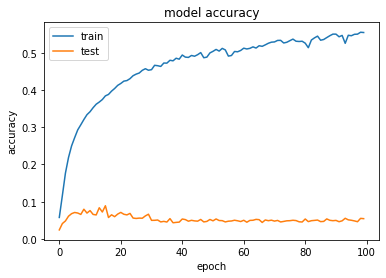

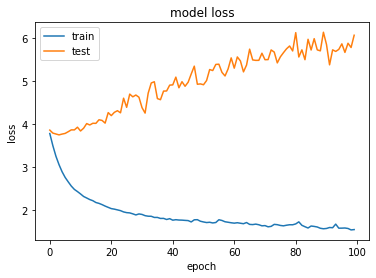

In [28]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

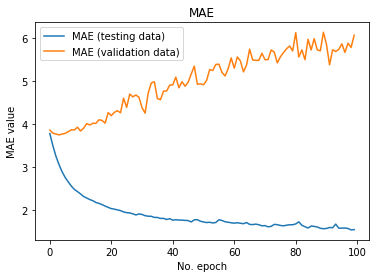

In [29]:
# Plot history: MAE
plt.plot(history.history['loss'], label='MAE (testing data)')
plt.plot(history.history['val_loss'], label='MAE (validation data)')
plt.title('MAE')
plt.ylabel('MAE value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

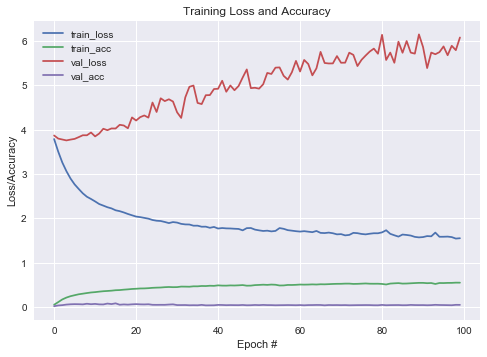

In [30]:
import matplotlib.pyplot as plt

N = np.arange(0, len(history.history['loss']))

# You can chose the style of your preference
# print(plt.style.available) to see the available options
plt.style.use("seaborn")

# Plot train loss, train acc, val loss and val acc against epochs passed
plt.figure()
plt.plot(N, history.history['loss'], label = "train_loss")
plt.plot(N, history.history['accuracy'], label = "train_acc")
plt.plot(N, history.history['val_loss'], label = "val_loss")
plt.plot(N, history.history['val_accuracy'], label = "val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
# Make sure there exists a folder called output in the current directory
# or replace 'output' with whatever direcory you want to put in the plots
plt.show()
plt.savefig('../Output/EpochInceptionV3_OF.png')
plt.close()